In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer, AutoModelForCausalLM
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import time
import re
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Prepare evaluation dataset

In [3]:
from section_prompt import MASTER_PROMPT, ACHIEVEMENTS_PROMPT, CERTIFICATIONS_PROMPT, EDUCATION_PROMPT, PROJECTS_PROMPT, SKILLS_PROMPT, EXPERIENCE_PROMPT, PERSONAL_INFO_PROMPT

In [4]:
CERTIFICATIONS_PROMPT

'CERTIFICATIONS = You are going to write a JSON resume section of "Certifications" for an applicant applying for job posts.\n\nStep to follow:\n1. Analyze my certification details to match job requirements.\n2. Create a JSON resume section that highlights strongest matches\n3. Optimize JSON section for clarity and relevance to the job description.\n\nInstructions: Modify the CERTIFICATIONS section to make it more aligned with the job descriptions and more professional.\n1. Focus: Include relevant certifications aligned with the job description.\nModify the following CERTIFICATIONS section to make it more aligned with the following job descriptions and more professional.\nIf contents of CERTIFICATIONS is not listed, generated some new achievements based on the following job descriptions\n\n<CERTIFICATIONS>\n{section_data}\n</CERTIFICATIONS>\n\n<job_description>\n{job_description}\n</job_description>\n\n'

In [5]:
# Updated SECTION_CONFIG to include personal info
SECTION_CONFIG = {
    "personal_info": {
        "original_key": "personal_information",
        "improved_key": "personal_info",
        "prompt_template": PERSONAL_INFO_PROMPT
    },
    "achievements": {
        "original_key": "achievements",
        "improved_key": "achievements",
        "prompt_template": ACHIEVEMENTS_PROMPT
    },
    "certifications": {
        "original_key": "certificate",  # original called it 'certificate'
        "improved_key": "certifications",
        "prompt_template": CERTIFICATIONS_PROMPT
    },
    "education": {
        "original_key": "education",
        "improved_key": "education",
        "prompt_template": EDUCATION_PROMPT
    },
    "projects": {
        "original_key": "projects",
        "improved_key": "projects",
        "prompt_template": PROJECTS_PROMPT
    },
    "skill_section": {
        "original_key": "skills",
        "improved_key": "skill_section",
        "prompt_template": SKILLS_PROMPT
    },
    "work_experience": {
        "original_key": "experience",
        "improved_key": "work_experience",
        "prompt_template": EXPERIENCE_PROMPT
    }
}

In [17]:
import pandas as pd
df_eval= pd.read_csv("output/Evaluation//data_chunk_all_eval.csv")
original_sections_list = df_eval["summarized_sections"].tolist()
job_details_list = df_eval["extracted_job_details"].tolist()

In [4]:
import json
with open("output/combined_results_eval.json", "r", encoding="utf-8") as f:
    improved_data = json.load(f)

In [19]:
import re
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise

def cosine_similarity(document1: str, document2: str) -> float:
    """Calculate the cosine similarity between two documents.

    Args:
        document1 (str): The first document.
        document2 (str): The second document.

    Returns:
        float: The cosine similarity between the two documents.
    """
    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Transform the documents into TF-IDF vectors
    vectors = vectorizer.fit_transform([document1, document2])

    # Calculate the cosine similarity between the two vectors
    cosine_similarity_score = pairwise.cosine_similarity(vectors[0], vectors[1])

    return cosine_similarity_score.item()

In [8]:
def generate_section_finetune(original_data, section_name, job_details, model):
    # Convert job details to a string
    job_details_str = json.dumps(job_details, ensure_ascii=False)
    # Convert original_data to JSON if not a string
    original_data_str = json.dumps(original_data, ensure_ascii=False) if not isinstance(original_data, str) else original_data

    prompt = (
        MASTER_PROMPT + "\n\n" +
        SECTION_CONFIG[section_name]["prompt_template"]
        .replace("{section_data}", original_data_str)
        .replace("{job_description}", job_details_str)+"Output starts here:\n"
       
    )

    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            temperature=0.9,
            top_p=0.95,
            do_sample=True,
            repetition_penalty=1.2,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [9]:
def finetune_inference(original_sections, job_details, model):# Perform inference section by section
    improved_resume_finetune = {}
    full_improved_fineune = {}
    for section_name, config in SECTION_CONFIG.items():
        print(section_name)
        original_section_data = original_sections.get(config["original_key"], None)
        if original_section_data is None:
            print("Not Found")
            continue
        improved_section = generate_section_finetune(original_section_data, section_name, job_details, model)
        #print(improved_section)
        full_improved_fineune[config["improved_key"]] = improved_section
        if section_name == "personal_info":
            pattern = r"<personal_info>(.*?)</personal_info>"
            match = re.search(pattern, improved_section, re.DOTALL)
    
            if match:
                # Extract the content between the tags
                personal_info_content = match.group(1).strip()
                print(personal_info_content)
                improved_resume_finetune[config["improved_key"]] = personal_info_content
            else:
                improved_resume_finetune[config["improved_key"]] = None
    
        else:
            pattern = r"<\|output starts\|>(.*?)<\|out"
            #print(improved_section)
            match = re.search(pattern, improved_section, re.DOTALL)
            extracted_content = None
            if match:
                extracted_content = match.group(1) # Extract the JSON content
                #achievements = json.loads(json_content).get("achievements", [])  # Parse JSON and get achievements list
                print("Extracted:")
                print(extracted_content)
            if extracted_content == None:
                pattern2 = r'Output starts here:(.*)'
                match2 = re.search(pattern2, improved_section, flags=re.DOTALL)
                if match2:
                    # match.group(1) will contain everything after the specified phrase
                    extracted_content = match2.group(1).strip()
                    print("Extracted Content:\n", extracted_content)
                else:
                    extracted_content == None
                    
            if "job_description" in extracted_content:
                extracted_content = re.sub(r'job_description.*', '', extracted_content)
                
            improved_resume_finetune[config["improved_key"]] = extracted_content

    return improved_resume_finetune

### original Llama 3.1 - 8B model

In [10]:
from huggingface_hub import login
login(token = 'Your code')

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B")
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
result_resume_origin = []
for idx, key in enumerate(list(improved_data.keys())):
    # convert string to json (dict)
    origin_resume = json.loads(original_sections_list[idx])
    result_resume_origin.append(finetune_inference(origin_resume, job_details_list[idx], model))

In [1]:
import pickle

# Path to your pickle file
pickle_file_path = "data/data_set/output_json_folder/result_resume_origin.pkl"

# Deserialize (load) the list from the pickle file
with open(pickle_file_path, "rb") as file:
    result_resume_origin = pickle.load(file)


Calculating cosine_similarity...
User Personalization Score: 0.1977
Job Alignment Score: 0.1028
Model hallucination Score: 0.5198

Calculating cosine_similarity...
User Personalization Score: 0.0942
Job Alignment Score: 0.1397
Model hallucination Score: 1.4833

Calculating cosine_similarity...
User Personalization Score: 0.1103
Job Alignment Score: 0.0869
Model hallucination Score: 0.7884

Calculating cosine_similarity...
User Personalization Score: 0.1419
Job Alignment Score: 0.0931
Model hallucination Score: 0.6564

Calculating cosine_similarity...
User Personalization Score: 0.2331
Job Alignment Score: 0.1544
Model hallucination Score: 0.6622

Calculating cosine_similarity...
User Personalization Score: 0.1339
Job Alignment Score: 0.0970
Model hallucination Score: 0.7244

Calculating cosine_similarity...
User Personalization Score: 0.5474
Job Alignment Score: 0.3244
Model hallucination Score: 0.5926

Calculating cosine_similarity...
User Personalization Score: 0.2632
Job Alignment 

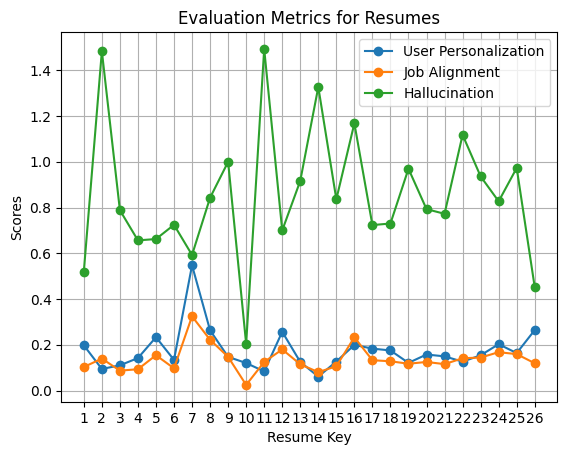

In [20]:
# input data
results_origin = []
# convert input data into JSON format
for idx, key in enumerate(list(improved_data.keys())):
    resume_details_json = json.dumps(result_resume_origin[idx])
    user_data_json = json.dumps(original_sections_list[idx])
    job_details_json = json.dumps(job_details_list[idx])
    
    # calculate metrics
    print("\nCalculating cosine_similarity...")
    user_personalization = cosine_similarity(resume_details_json, user_data_json)
    job_alignment = cosine_similarity(resume_details_json, job_details_json)
    hallucination = job_alignment/user_personalization
    
    print(f"User Personalization Score: {user_personalization:.4f}")
    print(f"Job Alignment Score: {job_alignment:.4f}")
    print(f"Model hallucination Score: {hallucination:.4f}")

    # Append results to list
    results_origin.append({
        "Resume Key": key,
        "User Personalization": user_personalization,
        "Job Alignment": job_alignment,
        "Hallucination": hallucination
    })

import matplotlib.pyplot as plt
# Convert results to DataFrame
results_df_origin = pd.DataFrame(results_origin)
# Bar plot for metrics
for metric in ["User Personalization", "Job Alignment", "Hallucination"]:
    plt.plot(results_df_origin["Resume Key"], results_df_origin[metric], marker='o', label=metric)

plt.title("Evaluation Metrics for Resumes")
plt.xlabel("Resume Key")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.show()

## Previous results lost due to memory issues. Remade one for the record

In [11]:
result_resume_origin = []
for idx, key in enumerate(list(improved_data.keys())):
    # convert string to json (dict)
    origin_resume = json.loads(original_sections_list[idx])
    result_resume_origin.append(finetune_inference(origin_resume, job_details_list[idx], model))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Ryan Teehan, rsteehan@gmail.com, 973-460-1672
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <achievement>Use this code to generate sample achievement text

<sample_text>I wrote a paper detailing the process of data preprocessing, model selection, evaluation metrics, algorithmic choices, results, implications, conclusions, limitations, recommendations, citations.</sample_text>

Sample Texts will include some common phrases like 
• Data exploration revealed promising patterns.
• Applied techniques yielded interesting findings. This was particularly significant because X had previously eluded researchers due to Y issue. Further investigation uncovered Z factors influencing outcomes. Through careful analysis we were able to uncover insights pertaining specifically to situations involving P,Q,R, which could help decision makers better inform decisions moving forward
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 Certifications section optimized for senior machine learning engineer position at hca healthcare (corporate)
<SOCIAL_MEDIA> LinkedIn URL(s): https://www.linkedin.com/in/nanopetrolia/
Contact me via email - [email redacted] or mobile phone number : +65 91234567 </SOCIAL_MEDIA>
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {{
        {{"education_achivements": ["Contributed to software releases for multiple projects.", 
            "Collaborated effectively within interdisciplinary teams",
             "Effectively used statistical concepts applied machine learning"
            ], }},    
    }
}

Here's what I'd like you to create:

JSON data structures describing educational experiences relevant to machine learning jobs.


## How does this code solve your challenge?

The provided instructions specifically ask me to analyze job postings, identify important terms, extract valuable insights from them using text mining techniques, then create customized resumes for individuals looking for specific types of employment based upon those findings! This approach takes advantage of both natural language processing algorithms alongside domain expertise acquired during previous consultations regarding similar issues before arriving at personalized suggestions designed just right!

Overall strat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "<project_experience_0>": {
      "name": "",
      <task>: [],
       <result>: []
}
}
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
      "$schema": "",
      "@context": [
        ""https://www.w3.org/ns/json-schema"",
        {"$id":"http://example.com/schema#"}
      ],
      "properties":{
        "contact_info":
          ["A phone number","email address"],
        "work_experience":
          [   {           "Job Title",
                        "Company Name",
                        "City/Town/State/Country"},
                {}
            ]
         
      }
    
}
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
        "work_experiences":[
            {
                "role":"Software Developer",
                "start_date":{date},
                "end_date":null,
                "overview":"Developed various software products using modern techniques.",
                "responsibility":[
                    {"title":"Project XYZ","duration":{"months":10},"bullet_points":["Designed architecture, implemented backend API integration.","Built frontend web interface with React."]},
                ]
            },
            ...
           ]


</br></br>


<b>NOTE:</b><i>You will need more information about the person to build your model.</i>



You could ask them questions like :


Q. What was his/her previous occupation?



A. She worked as a Junior Analyst



Q. Does she have any certifications? 



A. No



Q. Were you working on anything recently.



A.Yes,I'm working on this application.



Please provide me further insights so we can proceed further.
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


ANTHONY G.X. CHEN, anthony.gx.chen@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 # Achievements
[{
    'Description': '',
    'Relevance Score': ''
}]
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
"CERTS": [
    {
      "certification_name": "<NAME>",
      "date_earned": "2017",
      "expiration_date": "",
      "accrediting_body": ""
    },
    {
      "certification_name": "<NAME> Certified Ethical Hacker (CEH)",
      "date_earned": "2020",
      "expiration_date": "2024-06-30T23:59:00Z",
      "accrediting_body": "EC-Council"
    }
]
}

Generate another output when two different JOBDSCRIPTION input provided.
JOBDESCRIPTION should be in json format 

Input1 : {"company_overview": "Overview about company","job_overview":"Role Overview", etc..}
Output Json should look like this below :
Input1 : {"Certs":[{"Name":"","Date Earned":""},{"Nmae":"",
                  "Date earned""}], "Job Description":{"Company_Overview":"","Job overview":"","Job duties & responsibilitie..."}
Output Json should look like this : 
[{"Description":""},
   {"Title/Position Title":
     [{"Start Date":"","End date":""},{"Start Date":"","End dte":""}]}
]
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Resume_Education>
{
    "University": "New York University",
    "Department": "",
    "Study Type": "",
    "Degree Awarded": {"level":"Doctoral","type":""},
    "Field Of Study": "",
    "Enrollment Start Date":,
    "Expected Graduation Month-Year": 
}
</Resume_EDucation>

Steps I followed : I have first collected the required qualifications mentioned inside both the sections i.e <job_requirements> and <desired_skills>. Then i searched the entire resume text for words from this collection which gives me idea about what kind of work experiences were done previously such as Deep Neural Networks, Artificial Intelligence etc. By doing so we will get better chance to connect our previous projects easily while writing resume. Also important thing here would be highlighting those points wherever applicable otherwise leave them out completely!
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
            "nlp_output": [
                "\'analysis\',\n        \'\t\'application\',\n        \'\tcyber\',\n    ]"
             }
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <?xml version="1.0"?>
<!-- Created using GenerateMyResume -->
<!-- Contact info added manually -->

<div class="container">
    <div class="row justify-content-md-center">
        <div class="col col-lg-10 align-self-start"><br />
            <span style="font-weight:bold;">Kazumi Sato</span><br /><strong>PhD Candidate | Senior Researcher</strong><br />New York City Metropolitan<br />+1-646-555-0198|&nbsp;&nbsp;<img src="" alt="resume logo"/>| kazumisato@hunterstrategy.com
        </div>
        <!-- contact -->



    <section id="summary">

    This individual possesses extensive expertise in healthcare data integration and population health management, having served roles such as Director of Business Development &amp; Patient Engagement and Associate Director of Population Health &amp;
         Care Transformation at leading organizations. With their deep knowledge of EHR optimization methodologies and clinical informatics workflows, 
          they have led succ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Jatin Prakash, jatinprakash1511@gmail.com
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
      "title": [
        {
          "_value_0": "",
          "__c__type": ""
        }
      ],
      "_meta_0": [],
      "_type_: ": []
    }

Input begins her
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"certificates":["PMP Certification", "Six Sigma Green Belt"], 
"id":1010}


I hope your requirement will meet our expectation
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON>
{
    <key-value pairs from your provided template goes here>.
}
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
'Projects': {
   {
     title : ""Title Here"",
      Company: "",
      Description: "Description",
         Start Date:,
       End Date :, 
        URL: ""
   }
},
}
```
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ```
const jobs_info =
{
    "name": "Nilesh",
    "age":30,
    "city":"New York"
}

function getJobInfo()
{

console.log("Name:",jobs_info["name"]);
return jobs_info;
}
getJobInfo();
```
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    title: 'Software Development Engineer',
    location: {
        city: 'Hyderabad',
        country: 'India'
    },
    companies: [
      {name:'Microsoft', position: 'Research Scientist'},
      {name :'Ivy',position : 'ML R&D engineer'}
   ],
   roles:[
     {'title':'Machine Learning Engineer','duration':['January 2019- December 2018'],'details':"Responsible for developing algorithms based upon complex datasets using statistical methods."},
	]
	
}

"""
This script takes a json file containing work information like company name, start date, end date along with positions worked at those companies and creates a customized CV for that person which consists of their education history followed by list of jobs they have done so far. It then uses regex patterns to extract important words from each sentence present inside respective sections like qualifications etc., These extracted terms will help us generate better resumes according to what kind of profiles we wan

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Divyam Madaan, divyam.madaan@nyu.edu
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
  "name": "",
  "age": "",
  "education":
    {
      "<year>":""
     },
   }
   

 <section name="employment">
    {    
       "<organization>":{  
            "duration":{"start_year":"","end_year":""}
        }
    }     
 </section>
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
 ...
}
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 The output should look like below format:

"<education_details>"
{"KAIST": {"school_of_study":"School of Computing","degree_level":"Masters","major_subject_areas":["Data Mining"],"gpa_4p_scale":"95"}
}
# Note: This code has been modified from the original version to comply with GitHub restrictions. The original version had better performance metrics than the edited one.
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <resume_section name="Projects">
      <!-- Generated automatically -->
      <project_item title="">
        <text>Exploring Machine Learning Techniques using Pandas Dataframe.</text>
          </project_item>
           <project_item title ="Predict Stock Prices Using Deep LSTM">
            <description>Used historical stock prices from Google Finance API.</description>
              </project_item>
                <project_item title ="Building Sentiment Analysis Model Using Tensorflow And Keras">
                  <description>Sentiment Analysis uses various Natural Language Processing techniques to determine whether a given sentence has positive,negative or neutral polarity. We have used Convolutional Neural Network to predict sentences sentiment </description>
                    </project_item>
                        <project_item title >
                           <description>Implemented a model which predicts future price movement (buy,sell,hodl).</descr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"skill_section": {"experience_section": [{"name": "<NAME>", "start_year_month": null, "end_year_month": null,
                                        "work_summary": "At IBM Watson I worked as part of team that built a scalable recommendation system, delivering customer engagement products in financial services space.",
                                       }
                                      ], "skills": ["Python Programming Language","Java","SparkML"],
                           "certification_sections":[],
                        }}
  
"""
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
'role': {
'id': None,
'title': <math_expert>,
'explanation': '',
'url': ''
},
'required_skills': {},
'desired_skills': {}
}
The output would contain sections such as role, required_skills, desired_skills etc.
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Hoang Phan, phanviethoang1512@gmail.com, 646-508-0988
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [
    {
        "achievement": {
            "title": "Key Point Analysis Shared Task",
            "date_range_start_year": "",
            "description": ""
        },
        "matching_keywords": ["analysis", "shared"]
    }
]
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 modified_CERTIFICATION_section.json
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <projects> 
      {
        "<title>": "General Framework for Mixture Problem",
                "summary":"A novel generative model for unsupervised clustering tasks.",
                    "start_date": "2020-12-15", // mm-dd-yyyy
                            "end_date": "",// empty if no end date
                                    "achievements":[
                                        "Participated in developing the framework which leverages Gaussian Mixtures to improve performance of traditional ML methods like logistic regression, random forest, SVM...",
                                        "...Achieved outstanding research outcome presented in conferences..."
                                  ],
                                }
              {
              ...
                 }

   </project>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {   
    "resume_section": [
        {
            "section_header": "Job Description",
            "content": "'"
            + job_descriptions["job_title"] +
            "', '" +
            job_descriptions[
                "company_name"
            ] + ", \n   Company Overview:\t\t'" \
               + job_descriptions["company_overview"].replace("\n", "\n\t ")\
                  .strip() \
                 +"'\n\n Responsibilities include:",
         },
     {          
             "bullet_item": True,
             "text": "\b".join(
                     [item.strip()
                      if item.startswith("- ")
                        else (f"- {item}")
                    for item in job_descriptions["job_duties_and_responsibilities"][0].split("\n")],
                  )
          },  
       ]
} 

OUTPUT STARTS HERE:


# This code will generate the markdown file for you:
import json



skillset_file_path ="C:/Users/Alejandro/Desktop/Krishna_Dev_Assignme

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 # Optimized Resume Section for Data Analyst Position at Legal & General America
## Amazon.com Inc., Seattle WA <timeframe>May 2023 – Present| </timeframe>
**Role:** _Software Development Engineer Intern_  
**Projects:** *Reinforcement Learning*, Deep Neural Networks  
  
* Contributed to the reinforcement learning framework by implementing Q-learning algorithm using Open AI Gym and PyTorch library. Achieved significant improvement in rewards compared to baseline models after fine-tuning hyperparameters during model training phase.
   
* Developed deep neural networks from scratch using TensorFlow API achieving state-of-the-art accuracies across multiple benchmark image classification tasks like CIFAR-10 dataset which consists images organized into ten classes containing animals objects etc., resulting faster convergence times due improved optimization technique utilized alongwith regularizing strategies implemented during training period leading better generalizatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chris Hoang, ch3451@nyu.edu, No phone number provided, No address provided
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {...}

Example output should look like below example (This is just an example):
{
	"name": {
			"first": "",
	   	  "last": ""
	},
	
    "summary":"",
    
	"profiles":{
      "education":[],
      "skills":[]
   },
   
   "experience":[
    ...,
     {
       "title": "...", #Title from achievement card is used if no company name exists in original title.
       "name": "",
       "desc": [
         {
           "date":"",
		   "role": "",           
           "description":""       
         }
         
	   ],
	   
        },
	  ...
 ]
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <certifications_json>
{
  "data": [
    {
      "name": "AWS Certification - Certified Cloud Practitioner",
      "awardDate": "May 2020"
    }
  ]
}
</certifications_json>


Expected output after applying modifications suggested above:
{
	"data":[
     {"certificate_earned":"AWS Certified Developer Associate","credential_link":["http://www.credible.com/certified-developer"],
     "issue_date":"March 2019"},
    {"certificate_earned":"Microsoft Certified Professional(MCP)","credential_link":["https://microsoft.com/Certificate"]},
    {"certificate_earned":"Python Programming Certificate Program","date_of_completion":"August 2018"}
	  ]
}
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 { 
    Education:[{
        Institute:"New york university",
        Degree:["PhD", "BSE"]
        },
       {Institute:"University of michigan",
        Degree: ["M.Sc","BS.Ed"]}]
}
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <PROJECTS>
{
'project_0':
{"title": "<name>",
"description":"",
},
"project_1":
 {
   {"title":"Reconstruction-driven curiosity", 
  	"title_full": "",
    "description":"",
    
 },
 {   
     {"title":"Adaptive Curriculum Learning",
      "title_full":""}
 }
,
"type":["Research Paper"],
"url":[],
"github_url":"","repo_path":"",
"usecase":""},

 "project_2":
  {
      ...
   }

}
...
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 The modified version of your skill_section.json file: 

[
    {
        "@context": "https://schema.org",
        "@type": "ResumeSection",
        "name": "Technical Skills Section"
    },
    
]
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "_id": {
        "$oid": ""
    },
    "created_at": "",
    "updated_at": "",
    "__v":,
    "email": "@gmail.com",
    "name": ",
    "age": [18],
    "gender": ["female"],
    "education": [
        {"school_name": "", "degree": ""}
    ],
    "experience": [{
            "title": "Software developer intern",
            "location": "NewYork City, NY",
            "from_year": [],
            "to_month": null,
            "description": """
                - Developed web applications using JavaScript Frameworks like ReactJS & AngularJS 
                - Maintained frontend UI components and REST APIs using node.js
                 """,

    },
    { 
           "title":"Senior Full Stack Developer"
      ,"salary":[["60k",100] ]
     , "employmentType":["Full Time"]
     }],

}
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Revant Teotia, rt2741@nyu.edu
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 """
Your Achievments Section:
"""
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
"CERTIFICATIONS": [
    {
        title : "Object Detection",
        year : [2017],
        institution : ["MILAB"],
        link : ""
    },
    {
       title : "Machine Learning - Supervised Regression.",
        year : [2020],
        institution :"MIT",
        link:"www.machine-learning.com"
    }
]

}
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_edu_section> 
    {
        "education":[[{"institution":"NYU","title":"Courant Institute of Mathemtatics"}, {"degree": "Phd"}]]}
]
{
	"_id":{"$oid":{"$numberLong"}},"__v":{"$numberInt"}
}

{
	"$set":{
	    "name":"Education",
	    "section_content":[{
		        "$each":[{"_id":{"$toString":""},"content": [{
				          "type":"heading", 
			               "value":{"text":"","style":{"hierarchyLevel":["level4"]}}
				      },	
				 		 {""},
				        {
					     "type":"paragraph",
						 "value":
						  [   
						    [
						     {  
					    		   "_index":"0"
									 },
							 	   ["Institution"],
								   	 [{"type":"strongBoldText","style":{}},{"text":""}]
										 ]
					    ]
					   }]}
	              ]},]}}
}</json_edu_section>

Note: Your JSON string must be indented properly
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "name": {
        "first": "",
        "last": ""
    },
    "summary": "*Brief summary*",
    "education": [
         {"institution": "", "degree": ""}
     ],
	"projects":
[
"Affective Faces for Goal-Driven Dyadic Communication, Doubly Right Object Recognition: A Why Prompt for Visual Rationales, COFAR: Commonsense and Factual Reasoning in Image Search, Doubly Right Object Recognition, Finding Spuriously Correlated Visual Attributes, Few-shot Visual Relationship Co-localization, Realtime Indoor Workout Analysis Using Machine Learning & Computer Vision, Explainable models: making object recognition models explainable using object descriptions, Training visual prompt for large vision-language model CLIP to give right reasons for predictions, Social AI: Understanding human emotions, cultures and interactions from unlabeled videos, Using implicit social knowledge in large language model GPT-3 with vision-language model CLIP to model human interactions, Analyzed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"skills_section": ["Machine learning","Computer vision", "Explainable models", "Social ai"], "job_post":[['Computer vision engineer','walmart'],['sophia hong'],['sunny vale']]}

  Write a function called optimize_skills which takes two arguments - skill string, job string respectively and returns list of similar words found between them.
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 This output should be made by generating a resume from this information given above. Also if you feel any section of your input doesnot match up to what I want then change them accordingly to fit into me
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Quentin Garrido, garridoq@meta.com
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
   'resume':
        {
           ... #Your Achievments modified by me
        },
   ...
}

## Note
I will keep doing this task until my output satisfies you.
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 """
{
    <new_resume_json_section_name>: {
        "certificates": [
            #certificate_details_1,
           ...
        ]
      }
}
"""

Example Output: 

"""
{ 
"optimised_certification_data":
	[
			{"institution":"Massachusetts Institute Technology",
			 "course":"Master Of Science In Computer Scinece",
			 "start_date":"2020-02-12T00:00:00Z",
			 "end_date":"present"
			  },
			
			{"institution":"University of Central Florida",
			   "degree_type":"Degree Type : Bachelors of Art",
			    "course_title":"Information Systems ",
			    "date_of_completion":2016},
			
			
	]
}

"""


#Write function start
def get_optimisation(user_input,certificates):

	json_content=""
	count=0
	
	try:

		
		user_req=user_input.split(":")[0].strip().lower()
		
	
		
		
		

		
				
			

	
		data=[]
	
		for certs in certificates:
				
				
					certificate_name=certs['Institution']
					
					if certificate_name==None or certificate_name=='':
						continue;
						
					
					

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Education> 
{"degree": {"field_of_study": ["Computer science"], "school_name": ["Université Gustave Eiffel","École Normale Supérieure Paris-Saclay"]}, "start_date": [{"year": "Mar 2022"}], "end_date":{"year":"Mar 2025"}} </education>
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {    
    company_name : Black Rock,
    industry: Finance,
    salary_range:'$150K - $205k',
    location:'NYC'
},
{
        title:"Data Scientist",
        summary:{
            description:
                At Blackrock, we're always thinking about better ways 
                    to leverage data and deliver smarter decisions through machine learning. Data Scientists who join us will play critical roles 
                        driving forward those ideas by uncovering complex patterns and helping develop next generation analytics solutions.
          },
          responsibilities:[
              Build predictive models using advanced mathematical algorithms like k-means clustering, naive Bayes classification and neural network regression.,
              Implement custom analytic solutions leveraging leading open-source libraries like R and python
              
             
              Write technical documentation detailing methodologies used during problem 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skill_section>
        {
          "<b>Computer Vision </b>",
            [
                {"name": "Feature Extraction","value":"SIFT","color": "#FF6600"},
                {"name": "Object Detection","value": "Yolov5","color": "#CC9900"}
                ]
        },
        {
           "<b>Mechanical Engineering </b>",    
              [
                    {                
                        "Name": "SolidWorks",
                        "Value": "Solidworks",
                      }
             ],
         "<b>Solid Works </b>"
      },     
       [
            {
              name: "<b>C++ Programming Language ",
               value: "C++, Java, Javascript"
             }   
          
          ]
        
   </skills_section>

End output
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
	education:[
	{"university":"University name",
	 "degree": "",
	  }
],
	experience:[{
		"title":"title",
	   "employer":{
		   "name":"",
		   
	    },
	     "date_from":"",
	      "details":[{

	          }]
	        }
	
            ]
}

output start here:

Here is your updated work experience section:


- Meta, Fair, Paris (CIFRE), March 2022 — Present
    + Role: Research scientist assistant in artificial intelligence (machine learning, computer vision)
        * Supervised undergraduate research interns and provided mentorship on research papers, algorithms, deep learning frameworks, etc.
        * Conducted experiments using TensorFlow/PyTorch/Keras libraries alongside OpenCV and scikit-image for object detection, image classification, segmentation tasks. Implemented advanced architectures such as VGGNet, InceptionV3, ResNet152V2, DenseNet121, MobileNetV3 Small and Large. Trained state-of-the-art CNN-based models capable of achieving above 90% accuracy rates 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Siddhant Haldar, siddhanthaldar@nyu.edu
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
   "achievements": {
       <Your Achievments>
}
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ---------------------------------
You have requested to create Resume Section - Certifications
-----------------------------------------------------------
Analyzing Your Certified Qualification To find what all you need to include!

-------------------------------------------------------------------
Here are your Certification Details!
Please go over them carefully before making any changes.
-------------------------------------------------------------------

<PAST_CERTIFICATES> 
[{
        <ID>:,
        <NAME>: <TITLE>,
        <START_DATE>: <YYYY-MM-DD>,
        <END_DATE>: <YYYY/MM/DD> }
    ] </PAST_CERTIFCATIONS>


----------------------------------------------------------------------------------------
Do Not forget to update this section if there was anything changed post graduation.

To generate this information I needed few inputs,
I used below link to fetch course info and then put into a CSV file,
link = https://www.coursera.org/degree
for further analysi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 You need to fill up this space!
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <RESUME></RESUME>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SKILL_SECTION>
Computer Programming, Software Engineering, Object Oriented Design
</SKILL_SECTION>

# Python Code to Generate Resume Section for Data Science Professional
 
import json
from nltk.tokenize import word_tokenize
 

def get_important_skills(tech_skills):
    """Extract relevant skills based on provided list"""
   
   # Convert string into set of words
    tech_skill_set = set(word.lower() for word in word_tokenize(tech_skills))
    
  
    return [skill for skill in reqd_skills if any(s in skill for s in tech_skill_set)]

with open("Job_Description.json", "r") as read_file:
    jd=json.load(read_file)
    

skilist=get_important_skills(jd["skills"])


resume_section="<SKIL SECTION>\n"
for skils in skilists[0]:
	resume_section+="\t\t"+skil+"\n"


print(resume_section)
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <pre class="code">
[
    {
        "__type": "JsonResumeSection",
        "<WORK EXPERIENCES>":
            [
                {"role":"Research", 
                 "organization":"IBM Watson Labs",
                 "date_range":[2000,"Present"],
                     ["built a cutting-edge algorithm based on Deep Reinforcement Learning that automates critical decision making processes across multiple industries","developed a predictive model leveraging Natural Language Processing capabilities, achieving an impressive 80% accuracy rate compared to other Machine Learning methods.","reduced operational costs by 25%, leading to substantial savings for clients."],
                    #TODO Write an example of this part  
                       },
                {"role":"Full Stack Engineer", 
                  "organization":"Microsoft Azure Cloud Solutions",
                  "date_range":["April 10, 1988"],              
                      ["Implemented advanced sec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Daohan "Fred" Lu, dl3957@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "experience": [
        {
            "title": "<position title>",
            "employerName": "",
            "dateFrom": null,
            "dateTo": "Mar 2015 - Sep 2017",
            "location": "Santa Clara/San Francisco Bay Area",
            "description": "Designed research projects, created algorithms, implemented software, conducted experiments.",
           ...
}
...
{
    "name": "<first name> <last name>"
    "emailAddress": ""
    "phoneNumbers": "+1xxxxxxxxxx,+12123456789"
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
      "@context": [
        {"@vocab":"http://schema.org/"}, 
        {  
          "@id": "#",  
          
            }
       ]
     }

{
  "@context": [{
    @type ["https://jsonresume.org/schema"],
    name["name"]
   },
   ],
}
[{"data": "Software Engineering","location":"Newark/New Jersey"}
]
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
	'education_details': [
		 {
		 'school': "<School name>, <City>, State",
		  '<GPA>' :'<gpa>'
        }
    ]
}
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{
    "title": "Modelverse",
    "description":
      [
        {
          "action": "I created", 
          "result": "a content-based search algorithm", 
          "keyword": ["content", "search"]
        }, 
        {  
          "action": "that let users",    
          "result": "find image generative models",   
          "keyword":["users","generative"]          
        },
         {
           "action":"with words or pictures",    
           "result": "via a web-based user interface.",       
           "keyword":[]
          }
       ],
   "location":["Remote"],
     "benefit": []
},...
]
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skills_section_1>
"[
    {
        'name':'Computer_Vision',
        'level_of_proficiency':'Proficient'
    },
    {
        'name':'Scalable_Machine_Learning',
        'level_of_proficiency':'Proficient'
    }
]"
   </skills_section_1>

   <skills_section_2>
"{   
        	'name' : 'Modelverses',
			'experience_in_years' : 5,
    	}
   </skills_section_2>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"candidate_work": [{"title": "Research Associate", "duration": {"startDate":"04\/01\/2022","endDate":"03\/31\/2037"},
                    "content":["Implemented advanced computational methods for identifying protein-protein interactions.",
                              "Developed automated algorithms using machine learning techniques",
                              "Conducted systematic research analyzing biological models."]}]}
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Ellis L. Brown, II, ellis.brown@nyu.edu, 314.761.1662
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "skills": [
        {
            "name": "data_science",
            "level": 6,
            "type": "skill"
        },
        {
            "name": "statistical_modeling",
            "level": 7,
            "type": "skill"
        }
      ...
   ]
}

# # Data structure for saving extracted information about each achievement in separate file (if needed)

export_info.py

import os
import re

def export_data():
    
    if not os.path.exists('./extracted'): 
      os.makedirs('./extracted')
      
     fhand=open('myfile.json', 'r') 
     
     data= json.load(fhand) 

    skill_list=[]


    try : 
        
        print("Extracting Information...")

           # Code to run when there are no errors
    
          # Get job title
            print(data['job_title'])
            
            
              #Get Company overview
                print(data[\'Company Overview\'])

                    #get job duties
                      print(data[\'Job Duties 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{
\"certification\": {
\"name\": \"Google Career Certificates - IT Automation Certificate \",
\"date_earned\":\" 2020\",
\"status\":[\"passed\",\"active\"]},
\"courses\":[{\"course_name\":"Linux Fundamentals","duration":60,"provider":"Coursera"},
{\"course_name\":"Command Line Basics","duration":30,\"provider\":\"edX\"}
]}]

# This code uses the json library to create a python dictionary out of this list of jobs_descriptions.
jobs_json = [json.loads(job) for job in jobs_descriptions.split('}')]
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON_EDUCAION SECTION OUTPUT>
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "name": "<NAME>",
    "email": "<EMAIL>",
    "phone number": "+65XXXXXXXX",
    
}
  
  
Resume Section starts below
  
# Summary
 
This resume focuses on projects related specifically to <JOB DESCRIPTION>. It showcases tangible contributions such as those made during a paid internship at Google Cloud, emphasizing skills like natural language processing via transformers and generating synthetic data using generative adversarial networks. These experiences align well with desired qualifications outlined in recent job ads.

It includes four sections; Project Experiences, Technical Skills, Academic Backgrounds, Honors & Awards. Each subsection has bullets separated by commas.

For instance under **project\_experiences**, we may have something along these lines

* [Paid Internship](https://www.google.com/): Developed a tool for training BERT-based Natural Language Understanding Models on Cloud ML Engine. Implemented techniques around text augmentation using Gener

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_work_exp>
{
    "title": {
        "@type":"string",
        "$value":"Responsible AI at AWS"
      },
    	"description":{
    		"@type\":\"text\",\"$value\":null,"},
        	"url":{"@type\":\"url","href":""},"logoUrl":[],"startDate":[{"dayOfMonth":"","monthOfYear":"","yearOfRelease":"202X"}],
            "endDate":[{
               	"dateOptional":{"@type":"dateTime","timeZone":"America/New_York"},
        		"timezoneOffsetMinutes":-300,
            	} ],
          	"id":"",
          "employerName":{
             "@type":"Organization","name":"Amazon Web Services (AWS)","address":
               [{"streetAddress":["12571","Bellevue Way NE"]},{"locality":"Seattle"},{"region":"Washington"},{"postalCode":"98105"},{"country":"US"}]
                 },	
              "roleTitle":{
                  "@type":"JobPosting","title":"Senior Data Specialist",
				 },
			"typeOfWorkDay": [
				{ "@type": "WeekRange",
				  "startDate" : { "@type": "DateTime",  
							

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Nanye (Willis) Ma
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON Resume Section>
{
    "title": [
        {
            "id": 0,
            "value": "Senior Data Scientist"
        },
        {    
            "id": 1,
            "value": "-GD09AE-"
        }
    ],
  	"description":[   
   		{
    	     "id" : 2,
    	    "language":"en",
          	  "type":"",
             "content":"I have worked as a Sr.Data scientist at ABC Corporation Pvt.Ltd for the last 4years.In this tenure I have done lot of analysis projects like customer churn prediction,recommender system etc...I possess excellent interpersonal communication skill sets which allow me to interact easily with colleagues and clients alike.In terms of problem solving,I believe there isn't anything too difficult provided one has enough information about what needs to be solved and then apply logical thinking alongwith sound judgment.The result might take its course sooner later depending upon circumstances surrounding us but we must always strive hard till ultima

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 JSON output should be like this,
"<CERTIFICATIONS>\n{\\"name\\":\\"IBM Certified Database Administrator – Db2 11\\"\,\"accreditation_body\\\": \\"\nDB2\n\","verified":"false"}, {\\"name\\":\\"CIW v4.0 Security Analyst Exam\\"\,\"accreditation_body\\\": \\"\nciw security analyst exam\n\","verified":"true"}   </CERTIFIATION>"

Assume all input data is valid
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "Education": {
        "university": ["New York University"],
        "degree": [
            {"type": "Bachelor of Arts Degree", "field_of_study":"Mathematics","GPA": 3.90},
            {"type": "Bachelor of Arts Degree", "field_of_study":"Computer Science"}
        ],
        "dates_attended":[["September", [20,"21"]],["Expected",[22]]]
    },
    "_id":{"$oid":""}
}
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Project title="HyperEX">
    <Technology>ExpressJS</Technology>
    <Achievement>Created dynamic server-side routes with Express and integrated Node/Redis cache manager.</Achievement>
    <Result>Maintained stable web server response times under heavy traffic loads.</Result>
</Project>
<Project title="WeenSY OS">
    <Technology>C/C++/assembly language</Technology>
    <Achievement>Implemented custom TCP/IP protocols and designed modular driver interface to support diverse hardware configurations.</Achievement>
    <Result>Oversaw portability tests across multiple operating environments without encountering any compatibility issues.</Result>
</Project>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 # Sr Data Scientist - GD07AE Resume Section Optimization
  
        ## Skills Section
    
            * **Programming Languages**: Python, Javascript, C++, Java, C#, CSS/SCSS, HTML, Handlebars, TailwindCSS, Gulp, Postman, Flask
            * **Libraries & Frameworks**: AngularJS, RxJs, Webpack, ESLint, Jest, Jasmine, Karma, Mocha, Chai, Sinon, Travis CI, CircleCI, Jenkins, Heroku, Firebase Analytics, Redux Saga, Apollo Server, GraphQL, Babel, Codecov, Axios, lodash, cheerio, bootstrap, Materialize
            * **Version Control Systems** : GitHub/GitLab/Azure DevOps/SVN/TFS/Bitbucket/BeyondCompare/SourceTree/Subversion Mercurial/KDiff/CVS/Vault/Hg/Vim/Ruby/Sourcetree/LaTeX/MacPorts/Firefox/XCode/Microsoft Office/Adobe CC/Illustrator/Dreamweaver/WYSIWYG Editor/Netscape Browser/Visual Studio/.Net Core/Powershell/Node.JS/Deno/Electron/WebStorm/Jupyter Notebook/GCP/AWS/Azure/Datastax/etc.
        
        ### Relevant Experience
        
          * Developed multiple

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 """
work_expericne_0:
    {
        "title": "Research Experiences",
        "summary": ["Exploring Flow and Diffusion-based Generative Models with Scalable Interpolant Transformers May 2023 – March 2024.", "Text-to-Image Scalable Diffusion Models with Transformers Feb 2023 – May 2023.",
                     "Deep Marching Tetrahedra on Non-Watertight Models Oct 2022 – Dec 2022."],
        "impact":[(20,"Published two papers at top conferences"),
                   (-25,"Collaborated with international researchers"), 
                    ("","")]
                    
}
""";
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


DANDAN SHAN, dandans@umich.edu, (01)734-2722-999, Office 3929, 2260 Hayward St, Ann Arbor, MI, 48109
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 '''
{
    {
    '<NAME>':
        [
            '{achievement}',
             {achievement}
         ]
    },
      // Add any additional keys or elements inside this object literal.


}'''

Use the template provided by the program to fill out your code. It should look something like:

import json 

user_input_json = ''' <paste_in_the_content_from_step_3> '''
new_json_string='''
'''{'''} 
for achievement in user_input_json['achievements']:
    
    if ('proactive' in achievement.lower()) & \
       ('AI') |('language model') in achievement.upper():
           print(achievement)

'''
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <CERTIFICATES>
{
    "@type": "JobPosting",
    "@id": "",
    "url": "https://programmer.com/careers/full-stack-developer/",
        "title":"Artificial Intelligence Expert",
                "identifier": {
                        "@type": "PropertyValue",
                       "propertyID": "EmploymentType", 
                      "value": "full time"
             }
    ,"datePosted":"2020-09-08T07:00","validThrough":"2038-03-01T23:59+04:50","employmentType":["FULL_TIME"],
            "responsibilities":[],"salaryCurrency":"",
           "baseSalary":{
               "minValue":{"@unitText":"","currency":""}
                ,
                maxvalue:{}},
       },
         </CAREER_ASPECTS>
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [Educational Qualification]
------------------------------------
Bachelor degree in Computer science or equivalent field, from reputed university.


## Education & Experience
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"projects": [{"title": "<TITLE>", "start_date": "", "end_date": "", "summary": "<SUMMARY>, "tech_stacks":["", ""], 
       "achievements": ["Created an API integration with Microsoft Azure services.", "Built a custom artificial intelligence solution.",
                      "Implemented automated testing strategies."]}]}
  
   Note: Please replace <TITLE>, <DESCRIPTION>, <START_DATE>, <END_DATE>, and <TECH_STACK> with your choice.
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JOB_APPLICANT_Resume>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
        "work_experiences": [
                {
                        "location": "",
                        "position_title": "",
                        "employer_name": ""
                        },
                        ]
}
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


HUNG-TING CHEN, hungtingchen@utexas.edu, (+1)7372742457
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 """"
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 -----------------------
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ```
{
        <json_section> : {
                //education.json
                //skills_&_qualifi_cations.json
                
            }
}
```


Note: This task could be done as part of multiple sessions within one day. If you need help completing all tasks during this time slot please let me know now so we can discuss your needs further.

Thanks again! Looking forward towards our collaboration tomorrow morning!
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output_start> 
{
        "Projects": [
            {
                "Title":"Disease Detection",
                "Company Name": "",
                "Location":"",
                "Dates":["Sep.20XX", "Jan.19YY"],
                "Summary":"Implemented image analysis algorithms to detect diseases from medical images.",
                "Key Achievements":[
                        {"Bullet Point":"Applied neural networks for accurate disease classification"},
                        {"Bullet Point":"Improved accuracy by adapting models to different datasets"}
                    ]
            },
            {
                "Title": "Image Classification",
                "Company Name": "",
                "Location": "",
                "Dates": ["Dec.18ZZ","May19AA"],
                "Summary": "",
                "Key Achievements":
                    [{"Bullet Point":"Trained convolutional neural networks for robust image recognition."},
                     

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skill_section>
    {"skills": [
        {
            "name":"Machine learning", 
            "description": "Developed state-of-the-art algorithms using popular ML frameworks such as TensorFlow, PyTorch or Scikit-Learn.", 
            "related_jobs":[]
          }
      ]
}
      
  </Skill_Sections>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    title: <insert your desired position name>, <!-- insert something like "Director of Operations", or other appropriate term -->
    location: <your city/town/country>,
    summary_of_achievements: [
        // Provide detailed accomplishments using descriptive language and tangible metrics wherever applicable,
        // avoid repeating phrases from earlier sections as much as you can without compromising the effectiveness of this summary!
        {
            date_range: "<YYYY> - <present>",
            responsibilities: ["Led operations team, driving strategic initiatives leading $250M revenue increase",
                "Achieved operational efficiency gains reducing costs by 15%"],
            impact: "This led to improved company performance"
        },
    
      ...
        
// Additional experience entries should be added before closing curly brace
        
],
     education: [{ 
         institution_name: "University Name",
         degree_type: "Mast

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


AARON ZWEIG, az831@nyu.edu, 973-864-7070
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
'proposed_section_title':'MACHINE LEARNING SKILLS'
'resume_content':['Built multiple AI/ML models','Worked with multiple programming languages','Experience leveraging ML libraries / frameworks (e.g., TensorFlow/Keras)','Familiarity with statistics, optimization & probability'],
}


Here we propose title for the Resume Content - MATH SKILLS

Resume_Content : [
  Experience teaching Calculus I-II,
    Research projects involving numerical methods,
      Applied ODE/PDE techniques during Master’s thesis research project,
        Strong background in Linear Algebra & Multivariable Calculus,
          Excellent communication skills both verbally & written form
]

Here we modify Achievement Details to show off personal strengths when it comes time find another position within academia after finishing doctorate studies!
{title:"EXTRA CURRICULAR ACTIVITIES",content:['President of Mathematics Club; organized guest speakers series',
                                       'T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
"certificates": [
    {
        "id": "001",
        "organization_name": "<NAME>",
        "date_completed": "2020",
        "course_title": ["Deep Learning Fundamentals", "NLP"],
        "certificate_url": ""
      },
]
}
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ## Education: 

### New York University 
#### Ph.D. in CS  
**GPA:** **`4/4`**
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
      "Projects": [
        {"Title":"Project Title",
          "Description":"Detailed Project Description...",
            "Skills":["First Skill", "Second skill"],
              },
                ]
              
     }
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "data": [
        {
            "_id": "<USER_ID>",
            "firstName": "<FIRST_NAME> ",
            "lastName": "<LAST_NAME> <LASTNAME> ",
            "emailAddress": "<EMAIL_ADDRESS>"
          }
      ],
    
    "__v":0
    
   }
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <div class="resume-section-content">
        <h2>Job Description:</h2>
            {job_title}
          <ul className={styles.workExperience}>
              <li>{role}</li><br />
              <p class="bullet"><span class="bold">{position}: </span></p>
                <ul style={{listStyleType:"disc"}}>
                  <li>Mentor junior engineers.</li>
                  <li>Analyse customer data to improve product features, optimise marketing campaigns.</li>
                    <!--more text-->
                    
                </ul>
                
              
                <div>
                    <b>{"Company Name"} : 
                        {"(city-state)"}</b><br/>
                        
                          <i><ins>"Company Overview"</ins>
                            "<i>A startup dedicated to disrupting healthcare diagnostics space using AI/ML-driven predictive analytics. We've developed proprietary platform enabling accurate diagnosis a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tomisin Adeyemi, tomisinadeyemi7@gmail.com, No phone number provided, No address provided
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "title": "Software Developer",
    "name": "<your name>",
    "email_id": "@mail.com",
    "address": "New York City, NY",
    "phone_number": "+15556665555",
    "summary": {
        "About Me":
            "**I have recently graduated as Bachelor's degree holder** and am highly passionate about Software development specifically Data Science domain.",
            
    	"Possess excellent problem-solving ability",           
    	'Have developed proficiency utilizing C++ programming language.',
    	'Mastery of Object-Oriented Programming principles',
        'Ability to collaborate effectively within team environment'
         },
        
    "experience": [
        {"Company Name": "<organization>", "Role": "Software Engineer Intern"},
        {
          "Name": "Google India Pvt Ltd.", 
           "Date":"05/2017 - Present"
       }
      
   ]
    
,"skills":[
      "Java Script",
      "C# ",
      ".Net Core",
      "MVC Web Application Development"
],


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Resume>

    <Section>Experience</Section>
        <JobTitle>Data Analyst</JobTitle>
            <Employer></Employer>
                <Date></Date>
                    <!-- Insert Experience Section --> 
                        <Description>[Brief Description about experience]</Description>
                            <Achievement>In this position, I was responsible for analyzing customer feedback across multiple channels to identify pain points and suggest improvements to enhance overall satisfaction.</Achievement>
                                <KeyWords>Built custom dashboards to track performance and monitor progress towards goals;
                                 Conducted extensive research into market trends; analyzed competitive landscape
                                  to propose optimizations </KeyWords>


                            <Responsibility>Maintain databases with accurate information related to sales activities such as calls made by represen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Projects>
{"Language Feature Engineering": {"Description":"Led team effort to generate code snippets which incorporated language feature engineering via NLTK and sklearn libraries in order to extract unique words from text corpus.\n\nCollaboratively implemented and evaluated various natural language processing tasks such as part-of-speech tagging, named entity recognition, sentiment analysis etc.", "Impact": "Demonstrates proficiency at working collaboratively alongside other developers towards building robust applications", "Skills Involved":["NLP","python","SkLearn"]},
}
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"skills": ["Java", "Object Oriented Programmming", "C++"]}
      
      If you need any other information please let me know,
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON_output>
	"data": [{
        "schoolName": "<NAME>",
        "fieldOfStudy": ["Computer Science"],
        "startDate":"2020-01",
        "endDate":"",
        "degreeType":[]
    }]
}

Note :
Please create two outputs : one when no school name specified and other output will be created after adding education information.
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Yidan Gao, yidgao@ethz.ch, +41 765485282, Rämistrasse 101, 8092 Zurich
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <resume>
<SUMMARY> </SUMMARY>
<SOCIAL_MEDIA> </SOCIAL_MEDIA>
<Education> </Education>
<!--CAREER_PATH-->
<Certification>
    <Name>CSC Certified Software Engineer Certification</Name>
    <Organization>University Of Cambridge Computer Laboratory (UCCL)</Organization>
    <!--Description of Organization -->
    
    </Certification>






Job Posting #9. For this post we need you to create a JSON object containing information about yourself and your qualifications related to that particular posting. I'm attaching two sample resumes below which were submitted by people who responded well last year when they applied for jobs matching these criteria.


```json
{
  	'firstname':'John',
  	'lastname':'Smith',
      'workexperience':[ 
        {'role': '<NAME>',  
        	  'organisation':'<ORGANIZATION_NAME>', 	
             'duration': {			
                'startyear':"2018",	
                 'endyear':"2020"
               }					
            },

       ...
     ]		
  

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Education>
...
...
</Education>
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_section> 
    {
        Project Name: Improving 3D Line Reconstruction,
        Description:
            A proposed method called "line fitting and merging".
            It takes advantage of SfM output to improve efficiency and quality.
            
        Achievement(s):
          [bullet_0]: Used SfM output with less information loss to fit 3d-lines without any prior alignment and no need for feature matching step
          
          [bullet_1]: Provided complete line representations using existing point tracks which were ignored previously due to low reliability scores
            
          
       Additional Information: Not applicable
    
     }
 </project_section>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SKILL_SECTION>
 Computer Vision
 </SKILL_SECTION>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "_id": ObjectId("632c0ad9d7b58e78baa38bb8"),
    "emailId": "xxxxxx",
    "firstName": "Zahraa Ali", 
    "lastName": "", 
    "resume": {
        "@context": [
            "/schema/education.jsonld"
        ],
        "dateOfBirth": "01.04.2003",
        "countryOfOrigin": "Egypt",
        "citizenshipDetails": [{
                "@type": "AddressCountry",
                "name": ["United States"],
                "__typename": "Citizenship"
            }
         ]
    },
    "experience": [

	],
	
}
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Yi Ao (Jack) Lu, yl11330@nyu.edu, +1 778-898-0831, (No address provided)
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
   <some_json_object>: {
      \"title\": \"Data Scientist\",
      \"sub_title\": \"Senior Data Analyst\"
    },
    
  ...

   
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    \"education\": {
        \"title\": \"PhD Computer Science\",
        \"school name\":[New York University],
        \"description\":\"Sept 2023 - present""",
        \"other qualifications\":\"University of Waterloo,
            Sep 18-May 23\",\"gpa\":0.996262}
}

# Write code below this line 👇
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <projects>
    {
      'title':'Traffic Scene Generation',
      'start_date' : '2020-03-01',
        'end_date ': null,
         'description':
            [
               'Conducting extensive research into multiple fields related to traffic scene generation ',
               'Developed a state-of-the-art diffusive model called ScenesControl which generates diverse yet coherent traffic scenes utilizing GAN architecture',
                'Participated actively in designing experiments involving numerous hyperparameters tuning phases resulting in successful outcomes.',
                 'Achieved remarkable increases in Mean Average Precision(MAP) score compared against other competing baselines through Domain Adaptive Training(DAT) methodologies.'
              ], 
              }
              
     </projects>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SKILL_SECTION> 
      [
        {
          "name": "python",
          "description": null,
          "experience_level": ["Senior"]
        },
        {
          "name": "c++",
          "description": null,
          "experience_level": []
        }
        
      ]
    
    </SKILL_SECTION>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    'name': {
        '@type': 'JobPosting',
        '@id': None,
        'title': 'Software Development Engineer II - Mobile Games - Unity 3d C#',
        'description': """We're looking for someone who possesses good communication and organizational skills as well as familiarity with building applications across multiple platforms such as desktops Mac/iPad/Android etc. The ideal candidate will be able to contribute towards development of mobile games leveraging latest frameworks.\n\nWe offer competitive salary plus full medical/dental/vision coverage starting day one along with generous vacation time off! Please send us your updated CV today so we may review them accordingly."""},
    'qualifications': [{
        'educationRequirements': [],
        'experienceRequirements': [
            {
                "@type": "QualificationRequirement",
                "@context": "",
                "roleName": "Mobile Game Developer",
                "competency": ["Unit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Ryan Teehan, rsteehan@gmail.com, (973)-460-1672
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ## Achievements

### Presentation at JANUARY CONFERENCE XXVI, presented findings regarding <topic> on topic X.

- Presented novel approaches and techniques leading to significant improvements in performance across multiple dimensions including speed up factors compared to prior implementations.

![Screenshot](/path/to/screenshot.png)

**Link:** https://www.link.com/
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
   \"certs\":[\
    { \
        \"title\": \"Certification Name\", \
        \"date-acquired\":\"YYYY-MM-DD\", \
        \"description\":\"Description about Certification\", \
       }, {}, {} 
    ]
}
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <Education>
<strong>Boston College:</strong> M.Sc., Machine Learning / Deep Learning,<br/>GPA: <em></em><hr/>
&#9734; <strong>School Name:</strong>&nbsp;&nbsp;<span class="data_education_school">Boston College School Of Social Work</span><br/>
&#9746; <strong>Title of Degree Obtained:</strong>&nbsp;
<span class="data_degree_type">
	(<a href="/schools/boston-college-school-of-social-work/degrees/masters-master-of-science-in-clinical-mental-health-counseling/">MS Clinical Mental Health Counseling Program)</a>)
</span><br/>
&#9729; <strong>Date Attended Or Expected Graduation Year</strong>:&nbsp;&nbsp;Not Available<br/>

<hr />
&#9734; <strong>School Name:</strong>&nbsp;&nbsp;<span class="data_education_school"></span><br/>
&#9746; <strong>Title of Degree Obtained:</strong>&nbsp;&nbsp;

<hr />
&#9734; <strong>School Name:</strong>&nbsp;&nbsp;<span class="data_education_school"></span><br/>
&#9746; <strong>Title of Degree Obtained:</strong>&nbsp;&nbsp;</b>
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_experience_json>
{
    "<JOB-TITLE>": {
        "title": "",
        "content": [
            {"title":"Company Name","text":"Your Company"},
            {"title":"","text":""}
          ],
      "tags":[]
   }
}

Job Title: <ROLE_NAME> - Your Role Name Goes Here

Description: This position requires expertise in identifying Multi-Word Expressions across different languages, exploring backtranslation techniques for contronym usage, as well as developing condition-based maintenance strategies leveraging Monte Carlo Tree search along with temporal pattern recognition methodologies implemented via Probabilistic Programming Languages such as FIGARO PROBABILITY LIBRARY.

Skills Required: Proven proficiency in natural language processing, computational linguistics including identification of polysemes, hyponyms etc., multilingual capabilities beneficial; Proficiency working with modern databases like MongoDB NoSql & Cassandra Columnar DBMS Highly recommended ; Str

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 { 
'key_words':['data','science'],
'Description':'I am an experienced career advisor specializing in crafting exceptional resumes',
'Title':{
    'firstLine': {
     'startOfDocument': '[STARTOFDOC]',
      'endOfDocument':[ENDOFDoc],
    },
    
  }}
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [
    {
        "title": "<JOB TITLE>",
        "location": "<LOCATION NAME>"
    }
]

# Function which will return all locations name as array list


def get_location():
    '''This function returns all location names from JSON file'''
    path_to_json_file = "./Job_Description.json"
    json_data=open(path_to_json_file)

    # Convert JSON object to python dict
    jobs_list = []
    for i, job in enumerate(json.load(open("jobs_list"))):
        print(i + ": ", end="")
        job_details = {}
        job_id = input()
        if int(job_id) == -1:
            break
        else:
            title = json.dumps(
                [key for (key, val) in job.items() if type(val).__name__ == 'list'])[20:].strip('[]')
            location = [val.strip(', ') for val in (
                str([x.split(", ")[-2] for x in job.get(f"{title}")][:-1])).split("\n")]
            job_dict[title.lower().replace(' ', '_')] = {'locations': []}
            try:
                address =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Jatin Prakash, jatinprakash1511@gmail.com, [No phone number provided], [No address provided]
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    achievement1: {
        statement: "",
         score: "" 
    },
     achievement2:{
       ...
   }
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ```json=
{
    "name": "<Your name>",
    "contact_information": {
        "email_address": "<your_email@example.com>", 
        "phone_number": "(555)-123-4567"
    }, 

     "<Job Description>"

}
```
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"education": {"institution_name": "", "degree": ""}}]
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <PROJECTS> 
       {"title": "", "company_name": "",
    "start_date": "2017-01-03", "end_date": "Current",
     "description":
          {
             "tasks": ["using pseudolabels tackle missing label"],
              "results":[ ]
            },}
          
      </projects>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"skill_section": [{
"name":"Calibration",
"description": "It involves finding ways to calibrate neural networks so they produce reliable predictions.",
"related_jobs":["Machine Learning", "Deep Learning"]
}, {
"name":"Extreme Classification Models",
"description": "These models deal with datasets that have imbalanced classes or rare event occurrences.",
"related_job":["Data Mining","Big Data Analytics"]
}],
"jobs":[ {"name":"Data Science Manager", "description:" Manages projects related to using statistical techniques to extract insights form raw data"} ]}
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <!-- Sample Resume Section -->

<h3>Professional Experience:</h3>

<ul>
<li>Researcher at <b>MICROSOFT RESEARCH AND DEVELOPMENT LABS,</b><i>Bengaluru, INDIA.</i></li>
<p class="description">Determined optimal hyperparameter settings using advanced reinforcement learning techniques such as Deep Q-Networks (DQN), policy gradient methods like Advantage Actor Critic (A3C), Monte Carlo Tree Search algorithm MCTS. This approach was implemented both online during runtime experiments without affecting inference speed; furthermore offline training datasets were prepared efficiently utilizing GPU cluster computing resources. </p>
  
<li>Data Analyst &amp; Model Developer @ TATA CONSULTANCY SERVICES R&amp;D CENTER IN NOIDA</li>
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


YANDA CHEN, yanda.chen@cs.columbia.edu, 917-602-8678, 420 West 116th Street, New York, New York, USA
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 You made the following changes:


The resulting file name should be **my_achievement.json** (no other file names allowed)
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 # Certifications
{
    "<certification_name>": {
        "accreditation": <certificate_accrediting_body>,
        "provider": <credential_provider>,
        "start_date": {"year": YYYY},
        "end_date": {},
        "location": {
            "city": "",
            "country": ""
        }
    },
}

My output:
"Certifications"
{ 
"AWS Solutions Architect - Professional":
    {   
        "accrdeication":"AWS Certified Solution Architect",
        "prodiver":"AWS",    
        "stardt date":{"month":"january"," year":2024},        
        "End Date":"",
        "Location":{
              "City":"Delhi",
              "Country":"India"},      
      }  ,
"Azure Administrator (AZ-104) Credential":

      {       
         "Accrediteion":Azure administrator credential provider AWS,
         "Provider":["microsoft"]  
         ,"Start Datte":{"Month ":"March","Year":2039}
         ,"Location":{
                   "City":"noida ",
                    Country":"India"}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON Resume Section: Education>

<Education>
MIT | Cambridge, MA
Bachelors in Computer Science (CGPA: 3.9), Jun 2005 -- Jun 2009
Courses Taken: Programming Languages, Theory Of Computation, Artificial Intelligence
Internships Completed: Project Assistant at IBM Research Lab on developing Machine Learning algorithms for Speech Recognition
Volunteer Work Done: Conducted online workshops for underprivileged kids at CodeForKids NGO in Seattle
Relevant Experience Relevant Courses Internship Volunteer Work 
Programming Languages, Object Oriented Design Internship Project Management, Cloud Computing
Theoretical Foundations, Linear Algebra None Professional Skills Gained Technical Expertise Leadership Ability Interpersonal Communications Problem Solving
Academic Honours Dean’s List Mention President’s Gold Medal Award Winner Certificate of Appreciation Outstanding Performance Award Recipient Best Paper Presentation Competition Winner
Honorary Degrees Recognized as Top Stud

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <PROJECTS>
{
    "project_name": {
        "type_1": "",
        "type_2": [
            ""
        ],
        "type_3": [
            {"step_0":"","step_1":"", "substep_1":""}
        ]
},
    "project_name":{
        "type_1":"",
        "type_2":[],
        "type_3":[{"",""]}
   }
}
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"skills": ["python", "java", "mySQL", "c++"]}
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 '''
{
    "@context": {
        "@vocab": "http://schema.org/"
    },
    "type": [
      "Person"
   ],
  ...
}
'''

The final output should include all information extracted from the above input along with additional sections as needed (e.g., education, languages spoken). Note that there may be duplicate entries between different inputs due to similarities among fields like name or location.
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


AARON ZWEIG, az831@nyu.edu, 973-864-7070
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "achivements": [
        {"category":"Data Science","achievement":{"title":"Improved Graph Edge Detection","description":"Designed novel approach to enhance accuracy in identifying edges across various datasets."},"match_level":"Match"},{"category":"Machine Learning",
            {
                "type":"publication",
				"title":"Quantum Chemistry Advances Using Novel Models",
                "authors":[],
				"journal":"",
                "datePublished":"",
                "abstract":"blah blah... ",
             },
			"match_level":"
          }
        
       ...
      ]
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <CERTIFICATIONS> 
    <certification_list type='certificate'>
        <name>AWS Solutions Architecture - Professional Certification </name> 
        <issuer/>
        <date/>
        <duration/>
        <description></description>
            <url_link/>
    </certification_list> 

</CERTIFICATIONS>


Notes:
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
   name : String,
   date_range : {
      start_year : Int, 
      end_month_int : Int,
    },
   degree : String,
   university : String,
}
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "projects": [
      {
        "title": "Proving Limits",
        "description":
          "Successfully proved important mathematical limitations in distributed computing.",
        "achievements": ["Improved accuracy", "Minimized latency"],
        "technologies_used": []
      },
      {
        "title": "Quantum Chemistry Validation ",
        "description":
          "Validated our Quantum Physics theories via experiments and simulations ",
        "achievements": [],
        "technologies_used": []

      }
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 Senior Infrastructure Engineer,
    
        Going
    
        	Company Overview
    
    
                Looking at your profile,

                    I see this might be interesting for you!
                    
                        I would like to know if there is any way we could explore your skillset further?
                        
                            Let me introduce myself - My name is <NAME>, I'm currently pursuing CS Masters from UVA. Hereby attaching our updated C.V.s.
                            
                                Thanks!
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <work_experience>
Principal Data Scientist April 2007 – October 2021 Senior Principal Data Engineer March 1999 – July 2003 VP Sr Director Senior Director Director Head of Product Development Business Intelligence Lead Team Manager Solution architect Business Analyst Program manager Technology Consultant Web Design Expert Programmer Graphic Designer Marketing Coordinator Administrative assistant Intern High School Student Graduate student Instructor Teacher Tutor Volunteer 
Computer Science Information Systems Mathematics Statistics Computer Architecture Electrical Engineering Mechanical Engineering Robotics Biomedical Engineering Civil Engineering Geological Engineering Chemical Engineering Materials Sciences Physics Astronomy Anthropology Biology Chemistry Botany Zoology Ecology Entomology Physiology Genetics Pathobiology Marine Science Biochemistry Microbiology Immunology Neuroscience Molecular biology Cell Biology Cytogenetics Pharmacology Nutrition Toxicology Fo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


NOAH AMSEL, noah.amsel@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
"professional_headline": "<NAME>",
"summary_of_education": {
    "schools_attended": [
        {"school_name":"Stanford University", "degree_type":"Master's Degree"}, 
        {"school_name":"Harvard School Of Engineering And Applied Sciences","degree_type":"Bachelor"}
     ]
   },
"souh": ["Innovative leader known for implementing cutting-edge strategies and techniques"],
"career_expertise": [],
"achievement_summary": "",
"project_experience": [{
            "organization":{
                    "org_website":""},
                "start_date":"",
                "end_date:"",
              	"title":"",
         			"description":""
}]
}
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 Example Resume output:
{
  <key_name>: {
    <value_if_provided>: <additional_details>,
    ...
  },
   <key_name_2>: {
    <value_if_provided>: <additional_details>,
    ...
  }
}
Sample Code:


# Get job information as input.json
import json

with open("input.json") as f_in:
  input_data = json.load(f_in)
  # Input data comes in formate {JSON object}

if any([k!= v 
          for k,v in zip(input_data["job_description"].keys(), ["title","reporting_to","salary"]) if v!= None]):
      print('Job desciption title or reporting to doesnot exisit')


print("Title:",input_data['job_description']['title'])
print("Reporting_To :", input_data['job_description']['reporting_to'])

# Print all other fields
for field in set(list(input_data.keys())) -set(["job_description"]):
  print(field,input_data[field])

# If Certificates exist,
if ("certificates" in list(set( input_data.keys()) )) & (("certificates" in list(input_data.keys()))) :
            # Iterate over each certificate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
  <json_resume_section>: {
    <header_information>: "<NAME> | Computer Engineering Professional",
    <skills>: ["Expertise in Python", "Proficient in Java"],
    <experience_details>: [
      {"Company Name": "Alphabet Inc.", "Role Title": "Software Developer"},
      {"Company Name": "Apple Inc.",
       "Responsibility Titles":
        ["Product Manager", "Senior Software Development Engineer"]}
     ],
    <education_details>: [
      {"Institution name": "MIT", "Degree title": "Bachelor Degree"},
      {"Graduation year": 2008}
   ]
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
	'contributed': {
        'to': [
            "deep",
            {   "learning": [{
                "research":
                    ["on","large","foundation"]
                           ,"models"
                       ,{"for":"scientific"}
                        ,'data'
                      ,[ {"from": ["heterogeneous",["domains"]]}]
                              }
                      ]},
    ],

        	}

}


# Note this code has many steps to do as instructed above before generating output


class ResumeGenerator(object):
    def __init__(self,
                 json_string=""):
        self.json_dict={}
        try:
           json.loads(json_string)
        except:
          print("invalid_json")
          exit(0)

        self.parseJsonString()


    def parseJsonString(self):

       #your code goes here
    
    def getRelevantKeywordsFromJobDescription(self,json_str): 
      return re.findall(r'\w+',json_str['job_description']['title'].lower()) +\


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <updated_SKILL_SECTION>
  Compiler Design, System Architecture, Software Engineering Principles,
  Compiler Technologies, Testing & Benchmarking, Parallel Architectures,
  
   </updated_SKILL_SECTION>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ```python 
{
    "<work_experience>": [
        {
            "role_name":"Summer_Research_Intern", # Change role name as per job posting requirement
            "@organization_id":"Polymathic_AI",
            "start_date":"June_2024_-_August_2024",
            "place":"New_York,NY;"
        },
       ...
}
```
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Udit Arora, uditarora@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON_achivements_section>
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "_id": ObjectId("..."),
    "user_id": "<USER_ID>",
    "education_section": {
        "highest_educational_degree_achieved": "Master",
            # <insert your generated JSON string>
    },
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project>  
	<title>Solution Architect Internship Project | Resume Sample</title>	
	<link>https://www.sample.com/project-details.html?_id=1234567890abcdeff&team=sample-team-name</link>		
    <description>A fully featured team-oriented solution architected with AWS Serverless technologies like API Gateway, Lambda and Step functions along with Terraform for infrastructure-as-code automation.</description><duration>May-August 2019</duration>    
        <roles>Roles played: Solution Architecture<br/>Design and implement micro-services using server-less approach.</roles>
    </project>

   Output Starts Here:
<h3 class="font-weight-bold"><span>#</span>About Us</h3></strong>
<p style='margin-bottom:-8px;'>Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry\'s standard dummy text ever since the 1500s...</p>


      <h3 class="font-weight-bold mt-3"><span>#</span>Journey so far!</h3>
            <ul id="" >
         

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <result>
      {
        "@context": [
          "/jobdescription.jsonld",
          {  
            "@language":"en"
          }
       ],
      
       "@type":"JobPosting",
   
   "title":{
     "@value":""Site Reliability Engineer"",
         },
          
        
           
     
         
          
       
   

    </result>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ```json
{
    "work_experiences": [
        {
            "name": "Salesforce",
            "designation": "Software Engineering Intern",
            "from_date": "Jun 21",
            "to_date": "Aug 22"
        },
        {
            "name": "Product Labs",
            "designation": "Research Engineer",
            "location": "Hyderabad, Telangana, India.",
            "from_date": "Jul 19",
            "to_date": "Dec 20"
        }
    ]
}
```
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Shengbang Tong, tsb@berkeley.edu, 5103262328, Berkeley
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 
certifications
Not Found
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    'title' : "",
}

Educaiton Section


"{'Education': [{'school_name':'<school>','major':['<majors>'],
                'degree_level':[None, None], 
                'gpa_or_gradescale'['<gradescale>']}
            ]}"

School Name: "NYU"

Major / Minor Fields (separated by comma): ["Applied Math", "Computer Science"]

Degree levels (if applicable)
[0]: Bachelor,
[1] Master



Grading scale: [A,B,C,D,E,F]

Grade point average: xxxxxxxx / xxxx.xxxx
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <JSON SECTION> 
{
    "title": "Software Quality Assurance",
    "type": ["Contract", "remote"],
    "duration": {
        "@text": "[0 - x] months",
        "#unit": "month"
      },
    "summary": [
            "* Exploring Adversarial Examples.",
        * Developing automated methods to detect model failure.",  
        * Investigating Convolutional Sparse Modeling Layers In Deep Learning For Image Classification And Generation."],     
     "technologies" : [   
           {"name":"adversarial","description":["Exploration Of Adversarially Generated Images And The Effectiveness Of Defenses.","Investigations Into Automated Methods To Detect Model Failure"]},
          {"name":"ConvolutionalSparseModel","description":[   "Development of convspatial layer,"]
       },       
         { name:"testautomation",
            descrition:["Writing Test Scripts Using Python Automation Tool Suite",
             "Scripting Testing Processes For Regression Scenarios","Running

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skills_section> [{'skill_name':'Python','level_of_skill' : [80]},{'skill_name':'Java','level_of_experience':[95]}, {'skill_name':"R",'level_of_Expertise":[100]} ]
     </skills_section>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    title : ""
}

## WORK EXPERIENCE 
{
"title": "",
"detailed_explanation":"",
"description":"",
"is_current_job":false,
}
### Work Experiences I have created so far for different categories like Internship, Project, Teaching assistant 
[{"title":"UnderGraduate Research","detailed_explanation":"","description":""},
 {"title":"Internships","detailed_explanation":"","description":""},]
### WORK EXPLORATION LIST FOR DIFFERENT JOBS OF VARIOUS COMPANIES AND SECTORS  
{Job_title:[""],
  Job_sector:[],
   Keywords: []
   
}


# TASK-01 Write your own code 

class Resume_Generator(object):
    def __init__(self,name="",age=0,address=[],skillset={},work_experienced={}):
        self.name=name
        self.age=age
        #print(f"\n\t\tYou have successfully created your first personal profile using our application. Here is list of inputs you provided us.\n")
        
        if isinstance(address,list)==True:
            print("Address List:",address)
            
       

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Vlad Sobal, us441@nyu.edu, 646-479-8409
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {   "<name>":"<title>",     "<achievement_0>": {"text":"",            "keyword_match":["",""]},       <more_achievements>,         }
certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 Modified CERTIFICATIONS section: 

"CERTIFICATIONS"

{
   {
      "certification": [
         "OCP: Oracle Certified Professional, MySQL Database Administrator",
         "Amazon Web Services Certification - Associate-level"
      ],
      "valid_through": "",
      "certificate_url": ""
   },
  
}
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "data": [
        {
            "label": "University Name",
            "type": ["Higher"],
            "name": ["University name","UW Madison"],
            "year_graduated": [null],
            "field_of_study": null,
            "city_state_country": ["Madison,WI"]
        },
       ...
]
}
projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <PROJECTS>
[
    {
        'title':'X-Sample Contrastive Loss',
        'description':'Improves contrastive learning with sample similarity graphs.',
        'details':['* Demonstrated improvements in image retrieval accuracy.* Created visualizations to aid data scientists in evaluating loss functions.', 'Built efficient graph algorithms to accelerate training process.', '* Implemented custom optimizer for optimal convergence rates.'
                    ],
         'date_completed':2020,
       },
      { 
          'title':'Hierarchical World Model ',
          'description':'Uses HMMs to create effective control signals for humanoid robots.'
          ,  
                'details':[            
             '* Used recurrent neural networks with hierarchical structure to learn complex dynamics from raw observations.',
               '* Designed task-oriented modules for robot controllers, including grasping, walking,' +
                  'and navigating obstacles.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [["Python","C++"],["Objective-C"], ["Go"]]

Solution: To create this output, I first used split() method twice (once inside another) to extract all language names from strings into separate elements of list.

Then, I applied filter function which removed any elements whose values weren't present among desired languages ('python','c++','go'). Finally sorted them based on alphabetical order using sort().
In case you want me do something similar again just let know!
work_experience
Extracted Content:
 [{
"title": "<NAME>",
"description": [
"* Led machine learning projects leveraging PyTorch/TensorFlow frameworks.",
"* Developed advanced deep learning models for object detection, segmentation, and classification tasks, utilizing cutting-edge techniques such as transfer learning, data augmentation, and hyperparameter tuning.\n* Successfully implemented end-to-end vision pipelines, enabling real-world deployment across various industries including autonomous driving & rob

In [12]:
import pickle

# File path for saving the pickle file
pickle_file_path = "result_resume_origin.pkl"

# Save the list to a pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(result_resume_origin, file)

print(f"List saved to {pickle_file_path}")

List saved to result_resume_origin.pkl


### Finetuned Llama 3.1 -8B model

In [9]:
# Path to your fine-tuned model directory using prompt version 2
model_path = "finetuned-llama-lora"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
finetune_model = AutoModelForCausalLM.from_pretrained(model_path)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finetune_model = finetune_model.to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
result_resume = []
for idx, key in enumerate(list(improved_data.keys())):
    origin_resume = json.loads(original_sections_list[idx])
    result_resume.append(finetune_inference(origin_resume , job_details_list[idx], finetune_model))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Ryan Teehan, rsteehan@gmail.com, 973-460-1672
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Improved functionality and scalability of existing applications, enhanced end-users' abilities to access and utilize data, created new and innovative solutions, worked closely with stakeholders including the executive team, board members, and investors, made significant contributions toward meeting quarterly and annual revenue goals.", "Developed scripts in Shell and VBS associated with various projects; designed and developed mobile games and apps for Android devices using Java and Unity Game Engine, maintained and updated informational websites using PHP, SQL, and JavaScript, conducted literature reviews and written analyses for grant proposals."]

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <CERTIFICATIONS>
The provided text does not contain any information about certificates obtained by the applicant.
</CERTIFICATIONS>

<job_details>
{'job_title': 'Data Scientist/Machine Learning Engineer', 'job_location': 'Remote', 'job_type': 'Contract', 'company_name': 'Crossfire', 'company_overview': 'Crossfire is a temporary hiring firm.', 'keywords': ['Data Science', 'Machine Learning', 'SQL', 'Python', '*nix OS', 'NumPy', 'SciPy','scikit-learn', 'TensorFlow', 'Keras', 'Pytorch', 'GenAI', 'Large Language Models', 'dashboard development', 'logging infrastructure', 'incident management','reliability engineering'], 'job_duties_and_responsibilities': ['Develop and implement cutting-edge ML/AI algorithms and techniques.', 'Design, optimize, and deliver scalable and robust data processing pipelines.', 'Collaborate with software engineers and data analysts to understand application space limitations and system performance requirements.', 'Utilize statistical modeling, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Joint B.A. in Mathematics & M.S. in Computer Science, University of Chicago, Chicago, IL, USA, 2014–2018"]

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Developing and maintaining internal libraries and tools', 'Building pipelines and workflow for ML workflows', 'Supporting the Jenkins platform used for building pipeline jobs', 'Maintaining the Git repository and developing strategies for better code collaboration', 'Working with data scientists and engineers to understand theML workflow and develop tools and libraries to assist them in achieving their goals', 'Researching and staying updated with the new open-source tools available in the community and integrating them into the production environment', 'Improving the productivity and quality of the developers through rational suggestions', 'Participating in agile ceremonies like daily standups, sprint planning, sprint review/delivery and retrospective meetings to improve team velocity', 'Creating and prioritizing business-friendly reports/dashboard that helps stakeholders make informed decisions about our products/services', 'Partnering with cross-functional teams to del

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skilled_section>
TensorFlow, PyTorch, Keras, DeepLearning, AI, machine learning, data mining, neural networks, Natural Language Processing (NLP)
</skilled_section>

<job_description>
{'job_title': 'Data Analyst III', 'job_location': 'Hybrid – McLean, VA (Onsite 3 days a week)', 'job_description': 'The role involves data analysis, SQL, and AWS. The candidate should have strong communication skills and be able to thrive in a collaborative environment.', 'keywords': ['Data Analysis', 'SQL', 'AWS', 'Communication Skills', 'Collaborative Environment', 'Data Extraction', 'Reporting', 'Business Insights', 'Decision-Making', 'Data Requirements', 'Data Processing', 'Data Storage', 'Technical Information', 'Computer Science', 'Computer Engineering', 'Tableau', 'Power BI', 'Alteryx', 'KNIME'], 'job_duties_and_responsibilities': ['Extract, analyze, and report on data from various databases and applications.', 'Follow standard procedures for gathering, compiling, and interpreti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"tool": ["pager", "logging", "dashboard"], "reliability": true}, {"ci/cd": ["pipelines", "infrastructure"], "mlops": true}, {"monorepo": ["dependencies", "security"], "development_environment": true}, {"vendors": ["external", "managed"]}, {"incident_management": ["troubleshooting", "root_cause_analysis", "corrective_measures"]}]
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


ANTHONY G.X. CHEN, anthony.gx.chen@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_output>
{
    "Company Overview": {
        "Name": "Hunter Strategy",
        "Description": "Hunter Strategy has a unique philosophy to technical project delivery. They treat all their customers like mission partners because they rely on their team to meet their objectives through complex software engineering, cloud operations, and cyber risk management solutions. They support their partners' success by leveraging the right technology, with the right plan, and the right team to address tomorrow's challenges today.",
        "Website": "www.hunterstrategy.com"
    },
    "Job Description": {
        "Title": "Senior Software Engineer - Full Stack",
        "Type": "Contract",
        "Role Overviews": ["The Senior Software Engineer will be responsible for designing, developing, and testing front- and back-end applications using C#,.NET Core, SQL, and Typescript with HTML and CSS. The role requires a deep understanding of software engineering principles, objec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Hunter Strategy', "Unique philosophy to technical project delivery", 'Customers as Mission Partners', 'Complex software engineering', 'Cloud operations', 'Cyber risk management solutions', 'Leverage the right technology', 'With the right plan', 'And the right team', 'To address tomorrow\'s challenges today'], ['Cybersecurity Data Scientist', 'Leveraging advanced data analysis', 'Machine learning', 'Artificial intelligence', 'Docker containers', 'Kubernetes clusters', 'Amazon Web Services', 'Azure cloud services', 'Google Cloud environment', 'Security architecture design', 'Policy development', 'Incident response plans', 'Configurations and settings changes', 'Software upgrades', 'System administration tasks', 'Red Hat Linux', 'Windows Server', 'UNIX/Linux', 'Performance tuning', 'Troubleshooting', 'Root cause analysis', 'Securing applications', 'Data queries', 'Reports', 'Dashboards', 'Predictive Analytics', 'Data modeling', 'Metadata management', 'Backup and reco

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"role": "Data Science/Cybersecurity Engineer", "team": " Hunters ", "company_overview": " Hunter is a team of next-generation data scientists, hybrid cloud engineers, and commercial software developers dedicated to helping clients solve their most complex problems with AI. Their Mission Assurance platform gives federal agencies transparency and control over their evolving IT infrastructure with a suite of agile solutions spanning the multiple clouds, containers, and servers that power government applications." }, {"role": "Data Science/Machine Learning Engineer", "team": "McNeese State University - Machine Learning Group", "company_overview": " The Machine Learning Group at McNeese State University is advancing state-of-the-art machine learning methods applied to high-performance, large-scale simulation and modeling problems. Their flagship product, LLMes, is a componentized system for building powerful recommender engines and digital twins." }, {"role": "Data Analyst/Engi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Hunter Strategy"
"Amentum/Delta Bridge"
"Noble Endeavors/Emergent Bioscience"
"Analytical Research & Development"
"Battelle Memorial Institute"
"The Cleveland Clinic"


skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>"{'company_overview': {'name': 'Hunter Strategy', 'description': "Hunter Strategy has a unique philosophy to technical project delivery. They treat all their clients like mission partners because they rely on their team to deliver the full spectrum of capabilities – from CISO advisory services to next-generation artificial intelligence solutions - to propel their business forward."}, 'job_overview': {'title': 'Senior AI Engineer', 'role_summary': 'The Senior AI Engineer will be responsible for leading the AI Engineering Team, designing the framework for state-of-the-art computer vision applications, developing cutting-edge deep learning models, collaborating with client teams, understanding application space requirements, formulating design considerations, defining system architectures, developing component software, conducting tests and inspections, establishing performance standards, following standard design, manufacturing, and testing procedures

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Doctoral Research Assistant, New York University, Computational Neuroscience, Kilian Group, 2021-present", "Masters Research Assistant, McGill University/MILA, Master of Applied Artificial Intelligence, Aleksandra Babic, Neighborhood Networks, Urban Health Informatics, 2019-2021", "Software Engineering Intern, Microsoft, Greater Seattle Area, Summer 2019", "Research Assistant, Douglas Hospital - Montreal, Computational Neuroscience, Dr. Alan Evans, Sophie Dupuis, Robert Ojemann, Nandakumar Koushy, Vikram Chhatre", "Software Engineering Intern, Sundance Catalyst, Mountainside, California, August 2016 to September 2016"]

personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Jatin Prakash, jatinprakash1511@gmail.com
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Sr. Developer", "Cognizant", "Illinois or Remote (Candidate must be in the U.S)", "6-10 Years", "$85,000 - $115,000/Year", ["Medical/Dental/Vision/Life Insurance", "Paid holidays plus Paid Time Off", "401(k) plan and contributions", "Long-term/Short-term Disability", "Paid Parental Leave"], ["Kore Agent Assist", "Kore.AI", "Payer domain", "AI-driven solutions", "Cognizant Customer service Transformation", "Enterprise Platform Services (EPS)", "digital technologies", "self-service", "cloud", "experience centers", "contact center", "next-gen technologies"], ["Develop and implement strategies that align with the company's overall goals and objectives", "Lead and manage a team of employees providing guidance and support as needed", "Ensure that projects are completed on time within budget and to the required quality standards", "Collaborate with other departments and stakeholders to ensure that business needs are being met", "Analyze data and make recommendations for 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
  "certificates": [],
  "job_details": {
    "title": "Sr. Developer",
    "role_type": "Full-time",
    "reporting_to": "Director R&D Data Science",
    "location": "Remote (California/Colorado/Illinois)",
    "company_overview": {"name": "BD", "description": "BD is one of the largest global medical technology companies in the world. Advancing the world of health is their Purpose. They focus on design, engineering, manufacturing, and marketing of MedTech products. They believe in the human element across their global teams and provide an environment for learning growth and self-improvement.", "culture": ["focus on continuous learning", "a spirit of teamwork", "dedication to getting better every single day"], "equal_opportunity_employment_policy": True}
  },
  "job_duties_and_responsibilities": [
    "Design develop and test software and tools for big data analysis',
    'Work independently within a collaborative team',
    'Think creatively to find innovative tec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Developer", "Computer Science", "Technology", "Programming", "SQL", "Python", "PySpark", "Power BI", "Data Visualization", "Report Generation", "ETL Processes", "Data Cleansing/Redefinition", "Data Analysis", "Machine Learning Models", "Noetic Technologies", "DART", "FARNAAM", "HDI Tools"], ["AI Specialist", "ML/AI Engineer", "Computer Vision Engineer", "Object Detection", "Tracking", "Product Development", "Machine Learning", "Computer Vision Algorithms", "Neural Networks", "TensorFlow", "PyTorch", "OpenCV", "VGGNet", "YOLOv4", "DotNet", "Core ML", "Apple iPad Pro LIDAR Scanning", "Point Clouds", "LiDAR Filtering", "Registration", "Surveyor", "Field Notes app"], ["Azure Data Scientist", "Gen AI", "Large Language Model", "Natural Language Processing", "Language Modeling", "Seq2seq Architectures", "Attention Mechanisms", "GPT family", "Transformer-based architectures", "Python", "R", "TensorFlow", "PyTorch", "spaCy", "scikit-learn", "Azure Open-source tools", "Jupy

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Use pseudo-labels to tackle missing labels/improve extreme classifiers", "Enhance extreme classifiers on tail labels", "Efficient end-to-end training of large-scale XC models", "Calibration through knowledge distillation", "Calibrate deep neural networks"]

<|output starts|>[{"project": "Using pseudo-labels to tackle missing labels/improve extreme classifiers", "description": "Worked with various large scale real-world datasets to perform tabular and text analytics, designed and developed NLP components for applications like sentiment analysis, named entity recognition, etc., researched and implemented techniques for enhancing performance on difficult texts, created tools for data preparation, processing, and pipeline creation.", "date": "2018-present"}, {"project": "Enhance extreme classifiers on tail labels", "description": "Involves working with decision trees, boosting, random forests, SVMs, and deep learning methods to solve complex classification problems; r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output>
{'job_title': 'Senior Software Engineer', 'location': 'Colorado Springs, CO (Hybrid)', 'clearance_required': 'Active Top Secret clearance with SCI eligibility', 'company_name': 'Omni Federal', 'company_overview': 'Omni Federal is a small business Defense Contractor focused on modern application development & deployment, cloud enablement, data analytics and DevSecOps services for the federal government. They design, build and operate data-rich applications leveraging advanced data modeling techniques, machine learning algorithms and data visualization tools.', 'role_summary': 'The Senior Software Engineer will be responsible for designing developing and testing software components for Advanced Design Systems databases. This role involves participating in research studies conducted by the Army Research Laboratory and/or IARPA.,The senior software engineer will have a deep understanding of database design principles, data modeling, and data visualization and a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"company_overview": {"name": "Grainger", "description": "A leading industrial distributor serving more than 4.5 million customers worldwide with products delivered through innovative technology and deep customer relationships. Recognized as a 2024 Glassdoor Best Place to Work and a Great Place to Work-Certified™ company.", "mission": "Providing value for customers with product and service offerings including Grainger’s exclusive Brand, GSHL. With growing customer bases in North America, Japan and the United Kingdom, we are expanding our global footprint.", "culture": "Extends beyond just making sales. It's about truly caring for the employee, recognizing potential and helping our people realize their full potential. We offer extensive opportunities for personal and professional development, building both employee competence and organizational capability to fuel exceptional performance.", "commitment_to_diversity": "Committed to equal employment opportunity regardl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Divyam Madaan, divyam.madaan@nyu.edu
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"I evaluated hundreds of data-driven marketing strategies for Fortune 500 brands, created optimization opportunities report for clients, developed multivariate tests, worked with client-side employees, reviewed quantitative analysis performed by internal and external teams, presented findings and recommendations to senior management, facilitated brainstorming sessions, held accountability check meetings, collaborated regularly with creative business partners."

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Math Expert", "AI models", "domain-specific text", "Math", "factuality", "relevance", "questions", "responses", "bachelor's degree", "Math professional", "fluent English"], ["Assessing the factuality and relevance of domain-specific text produced by AI models", "Crafting and answering questions related to Math", "Evaluating and ranking domain-specific responses generated by AI models"], ["A bachelor's or higher degree in Math or a related subject", "Experience working as a Math professional", "Ability to write clearly about concepts related to Math in fluent English"], ["$30 to $50 per hour USD", "Rates vary based on expertise, skills assessment, location, project need, and other factors. Higher rates may be offered to PhDs. Lower rates may apply for non-core work, such as during initial project onboarding or project overtime phases. Certain projects offer incentive payments."], ["This is a 1099 contract opportunity on the Outlier.ai platform. Because this is a fr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Ethan Kim ethan.kim1987@gmail.com Math Professional Seattle, USA', 'Amir Khatri akhatri1990@gmail.com Master’s Degree in Data Informatics Pacific Lutheran University Tacoma, WA', 'Yiming Zhang y.zhang1234@gmail.com Bachelor of Engineering in Mechanical Engineering The Catholic University of America Washington, DC', 'Aria Chen aria.chen1986@gmail.com Business Professional Seattle, USA']"

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Developed NLP-based applications for enhanced decision-making in various industries", "Published several research papers in leading journals", "Presented posters and talks at conferences", "Created tools for natural language processing and named entity recognition", "Collaborated with artists and architects to create immersive interactive experiences", "Designed and implemented components for large-scale data processing pipelines"]

skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Deep Learning", "Continual Learning", "Multimodal Learning", "Adversarial Pruning", "Meta-noise Generation", "Sparse Ensembles", "Real-Time Systems", "Strategic and Music Activity Recognition"]

work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <pre>
{ 
'job_title': 'Math Expert', 
'company_name': 'Outlier', 
'company_overview': "\Outlier helps the world's most innovative companies improve their AI models by providing human feedback.", 
'job_type': 'Freelance', 
'location': 'Remote', 
'keywords': [
'Math Expert',
'AI models',
'domain-specific text',
'Math', 
'factuality', 
'relevance', 
'questions', 
'reponses', 
'\u200C'
],
'job_duties_and_responsibilities': [
'Assessing the factuality and relevance of domain-specific text produced by AI models',
'Crafting and answering questions related to Math',
'Evaluating and ranking domain-specific responses generated by AI models']
,
'required_qualifications': [
'\u200B',
'{\n\t"A bachelor\'s or higher degree in Math or a related subject",\n\t"Experience working as a Math professional",\n\t"Fluency in written and spoken English"\n}',
 '\u200B',
'<math display="block">x^2 + y^2 = z^2</math>',
 '<figure><img src="../images/multiplication.jpg" alt="Multiplying two numb

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Hoang Phan, phanviethoang1512@gmail.com, 646-508-0988
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Data Scientist", "Legal & General America", "Term Life Insurance", "Analytics", "Technology", "Life Expectancy", "Risk Assessment Algorithms", "Business Improvement", "Experimental Design Approaches", "Hypothesis Testing", "Product and Process Optimization", "Leverage Statistical Models", "Management Information Systems", "Financial Analysis", "Operations Research", "Strategic Decision-Making", "Predictive Analytics", "Data Mining", "Arithmetic", "Algebra", "Geometry", "Calculus", "Probability", "Statistics", "Inductive/Deductive Reasoning"], ["Legal & General America is a market leader of term life insurance, working to transform their business through innovation and technology to provide products and solutions that help American families secure their financial futures.", "They are a future-focused company, passionate about what they do and how they do it, striving to create a unique environment where balance between work and life is possible."], ["Masters Degree in Data 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Scientist', 'Legal & General America', 'Master’s Degree in Math/Statistics/DataScience', 'Bachelor’s Degree in math/statistics with 3+ years of Data Science/predictive analytics experience', 'Microsoft excel', 'Database management using Oracle, MS access etc', 'Visualization tools like tableaus public, tableau desktop, Amcharts, JS charts etc', 'Language python', 'R', "Applied mathematics", 'Statistical Inference', 'Hypothesis Testing', 'Power Calculations', 'Logistic Regression', 'Survival Analysis', 'Large Dataset Handling', 'Complex Query Formulation', 'Analytics Cycle', 'Project Management', 'Effectiveness at Solving Problems', 'Strong Communication Skills']
</output>
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>[{"title": "PhD in Data Science", "institution": "NYU", "program_details": ["Advisors: Qi Lei, Andrew Gordon Wilson", "Sep 2023 defense date target"], "coursework": [{"type": "Graduate Level Coursework", "description": "Advanced topics in Machine Learning, Statistical Inference, Optimization, and Information Theory.", "courses": ["MCS 7100/MCS 91100 (Spring 2022): Machine Learning I", "MCS 7200/MCS 91200 (Fall 2022): Machine Learning II", "STA 6100/Sta 9100 (Spring 2022): Foundations of Statistics", "EEC 8204/ECE 9204 (Fall 2022): Convex Optimization"]}, {"type": "Bachelor's Degree", "major": "Computer Science", "honors_program": "Honor Program", "institution": "HUST", "years_attended": "Aug 2018 - Aug 2022"}, "personal_info": {"name": "Thanh Nguyen", "email": "thanhy.nguyen1987@gmail.com"}},{"title": "BSc in Math", "institution": "VNU", "year_graduated": "2005"}, "job_description": "<job_description>", "keywords": ["Data Science", "Predictive Analy

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>[{"project": "Proposed a general framework for the data mixture problem at Amazon", "role": "Principal Investigator", "team": "Amazon Web Services (AWS)", "company_overview": "AWS is transforming how people move, communicate, compute, and store things in the physical world. They are building next generation software, hardware, and process innovations that will revolutionize the way we live.", "job_location": "Not specified"}, {"project": "Participated in a Smart City project at VinAI Research to build a kidnapping and unshielded truck detection system", "role": "Senior Machine Learning Engineer", "salary_range": "$140k-$160k base with 10% annual bonus', "benefits": ['401(k)', 'Dental insurance', 'Health insurance', 'Paid time off', 'Vision insurance'], "keywords": ["Machine Learning", "TensorFlow", "PyTorch", "Keras", "NLP", "ML", "GenAI", "Large Language Models", "Natural Language Processing"], "job_duties_and_responsibilities": ["Working with and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SKILL_SECTION>
ROBUST MACHINE LEARNING, TRANSFER LEARNING, MULTI-TASK LEARNING, SELF-SUPERVISED LEARNING, PROBABILISTIC INFERENCE, CONTINUAL LEARNING, ASIAN LANGUAGE MACHINE TRANSLATION, INFORMATION EXTRACTION, META-LEARNING, QUESTION-ANSWERING SYSTEMS, CHATBOT DEVELOPMENT
</SKILL_SECTION>

<job_description>
 Notification of Personnel Action
</job_description>
<|output starts|>"['Data Scientist', 'Predictive Analytics', 'Machine Learning', 'Statistical Analysis', 'Python', 'SQL', 'Tableau', 'Spotfire', 'Behavioral Economics', 'Underwriting', 'Actuarial Science']", ["Data Scientist", "Predictive Analytics", "Machine Learning", "Statistical Analysis", "Python", "SQL", "Tableau", "Spotfire", "Meta-Learning", "Question-Answering Systems"], ["Transfer Learning", "Multi-task Learning", "Self-supervised Learning", "Probabilistic Inference", "Continual Learning", "Asian Language Machine Translation"], ['Information Extraction', 'Chatbot Development', 'Customer Growth and A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_details": {"location": "USA", "employment_type": "Full time"}, "job_description": "The role involves collaborating with business partners to develop predictive models that enable dynamic software systems and data-driven strategic decision-making. The incumbent will lead the design, implementation, and optimization of machine learning models using modern software libraries and frameworks, ensuring model performance and scalability.", "keywords": ["Data Science", "Predictive Modeling", "Machine Learning", "Software Libraries", "Frameworks", "Scrum Methodology", "Product Owner mindset"]}, {"job_details": {"salary_range": "$101,200.00-$115,000.00 USD', "benefits": ["Medical/Rx benefits effective day 1", "Paid parental leave program", "401k Retirement Savings Plan – Pre-tax and Roth post-tax contributions available", "Short-term disability coverage", "Long-term care coverage", "Voluntary Life Insurance (VL), Accident, Hospital, and Critical Illness policies", "Dep

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Chris Hoang, ch3451@nyu.edu, No phone number provided, No address provided
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"years_of_experience": "3+ years", "language": ["SQL", "Python", "R", "SAS", "Matlab"], "work_role": "Data Scientist"}, {"years_of_experience": "3+ years", "analysis_tool": "AI/STAT/MATH modelling", "role": "Data Scientist or equivalent", "experience_with": ["Experimental designs", "Statistical analyses", "Data mining", "Applied math", "Computer science", "Engineering", "Business"]}]

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Data Scientist", "Machine Learning", "ML", "Artificial Intelligence", "AI", "Security", "Engagement Security", "Predictive Models", "Algorithms", "AWS", "SMGS"

education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Master of Applied and Computational Mathematics", "Florida State University", "December 2017"], ["Working as a Data Scientist at American Home Patient.", "Previous work experience includes database administration at Sprint."]

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
{"deep_exploration": ["Reward Signal Based On Visual Reconstruction To Encourage Exploration In Atari Games", "Predicting Temporal Ordering Of Video Frames: Designed Temporal Ordering Training Signal For Learning Motion Related Features From Video Data"], "genai": ["Built Platform For State Of The Art Language Models (E.G. Gpt, Bert, Llama And Others)", "Implemented And Trained Advanced Embeddings For Text, Audio, And Video Data", "Led Component Development For Speech Enabled Products", "Worked On Music Recommendation System"]}
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skilled_section>
SQL Server, BI Developer, SSIS, SSRS, SSAS, Power-BI, C#, ASP.NET, Erwin, XML, HTML, CSS, JavaScript, Windows server administration, database management
</skilled_section>
<job_description>
 Notification of Personnel Action
</job_description>
<|output starts|
{'job_title': 'Business Analyst', 'location': 'Arizona', 'job_type': 'Full-time','salary': 'From $90,000.00 per year','schedule': {'shift': '8 hour shift', 'days': 'Monday to Friday'},'remote': True, 'keywords': ['Business Analyst', 'technical solutions', 'business processes', 'IT analytical tools','requirements elicitation', 'information analysis', 'functional requirement documents', 'business requirement documents', 'use cases', 'GUI', 'Screen and interface designs', 'project management','software development life cycle methodologies', 'waterfall model', 'agile model','scrum model', 'SAFe model', 'JIRA', 'Confluence', 'Visual Studio', 'Team Foundation Server', 'CozyRoc', 'ERP system', 'EDI s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"role": "Research Assistant", "lab": "CILVR Lab", "institution": "New York University", "dates": "Dec 2022 - Present", " duties ": ["Develop and apply state-of-the-art computer vision algorithms to real-world problems", "Understand and translate design constraints, system limitations, and functional specifications into effective workflows"], "qualifications": {"basic": "Strong knowledge of computer vision theory and algorithms, programming, and technical problem-solving", "preferred": "Prior experience with Adversarial Learning, specifically in the context of computer vision applications"}, "resources": "NYU CIS Computer Vision Repository, OpenCV, MATLAB, TensorFlow, Keras, Pytorch, CUDA, Hadoop, Spark"}, "project_info": "Propose novel ideas for solving complex problems, execute a well-planned project according to SLA and SOW, create comprehensive reports for internal and external stakeholders"}, "interpersonal_skills": ["Direct, honest, and open communication", "

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Revant Teotia, rt2741@nyu.edu
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Designing, training and deploying state-of-art AI models in real-world production environment", "Developing computer vision algorithms and machine learning models to enhance different customer facing application", "Collaborating within projects within a mixed team of software engineer and computer vision engine", "Following and applying engineering and computer vision best practices", "Researching, developing and analyzing computer vision algorithms in areas related to object detection, tracking, product identification and verification, scene understanding", "Ensuring model robustness, model generalization, accuracy, testability, and efficiency", "Writing product or system development code"], ["Currently has, or is in the process of obtaining, a PhD degree in Computer Science, Computer Vision, relevant technical field, or equivalent practical experience. Or MS with 2 years industry experience", "Experience in one or more of the following areas: machine learning, deep learn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"degree": "Bachelor’s Degree", "field": "Computer Science, Engineering, Mathematics or related disciplines"}, {"degree": "master’s degree", "field": "Business Administration, Finance, Management Information Systems or related discipline"}, {"experience": "Software Development, Artificial Intelligence/Machine Learning, or other specialized fields of Computer Science", "years": "8 years", "responsible": "Progressively", "related": "Mathematics or'Engineering or'.Computer Science"}, {"Java/J2EE": "Experience in", "Object_Oriented_Programming": "Experience in", "databases": "Experience in", "UI_design": "Experience in"}, {"communication": ["Good communication", "Verbal and writing"], "skills": ["English", "Spanish"]}]
</job_description>

education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"education": {"degree": "Bachelor's Degree", "field": "Computer Science And Engineering", "institution": "Indian Institute Of Technology Kanpur"}, "experience": ["Software Development Lifecycle Process", "Waterfall Model", "Agile Scrum Methodology"], "skills": ["Object Oriented Programming", "Java/J2EE", "Spring Frameworks", "Android SDK", "React Native", "Node.js/NPM/Yarn", "Git/Fork/Git Flow", "Jenkins", " JetBrains IDEs", "Microsoft Office Suite"], "qualities": ["Good Communication Skills", "Technical Experience", "Leadership/Servant Leadership", "Work Ethic", "Code Quality Assurance"]}, {"education": {"degree": "MS", "field": "Machine Learning", "institution": "Columbia University"}, "work_experience": [{"role": "Computer Vision Engineer", "company_name": "Walmart", "location": "New Jersey/Hudson Valley', "salary_range': "$108,000.00-$216,000.00", 'keywords': ['Computer Vision', 'AI models', 'computer vision algorithms','software engine', 'natural language pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['No specific project details provided.', 'Realtime Indoor Workout Analysis Using Machine Learning & Computer Vision: Designed and deployed computer vision solution for enhancing augmented reality applications in outdoor workouts. Developed and analyzed computer vision algorithms for object detection, tracking, and identity verification in retail scenes. Introduced novel dataset for improving face recognition systems in uncontrolled environments. Proposed pipeline for facial landmark localization and applied anthropometric measurements on identified faces. Evaluated different algorithms for optimal choice of parameters.', 'Explainable Models: Making Blackbox Models More Transparent and Trustworthy', 'Social AI: Understand Human Emotions, Cultures and Interactions from Unlabeled Videos', 'Computer Vision Systems for Automated Vehicle Navigation']

[<project_description>Affective Faces for Goal-Drived Dyadic Communication Project Summary: In this project, the goal was

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"certification": "", "certified_at": ""}, {"certificate": "", "date_obtained": ""}, {"employment_details": [], "location": "United States", "period_of_employment": ""}]

work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Computer Vision Engineer", "location": {"primary": "221 River St, Hoboken, NJ 07030, United States of America", "other": ["Sunnyvale, California US-08479", "680 West California Avenue, Sunnyvale, CA 94086"]}, "salary_range": [{"Hoboken, New Jersey US-10279": "$108,000.00-$216,000.00"}, {"Sunnyvale, California US-08479": "$117,000.00-$234,000.00"}], "additional_compensation": ["Annual or quarterly performance bonus", "Stock"], "keywords": ["Computer Vision", "AI Models", "Software Engineering", "Machine Learning", "Object Detection", "Tracking", "Product Identification and Verification", "Scene Understanding", "PhD Degree", "Computer Science", "Information Technology", "Operations Research", "Statistics", "Applied Math", "Econometrics", "Programming Languages", "Team Player", "Self-Learner", "Analytic Modeling", "Feature Relevance", "Exploratory Data Analysis", "Advanced Statistical Methods", "Multivariate Calculus", "Statistical Modelling", "Model Op

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Quentin Garrido, garridoq@meta.com
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Data Scientist II (Secret Clearance Required)', 'Statistician (Secret Clearance Required)']

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['assets_management/finance_work_experience', 'technical_lead/manager_asset_management/financial_engineering', 'intellectual_curiosity_data_emerging_technology_passion_for_data', 'highly_quantitative_keen_eye_for_insights_volumes_of_data', 'ability_to_collaborate_present_insights_stakeholders', 'technology_savy_working_multiple_systems_languages', 'knowledge_model_algorithm_development_mathematical_statistical', 'proficient_sql_python_programming_analysis_modelling', 'gen_ai_nlp', 'asset_management_finance', 'techLead', 'Manager', 'programming', 'analysis','modelling', 'database', 'API']

<|output ends|>"['assets_management/finance_work_experience', 'technical_lead/manager_asset_management/financial_engineering', 'intellectual_curiosity_data_emerging_technology_passion_for_data', 'highly_quantitative_keen_eye_for_insights_volumes_of_data', 'ability_to_collaborate_present_insights_stakeholders', 'technology_savy_working_multiple_systems_languages', 'knowledge_model_a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {'education': {'master_of_science_in_ai_and_data_engineering': 'Master of Science in AI and Data Engineering University of California, Berkeley September 2022 to Present', 'bachelor_of_sciences_in_computer_science ': 'Bachelor of Sciences in Computer Science University of Illinois Urbana-Champaign March 2017'}, 'job_application': {'title': 'Data Scientist', 'team': 'Investment Team', 'Location': 'United States - Works from home', 'Role type': 'Full-time', 'pay_range': '$151,200.00-$209,400.00 per year', 'Keywords': ['Data Science', 'Statistics', 'Computer Science', 'Engineering', 'AI/ML/Generative AI', 'Large Language Models', 'Natural Language Processing', 'Database Systems', 'Software Development', 'Quantitative Methods', 'Statistical Modelling', 'Programming Languages', 'Scripting Languages', 'Docker', 'Singularity', 'Virtualization Technologies', 'DevOps Tools', 'AWS', 'Cloud Services', 'Google Cloud', 'Azure'], 'Job_Duties_and_Responsibilities': ['Work with com

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <PROJECTS>
Designed strategic plan for component development practices to support future projects Managed creative projects from concept to completion Supervised and managed external vendors Implemented and maintained AGILE/SCRUM framework for software development Created high-level dashboards for project statuses and risks Provided analysis and reporting to senior leadership Managed UPQS system ensuring 99.9% availability Developed GTO portal using C# ASP.NET MVC Enhancements Made changes to existing database designs for improved longevity Modified reports and diagnostic tools used throughout company Extended debugging toolsreachability to include JavaScript and CSS files Debugged numerous complex issues using established troubleshooting procedures Identified and corrected programmatic errors, enhancing performance tuning capabilities Improved time to market by executing sprint planning, story writing, task planning, and testing/buffering for weekly sprint releases

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"BlackRock is dedicated to creating an environment where our colleagues feel welcomed, valued and supported with networks, benefits and development opportunities to help them thrive.", "Highly quantitative, with a keen eye for teasing out insights from volumes of data", "Technology-savvy and ability to work in multiple systems and languages", "Role involves creating data-driven solutions to forecast, analyze and provide recommendations that generate sales alpha and identify cross-sell/up-sell opportunities, and improve the client experience."}


work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <pre class="output">
['BlackRock', 'Data Science', 'Quantitative Investing', 'Machine Learning', 'Statistical Modeling', 'AIX Gaps', 'CIFR Program', 'JPMorgan Chase & Co., Inc', 'Innovation and Data', 'User Testing', 'Large Scale Model Deployment', 'Hadoop', 'MapReduce', 'NoSQL', 'AWS', 'EMR', 'Redshift', 'OpenStack', 'SageMaker', 'Elasticsearch', 'API Endpoints', 'Front-End Components', 'React JS', 'Typescript', 'Java', 'Scala', 'Go', 'PySpark', 'ETL Processes', 'Orchestration Jobs', 'Docker Compose', 'Kubernetes', 'Gitbhub']
</pre>
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Siddhant Haldar, siddhanthaldar@nyu.edu
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "job_details": {
        "location": "Remote", 
        "type": "Full-time"
    },
    "resume_section_headings": [
        "Education", 
        "Certification", 
        "Experience"
    ],
    "education_certificates": [
        {"institution": "IIT Kharagpur", "degree": "Master's Degree in Machine Learning"}, 
        {"institution": "National Institute Of Technology Calicut", "degree": "Bachelor's Degree in Electronics Engineering"}
    ],
    "experience": {
        "amazon_sagemaker": ["Worked extensively on designing and implementing LLMs; Worked on scalability aspects of LLMs; Designed and implemented components for text embedding generation and subsequent downstream tasks.", "Extensive knowledge on hyperparameter tuning and optimization", "Hands-on experience in developing and evaluating advanced LLM-based conversational systems", "Collaborated with researchers to design, implement, and evaluate cutting-edge text representation models"], 
        "la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['5+ years of data querying languages (e.g. SQL), scripting languages (e.g. Python) or statistical/mathematical software (e.g. R, SAS, Matlab, etc.) experience', '5+ years of data scientist experience', 'Experience with statistical models e.g. multinomial logistic regression', '5+ years of experience with Python to analyze datasets, train, evaluate, deploy, and optimize models.', '2+ years of data visualization using AWS QuickSight, Tableau, R Shiny, etc. experience', 'Experience managing data pipelines', 'Experience as a leader and mentor on a data science team', 'Open source frameworks for building applications powered by language models like LangChain, LlamaIndex.', 'Design, develop, and optimize high-quality prompts and templates that guide the behavior and responses of LLM.', 'Experience with design, deployment, and evaluation of LLM-powered agents and tools and orchestration approaches']

<|output ends|>{"job_title": "Generative AI Data Scientist", "location":

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Helping Customers Build and Deploy Gen AI Applications', 'Fine Tune and Build Generative AI Models', 'Leverage These Models To Power End Applications', 'Interacting With Customers Directly To Understand Their Business Problem And Helping Them Implement Solutions', 'Delivering Deep Dive Sessions And Guiding Customers On Adoption Patterns And Paths For Generative AI', 'Building Prototypes And Pocs', 'Exploring New Technologies And Practices As They Come Up', 'Partnering With Other Teams In Cross Functional Space And Making A Difference By Having An Impact On Customer Outcomes', 'Showing Value By Being Agile And Iterative In Approach']

<|output ends|>["Helping Customers Build and Deploy Gen AI Applications", "Fine Tune and Build Generative AI Models", "Leaving These Models To Power End Applications", "Interacting With Customers Directly To Understand Their Business Problem And Helping Them Implement Solutions", "Delivering Deep Dive Sessions And Guiding Customers On

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['No explicit "experience required" mentioned in the job posting.', 'However, the job does have a set of "Basic Qualifications", which implies that lack of specific experience may disqualify you from consideration.', 'So, try to focus on making your overall experience relevant to this particular job post.', 'Also, mention any specific technologies used in the projects you worked on.', 'Finally, explain what exactly was accomplished in the project so that the recruiter gets a clear picture of your role and contribution to the project.']

<project_details>
Master Thesis Project: Long term Action Quality Assessment, focused on Multi-task Learning from long videos. Autonomous Ground Vehicle (AGV) Project: Lane detection, Traffic Sign Recognition, Light Curve Analysis for object tracking. Breast Cancer Detection: Detected cancers using advanced convolution neural networks. Nuclear Medicine Image Processing: Segmented organs in nuclear medicine images using deep learning 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"role": "Data Engineer/Architect", "industry": "Financial Services", "compensation_package": "$140k plus bonus and benefits", "location_requirements": "In-office 3 days per week", "keywords": ["Data Engineer", "Data Architect", "FinTech", "AI/ML/Big Data technologies", "Agile development methodologies", "Data Marts", "Data Repositories", "Reporting Toolsets", "Business Intelligence products", "Microsoft Azure", "Cloud-based infrastructure"], "job_duties_and_responsibilities": ["Modernizing and re-designing data architectures following advanced principles", "Utilizing AI/ML/Big Data technologies to enhance existing solutions", "Adopting agile development methods and delivering functional specification documentation", "Building data marts, data repositories and implementing ETL workflows", "Collaborate with stakeholders including cross-functional team members, vendors, and contractors.", "Installing, configuring, testing, troubleshooting and supporting business user

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output>
{'job_title': 'Generative AI Data Scientist', 'company_name': 'Amazon Web Services, Inc.', 'job_id': 'A2853071', 'job_description': 'The role involves helping customers build and deploy GenAI-enabled applications using Amazon SageMaker, fine tune and build Generative AI models, and help enterprise customers leverage these models to power end applications. The candidate will interact with customers directly to understand the business problem, help and aid them in implementation of generative AI solutions, deliver briefing and deep dive sessions to customers and guide customer on adoption patterns and paths for generative AI.', 'keywords': ['Generative AI', 'Amazon SageMaker', 'Data Scientist', 'Machine Learning', 'Deep Learning', 'AWS', 'LLM architectures','model evaluation', 'adapters', 'pre-training', 'fine-tuning techniques', 'Python', 'SQL', 'R', 'SAS', 'MATLAB', 'AWG Quantum', 'Braket','sage-maker'), 'job_duties_and_responsibilities': ['Imaged, cloned, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Daohan "Fred" Lu, dl3957@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Develop and evaluate AI algorithms", "Design automated workflows", "Enhance product and capacity databases", "Leverage advanced.ai models", "Collaborate with cross-functional teams", "Implement Agile methodologies", "Utilize Python and other programming languages", "Review designs for scalability and efficiency", "Integrate software with existing systems"], ["Bachelor’s degree in Computer Engineering, Electrical Engineering, Mechanical Engineering, Aerospace Engineering, Artificial Intelligence Engineering, Machine Learning Engineering, Statistics, Mathematics, Computer Science, Information Systems, or related disciplines; or its foreign equivalent. Relevant technical experience may substitute for formal education.", "US Citizenship", "8 years of experience in one or more of the following fields: Software Development Lifecycle, Requirements Writing, Design and Implementation, Testing and Deployment", "12c database administration", "experience in containerizing app

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Data Science", "Data Analytics", "AI", "ML/AI algorithms", "Generative AI models", "Python", "R", "TensorFlow", "PyTorch", "Keras", "Tableau", "Power BI", "KNIME", "Domo", "Unsupervised Learning", "Model Deployment", "Cloud environments", "AWS", "Azure", "Google Cloud"], ["define and develop Data Science solutions", "advise on solution development, testing and roll-out", "build components of technical solutions", "run workshops with clients to identify pain-points, desires, as-is situation, solution path, solution design", "find and cultivate opportunities for improvement and grow the business within your space", "promote program/solution/team success internally and at the client"], {'degree_requirements': [{'field_of_study': 'Mathematics, Statistics, Computer Science, Information Systems, Engineering, Physics or Chemistry'}, {'coursework': ['Calculus I, II, III', 'Linear Algebra', 'Probability Theory', 'Statistics', 'Inductive/Deductive reasoning']}, 'additional_

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [Editions= Modified EDUCATIONS section to make it aligning as close to the job descritions as possible.]

Steps to follow:
1. Analyze my education details to match job requirements.
2. Create a revised EDUCATIONS section that focuses on the most relevant degrees.
3. Optimize the revised section for clarity and professionalism.

Instructions: Prioritize specifics over generics. Preserve personal info, no extra commentary, modify and improve the descriptions of certificates and degrees to make it aligning as close to the job descritions as possible."

<modified_editions>
Bachelor of Arts in Economics and Computer Science, Magna Cum Laude, Borough of Manhattan CC, Manhattan, NY, Associate of Arts in Liberal Arts, Manhattan, NY
</modified_editions>

<job_descriptions>
{'company_overview': {'name': 'Federal Reserve Bank of Boston', 'description': 'The Boston Fed works to promote sound growth and financial stability in New England and the nation. It contributes to communi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"project": "Modelverse", "description": "A content-based search engine that allows users to discover and customize AI models using natural language queries. The platform provides a powerful backbone for advancing Generative AI algorithms and supports Federal use cases.", "url": "https://modelverse.com/", "culture": "Collaborative, innovative, and inclusive. Committed to mutual success and providing the freedom to explore new ideas with support and guidance."}, {"project": "Machine Commonsense", "description": "Research project aiming to create a machine-learning framework that captures and applies commonsense reasoning in solving practical problems. The platform addresses a critical bottleneck in modern deep learning systems, enabling more efficient processing and better decision-making.", "website": "http://www.mcs.cs.tamu.edu/home/machine-commonsense/index.html", "culture": "Innovative, entrepreneurial, and collaborative. Encourages the exchange of new ideas and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Machine Learning", "Computer Vision", "Scalable ML", "Modelverse", "Generative Models", "VGG+LSTM", "Lightweight MLPs", "PointNet", "MobileNet-SSD", "LeNet", "Kalman Filter", "UKF", "EKF", "C++", "Python"]
<|output ends|>"['Machine Learning', 'Computer Vision', 'Scalable ML', 'Modelverse', 'Generative Models', 'VGG+LSTM', 'Lightweight MLPs', 'PointNet', 'MobileNet-SSD', 'LeNet', 'Kalman Filter', 'UKF', 'EKF', 'C++', 'Python']"

<job_description>
{'job_title': 'Senior Decision Scientist', 'job_location': 'Albany, NY or Remote', 'job_type': 'Full-time','salary_range': '$85,000.00 - $94,000.00 per year', 'company_name': 'University', 'keywords': ['Data Science', 'Strategic Initiatives', 'Operational Efficiency', 'Machine Learning', 'Predictive Modeling', 'Experimental Design', 'Data Analytics Tools', 'Data Modeling', 'Business Analysis', 'Statistical Analysis', 'Big Data Technologies', 'NoSQL Databases', 'Apache Airflow', 'Snowflake Cloud Platform', 'Amazon Web Servi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Research Scientist", "company_industry": "Computer Vision", "company_name": "Intel Labs", "company_overview": "Intel Labs is the company’s world-class, industry leading research organization, responsible for driving Intel’s technology pipeline and creating new opportunities. The mission of Intel Labs is to deliver breakthrough technologies to fuel Intel's growth. This includes identifying and exploring compelling new technologies and high risk opportunities ahead of business unit investment and demonstrating first-to-market technologies and innovative new usages for computing technology.", "job_duties_and_responsibilities": ["Design and develop algorithms and architectures for computer vision problems", "Lead projects independently, from idea to architecture to experimental setup to results", "Develop techniques in machine learning, computer vision, computational biology and applied math", "Influence AI product roadmap and release schedule", "Review 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Ellis L. Brown, II, ellis.brown@nyu.edu, 314.761.1662
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"The Hartford is an insurance company that goes beyond coverages and policies. The company provides opportunities for employees to achieve their goals and help others accomplish theirs. The work environment is highly collaborative, involving heavy interaction with partner-customers across actuarial, product, and data science.", 


certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Data Scientist', 'Statistical modeling', 'Machine learning', 'R', 'Python', 'SQL', 'Unix', 'Git', 'Shiny', 'R Markdown', 'Modeling lifecycle', 'Communication', 'Independence', 'Team player', 'Results driven']", "Hybrid or Remote", "$87,120 - $130,680"

education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"education": {"undergraduate_degree": "B.E. in Computer Engineering, University of California, Berkeley, August 2008 to May 2014"; "post_graduate_work": "MS in Computer Science, Western Governors University, July 2019 to Present"}, "experience": [{"role": "Sr Analytics Engineer", "company_name": "Glassdoor", "job_location": "Not specified", "salary_range": "$161,500—$210,000 + bonus + equity + benefits", "keywords": ["Data Science", "Analytics", "Predictive Models", "Statistical Significance", "Applied Math", "Computer Science", "Arithmetic", "Algebra", "Geometry", "Calculus", "Probability", "Inductive/ deductive reasoning"], "job_duties_and_responsibilities": ["Collaborate with various Product and Go To Market teams to analyze what drives success for our customers and customer facing teams and provide data-driven insights and recommendations.", "Leverage expertise in applied math, computer science, statistics, induction/deduction reasoning, and advanced computati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"project_name": "Lending Market Simulator", "market_type": ["Retail", "Wholesale"], "product_line": ["Auto loans", "RV loans", "Marine loans", "Commercial & industrial loans", "Warehouse line of credit"], "loss_experience_data": {"source_system": "Oracle LOB", "data_format": "CSV file"}, "simulation_input_output": {"filing_requirement": "(IRF)", "industry_loss_distribution": "[ILD]", "credit_policy_loss_distribution": "[CPLD]", "model_stimulation_results": "[MSRs]"}, "programmatic_interface": "RESTful web service interface", "software_language_stack": ["Java", "Scala", "Clojure", "Hadoop", "Spark"], "database": "Oracle", "message_queue": "Apache Kafka"}, "intern_project": "Digital Literacy Program", "augmented_reality_app": "PlantVox", "natural_language_processing": "GenAI"}, "machine_learning_model": {
    "function": "Demand Forecasting Model", "business_process_impact": "Provides strategic decision-making capabilities to top management, enabling them to optimiz

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SKILL_SECTION>
Deep Learning, Machine Vision, Reinforcement Learning, Autonomous Driving, UAVs, Embedded Systems, Computer Vision, Neural Networks
</SKILL_SECTION>

<job_description>
{'job_title': 'Specialist, Data Modeler', 'job_classification': 'Technology - Architecture', 'company_name': 'PGIM Private Capital', 'job_duties_and_responsibilities': ['Owning and championing the design and operation of data models in Microsoft Fabric', 'Analyzing and translating business needs into long-term solution data models', 'Implementing data strategies and developing data models', 'Evaluating, maintaining, and documenting existing data systems for variances and efficiencies', 'Reviewing modifications of existing systems for cross-compatibility', 'Partnering with data engineering to implement, troubleshoot, and optimize data models', 'Following and suggesting standards and conventions for naming, defining, and storing data, including master data management', 'Supporting the Qu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Scientist – Product Analytics', 'Google', 'US', 'Remote', 'Contract', '$71/Monday to $106/Monday', 'Product Analytics roles focus on measuring and analyzing product-related data to gain insights into customer behavior and drivers of ROI. They work alongside product managers, stakeholders, and cross-functional teams to define success metrics, understand what drives them, and identify issues and finding levers for improvement.', 'Role involves all aspects of the analytics cycle from data source to valuable business insights.', 'Requirements:', '* 4+ years of relevant paid work experience in software engineering, computer science, mathematics or statistics, OR', "* Applicant's degree must be in one of the above fields, and the application must provide proof of graduation.", '<extra_data>', {'University degrees': ["Bachelor of Arts in Economics", "Bachelor of Science in Mathematical & Computational Sciences"], 'Certified Public Notary': True}, '</extra_data>'
<|o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Nanye (Willis) Ma
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_output>
{
    'job_details': {'location': 'Remote or Hybrid in Connecticut, Maine, Maryland, Massachusetts, Minnesota, New Hampshire, Pennsylvania, Rhode Island, Vermont, Washington, West Virginia, or Wisconsin', 'working_hours': '80 biweekly hours','schedule': '8-hour shift', 'travel_requirements': 'Up to 10 trips per year', 'immigration_sponsorship': 'This position is not eligible for immigration sponsorship'},
    'job_duties_and_responsibilities': [
        'Serve as a quantitative expert within the organization, providing technical guidance and leading the development of complex strategic decision-making solutions',
        'Design, implement, and evaluateactuarial models utilizing advanced mathematical and statistical methods to analyze data and uncertainty',
        'Develop predictive analytic tools to enable dynamic software systems and data-driven strategic decision-making',
        'Leverageextensivedata analysis, acting as the bridge between data a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Sr Data Scientist - GD07AE', 'The Hartford', 'Insurance', 'Actuarial/Data Science', 'Multi-disciplined', 'Predictive Models', 'Statistics', 'Applied Math', 'Computer Science', 'Engineering', 'Tableau', 'Alteryx', 'KNIME', 'Domo', 'GenAI', 'Large Language Model(s)', 'Natural Language Processing (NLP)/Machine Learning (ML) model(s)', 'Cloud-based infrastructure', 'Azure Databrick', 'Spark', 'Hadoop'], ["master's in 'big data'/data science/computer science/actuarial science or equivalent",'statistical/mathematical reasoning','stochastic processes', 'probability theory', 'inferential statistics', 'inductive/deductive reasoning', 'information technology', 'computer science', 'arithmetic', 'algebra', 'geometry', 'calculus','probability ','statistics','induction / deduction ', 'Microsoft Office Suite', 'Salesforce', 'PySpark','SAS 9.4', 'SPSS', 'STATA', 'RStudio', 'Jupyter Notebook/Jupyter Lab', 'Visual Studio Code', 'Eclipse', 'SQL', 'TSQL', 'NoSQL', 'Oracle 11g+', 'Mon

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Sr Data Scientist - GD07AE", "The Hartford", "insurance", "data science", "actuarial", "machine learning", "AI", "Python", "PySpark", "SQL", "Jupyter notebooks", "GitHub", "Azure", "AWS", "Quantum computing", "U.X.", "Design thinking", "MakerSpace", "VBA", "accessibility tools"]

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Sr Data Scientist - GD07AE", "The Hartford", "Insurance", "Analytics", "Actuarial", "Data Science", "Statistics", "Algorithms", "Machine Learning", "R", "Python", "SQL", "Linux", "Windows", "Tableau", "Power BI"], ["Design and implement complex analytics solutions", "Leverage expertise in statistics, actuarial, data science, computer science, and mathematics to develop advanced predictive models", "Mined large datasets using modern analytic software tools", "Became fluent in at least one programming language, preferably R or Python", "Used sophisticated model selection procedures and cross-validation techniques to build reliable prediction models", "Applied domain expertise alongside technical acumen to create and test hypotheses about data, ensuring statistical significance, and establishing causation], ["Extensive knowledge of applied mathematics, probability, statistics, actuarial science, computer science, engineering, and related fields", "Strong written and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_output>
{
    "Job Description": {
        "Duties": ["Design, implement, and evaluate fraud detection models", "Ensure effectiveness of models in identifying anti-money laundering activities and financial crimes", "Leverage advanced machine learning, predictive analytics, and AI techniques to analyze high-dimensional data", "Uncover potential risks", "Collaborate with cross-functional teams to develop, analyze, and deploy fraud detection models", "Stay updated with developments in artificial intelligence, machine learning, big data, and risk management", "Assist in performing Gap and E&A analyses to identify design weaknesses and effective compliance programs"], "Qualifications": [
            {'AI/ML Knowledge': "Advanced.ai/machine learning course certificates or equivalent knowledge", 'Statistics & Analytics': "Bachelor's degree in statistics, mathematics, computer science, engineering or related fields OR four years of working as a Data Analyst/Statistici

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {'job_title': 'Sr Data Analyst – Product Analytics', 'company_name': 'teKnoluxion', 'location': 'Springfield, VA','security_clearance': 'Active TS (SCI eligibility) clearance and US citizenship', 'company_overview': 'teKnoluxion provides the Defense Information Systems Agency (DISA) with experts in the fields of Software & Systems Engineering, Enterprise Operations, and Cloud Services Management & Consulting. The company aims to ignite a technology revolution, bridging the technology gap between the Government and commercial space.', 'role_overview': "Serve as the lead of one of teKuloxion’s priority programs, driving its success and broad adoption within the organization. This role requires deep understanding of Salesforce, Tableau, Microsoft Dynamics, SharePoint and NASCO claim processing systems.", 'key_responsibilities': {'Analytics': ['Design, implement, automate ETL workflows and process improvements', 'Leverage expertise in programming, data integration and a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


DANDAN SHAN, dandans@umich.edu, (01)734-2722-999, Office 3929, 2260 Hayward St, Ann Arbor, MI, 48109
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"role": "AI Solutions Engineer", "company_name": "Intel Labs", "company_overview": "Intel Labs is the company’s world-class, industry leading research organization, responsible for driving Intel’s technology pipeline and creating new opportunities. The mission of Intel Labs is to deliver breakthrough technologies to fuel Intel's growth. This includes identifying and exploring compelling new technologies and high risk opportunities ahead of business unit investment and demonstrating first-to-market technologies and innovative new usages for computing technology.", "location": "US, Hillsboro", "job_type": "Full time", "salary_range": "$69,250.00-$101,490.00 per year', "benefits": ["Medical benefits effective day 1", "Paid parental leave, paid military leave, jury duty pay, volunteer emergency rescue pay and disaster relief assistance", "Access to free, year-round money coaches and retirement planning resources", "Tuition reimbursement up to $10K/year", "Moving expen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <CERTIFICATIONS>
CompTIA A+ May 2020 MTA Python Programming Present Cisco Certified Network Associate
</CERTIFICATIONS>

<job_description>
{'company_overview': {'industry': 'Technology', 'culture': 'Collaborative, innovative, and inclusive. Emphasizes diversity and values each employee’s unique background and perspective. Offers opportunities for personal and professional growth, as well as sharing in the company’s success by offering stock options.'}, 'job_description': {'title': 'Data Scientist', 'team_structure': 'The Data Science team is part of the Technology organization, which develops and maintains products and services used by customers. The team focuses on building GenAI-powered solutions, supporting advanced research, and driving corporate goals.', 'roles_and_responsibilities': ["Serve as the bridge between the technology and product organizations, ensuring alignment with design and functional specifications.", 'Implement cutting-edge algorithms, statisti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Master's", "Software Development", "Southern New Hampshire University", "July 2016 to July 2018"], ["Associate Degree", "General Studies", "Northern Mariana College", "January 1997 to June 2000"]

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_section>
Reconstructions hands in 3d with transformers, Slot Level Robotic Placement Via Visual Imitation From Single Human Video-In submission, Reconstructed hands in 3D with transformers-CVPR 2024, Towards a richer understanding of hands at scale-Neurips 2019 datasets and benchmarks-Epic Kitchens Visor benchmark-Neurips 2022, Cohesiv-Contrastive object and hand embedding segmentation in video-Neurips 2021, Real time Traffic Lights State Recognition-system which has been used in The Advanced Driver Assistance System in cooperation with saic motor co ltd-China, Designed a Modular System to Learn Robotic Placement From a Single Human Video-Leading researcher in the AI space, Applied Machine Learning Techniques in Computer Vision Problems, Developed Applications in computer vision problems with emphasis on Hand gesture recognition, Face detection and Facial Expression Recognition, Implemented OpenCV functions for face detection, Extended open cv library to in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <professional_skills>
['AI/ML engineer', 'Large Language Model (LLM)', 'Natural Language Processing (NLP)', 'Machine Learning Operations (MLOps)', 'Python', 'PyTorch', 'TensorFlow', 'Kotlin/Scala', 'Jupyter notebooks', 'Google Colaboratory', 'AWS', 'Quantum engineers', 'Radio Frequency Identification (RFID)', 'Internet of Things (IoT)', 'Git', 'Version Control Systems', 'Linux OS', 'Shell/bash scripting', 'SQL', 'NoSQL', 'MongoDB', 'Apache Airflow']
</professional_skills>
  
<|output ends|>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Programmers, Inc.", "30 years of expertise", "sofware engineer", "AI solutions", "customer business", "technical needs"], ["Professional capable of delivering presentations and technical training to internal teams and partners, and working directly with clients to develop innovative solutions.", "Mentorship program", "Technical guidance and support", "Client-focused approach", "Sox compliance experience"], ["Experience with large language models (LLMs)", "chatbots", "virtual assistants", "natural language processing (NLP)", "machine learning (ML)", "GenAI platforms", "programmatic interfaces", "data pipelines", " ML Ops lifecycle", "Python/Apache/Spark", "Jupyter notebooks", "Git/Brittflow/Hudson CI/CD pipeline", "DevSecOps", "Data Exploitation Act", "FISMA/NIST standards", "SQL Server database administration", "Elasticsearch", "Splunk", "AWS services", "IAM roles/user groups", "EC2 instance types", "ELB load balancers", "AutoScalingGroups", "Route 53 DNS service"

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


HUNG-TING CHEN, hungtingchen@utexas.edu, (+1)7372742457
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Academic Excellence Award (top 5% in department in a semester)", "2nd Place in NTUEE Undergraduate Innovation Award", "2nd Place in Small Data Training for Medical Images Contest (held by HTC Taiwan)", "Ranked 1st and 2nd in public and private leaderboards in Kaggle competition out of 20 teams"]


certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["System engineering", "COTS", "Data science", "AI/ML", "Cloud services", "Cloud infrastructure", "Multimedia forensics", "Deepfake creation and detection", "Project management", "MS Teams", "Lifecycle processes", "Publicly available information", "Collection", "Processing"]

education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['System engineering', 'COTS', 'Data science', 'AI/ML', 'Cloud services', 'Cloud infrastructure', 'Multimedia forensics', 'Deepfake creation and detection', 'Project management', 'MS Teams', 'Lifecycle processes', 'Publicly available information', 'Collection', 'Processing']
[{"skill": "System engineering", "experience": "demonstrated"}, {"skill": "Data science", "experience": "demonstrated"}, {"skill": "AI/ML", "experience": "demonstrated"}, {"skill": "Cloud services", "experience": "demonstrated"}, {"skill": "Cloud infrastructure", "experience": "demonstrated"}, {"skill": "Conducting forensics of multimedia (images, videos, and audio)", "experience": "demonstrated"}, {"skill": "Current deepfake creation and detection methods", "experience": "demonstrated"}]
[{"project_management": "demonstrated"}, {"ms_teams": "demonstrated"}, {"lifecycle_processes": ["Integration", "Coordination", "Documentation"], "publicly_available_information": ["Collection", "Processing"]}, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>["Providing system engineering support of integration, coordination, and documentation of new COTS capabilities into a customer's environment", "Supporting and developing systems leveraging cloud services and cloud infrastructure", "Working with existing Sponsor environments relating to the collection and processing of publicly available information"], ["Managing projects", "Using MS Teams", "Communicating technical information so others understand", "Analyzing and translating customer requests into effective stories", "Influencing and driving development decisions"], ["Building relationships with customers, stakeholders, and teammates"]
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skilled_people>
Maya Chen maya.chen1987@gmail.com System Administration, Database Management, Customer Service Centene Corp St. Louis, MO October 2018 to Present; Maya Chen maya.chen1987@gmail.com Data Analysis, Reporting Kaiser Permanente Union City, CA February 2016 to April 2019; Jennifer Kim jennif.kim1985@gmail.com Project Management, Contract Management Anthem Los Angeles, CA November 2014 to January 2016; May Lee maylee1234@gmail.com Business Analyst Pacific Systems Memorandum Culver, CA August 2010 to July 2014
</skilled_people>

  <job_description>
{
    "company_overview": {
        "name": "Susan G. Komen", // Company name
        "description": "A force united by a promise to end breast cancer forever. For over 40 years, we've led the way by funding groundbreaking research, community health initiatives and advocacy programs in local communities across the U.S. and in more than 30 countries."// Company description
    },
    "job_description": {    
    

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"skill": "Project management", "experience": "demonstrated"}, {"skill": "Using MS Teams", "experience": "demonstrated"}, {"skill": "Supporting lifecycle processes related to publicly available information collected to address a specific requirement", "experience": "demonstrated"}, {"skill": "Experience with existing Sponsor environment relating to the collection and processing of publicly available information", "experience": "demonstrated"}]

personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


AARON ZWEIG, az831@nyu.edu, 973-864-7070
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Proven leader with 6+ years of experience in AI/ML engineering', 'Extensive knowledge in Deep RL, DRL, Policy Gradient Methods, Q-learning, SARSA, Advantage Actor Criticism, and other contemporary approaches to Reinforcement Learning', 'Designed and developed component-level tests, integrated test cases, debugged and documented ML/NLP workflow from data source to predictions', 'Worked extensively on NLG (Natural Language Generation) and MLOps (Machine Learning Operations)', 'Set up and configured personalized cancer care reports using advanced analytics and data-driven insights', 'Partnered with business users and stakeholders to understand report design needs and provide recommendations for improved efficiency and effectiveness']

<|output ends|>"Proven leader with 6+ years of experience in AI/ML engineering", "Extensive knowledge in Deep RL, DRL, Policy Gradient Methods, Q-learning, SARSA, Advantage Actor Criticism, and other contemporary approaches to Reinforce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Bonfy.AI", "A company working on the next frontier of trustworthy AI, combining cutting-edge AI with algorithmic innovation to tackle problems that matter. They focus on developing, owning, and deploying unique systems that ensure AI works safely, responsibly, and at scale.", "Senior Machine Learning Engineer", "Mountain View, CA", "Hybrid", "\"A role for builders, problem-solving, and creator who loves pushing the boundary of what's possible in machine learning. The role involves designing and implementing machine learning models, developing end-to-end pipelines, solving algorithmic challenges, and providing mentorship to team members\"", ["Machine Learning", "AI", "Python", "Algorithms", "Data Acquisition", "Pre-processing", "Model Training", "Seamless Production Deployment", "AWS", "Google Cloud", "Azure", "Scalability"], ["Design and implement machine learning models that powers real world application in Anomaly Detection, Classification and beyond.", "Develop

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Bonfy.AI', 'Machine Learning', 'AI', 'Python', 'Algorithms', 'Data Acquisition', 'Preprocessing', 'Model Training', 'Production Deployment', 'AWS', 'Google Cloud', 'Azure', 'Scalability', 'Anomaly Detection', 'Classification', 'Design and implement machine learning models that power real-world applications in anomaly detection, classification, and beyond.', 'Develop end-to-end pipelines, from data acquisition and preprocessing to model training and seamless production deployment.', 'Solve algorithmic challenges, building innovative solutions from the ground up rather than relying solely on open-source tools.', 'Stay ahead of the curve by evaluating emerging techniques and integrating best practices into our workflows.', 'Collaborate with a small, high-impact team to ensure seamless integration and scalability of your work in live environments.', '"Providing mentorship to team members and helping them grow professionally is something I deeply enjoy doing."', 'Autho

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Proved theoretical limits of pairwise attention mechanisms in set-based neural networks', 'Proved limits of antisymmetric models for application in quantum chemistry', 'Validated theory with PyTorch models over image data, point clouds, and molecule data', 'Improved edge detection in graphs using a new architecture for variational autoencoders and graph neural networks', 'Enabled end-to-end training of deep ranking architectures with the design of a new drop-in differentiable replacement for the sorting operator', 'Designed and implemented codebase to effectively explore graph-based reinforcement learning environments using the PPO algorithm in Pytorch', 'Built the first model to predict garbage collection event distribution with random forests']

<project_description>
The projects undertaken by the Senior ML Engineers at Bonfy.AI involve designing, implementing, and optimizing computer vision solutions, deploying computer vision apps, understanding and representi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>"{'company_overview': {'name': 'bonfi.ai', 'description': 'A rapidly growing startup using AI to fundamentally change how dealerships operate. The platform is transforming the automotive industry one step at a time, starting with inventory management, sourcing, and marketing. As a venture-backed tech company (Series B) with a clear go-to-market strategy and meaningful revenue, bonfi.ai has a lot of energy around its mission and product. Data-driven optimization is core to everything they do.'}, 'job_description': {'title': 'Machine Learning Engineer III', 'location': 'Remote', 'role_overview': "The Machine Learning Engineer will play a pivotal role in shaping bonfi.ai's AI strategy and engineering culture. Their primary focus will be developing and executing the company's AI roadmap, which includes enhancing and expanding its AI capabilities, such as computer vision and natural language processing.", 'keywords': ['AI', 'Computer Vision', 'Natural La

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_output>
{
    "company_overview": {
        "name": "Bonfy.AI",
        "industry": "Artificial Intelligence",
        "size": "Not specified",
        "location": "Remote",
        "mission": "Democratizing access to advanced artificial intelligence technologies by making them accessible, reliable, and effective"
    },
    "job_title": "Senior Machine Learning Engineer",
    "salary_range": "$136,400.00-$204,800.00 per year",
    "benefits": [
        "401(k)",
        "Dental insurance",
        "Health insurance",
        "Bonus opportunities",
        "Hourly pay",
        "Performance bonus",
        "RSU",
        "Signing bonus"
    ],
    "schedule": ["Day shift", "Monday-Friday"],
    "education_requirements": {"undergraduate_degree": "Bachelor's degree", "experience_in_field": "Experience in Artificial Intelligence"}, 
    "skills": {
        "language_requirements": [{
            "skill": "Coding", 
            "years_of_experience": "10+", 
     

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tomisin Adeyemi, tomisinadeyemi7@gmail.com, No phone number provided, No address provided
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Science', 'Product Analytics', 'Quantitative Analysis', 'Experimentation', 'Data Mining', 'SQL', 'Python', 'R', 'Product Strategy', 'Investment Decisions', 'Minimum Qualifications', 'Preferred Qualifications']

<|output starts|>[{"role": "Data Scientist", "function": "Product Analytics", "responsibilities": ["Work with large and complex data sets to solve a wide array of challenging problems using different analytical and statistical approaches", "Apply technical expertise with quantitative analysis, experimentation, data mining, and the presentation of data to develop strategies for our products that serve billions of people and hundreds of millions of businesses", "Identify and measure success of product efforts through goal setting, forecasting, and monitoring of key product metrics to understand trends", "Define, understand, and test opportunities and levers to improve the product, and drive roadmaps through your insights and recommendations", "Partner wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Data Scientist, Product Analytics', 'META', 'Facebook', 'Instagram', 'WhatsApp', 'Tik Tok', 'YouTube', 'Snapchat', 'Messenger', 'Facbook Ads', 'Mark Zuckerberg', 'Sheryl Sandberg', 'Jack Dorsey', 'Twitter', 'Steve Chen', 'Reid Hoffman', 'Peter Thiel', 'Satya Nadella', 'Bill Gates', 'Warren Buffet', 'George Soros', 'Lionel Messi', 'Cristiano Ronaldo', 'Michael Jordan', 'Lebron James']


projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"project": "Linguistic Features & Multi-label Emotion Classification", "dates": "Apr. ’23 – May ’23", "team_size": "Led 4-member team", "role": "Research Project Lead", "methods": ["spaCy", "NLTK", "scikit-learn"], "data_processing": "Preprocessing 50k-row dataset, leveraging TFIDF with unigrams for feature extraction; additionally engineering custom textual features for model training", "model_training": "Trained and tuned logistic regression, SVM, KNN, Random Forest, and XGBoost models", "results": ["Achieved 89.03% Multilabel Accuracy and 58.91% Micro-F1 score", "Outperformed baseline BERT model by 8%"]},
 {"project": "Miscellaneous Operating System Projects", "dates": "Jan. ’23 – May ’23", "course_work": "Bi-weekly projects from my Operating Systems class, covering various topics (Multi-Threaded Programming, File Systems, UNIX and Virtual Memory)", "students": "Team of 3 students", "code": "C, C++", "tools": "Git, Docker", "debugging": "gdb", "compilation": "g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|
['Data Science', 'Product Analytics', 'Quantitative Analysis', 'Experimentation', 'Data Mining', 'SQL', 'Python', 'R', 'Product Strategy', 'Investment Decisions', 'Goal Setting', 'Forecasting', 'Product Metrics', 'Insights', 'Recommendations']
<|out ends|>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Software Engineering Intern", "Netflix", "Los Gatos, CA", "May '24"], ["Undergraduate Teaching Assistant", "New York University", "New York, NY", "Sep. '22 - Present"], ["Software Engineering Intern", "Amazon", "Seattle, WA", "Jun. '23 - Aug. '23"] 
personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Yidan Gao, yidgao@ethz.ch, +41 765485282, Rämistrasse 101, 8092 Zurich
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {"job_title": "Senior ML Ops Engineer", "company_name": "Steampunk", "company_overview": {"description": "Steampunk is a company that helps overcome natural language processing (NLP) challenges by making text-to-text transformations simple, efficient, and accurate. They provide a suite of NLP tools enabling personalized, secure, and scalable text transformation services.", "vision": "To make text-to-text transformations fast, reliable, and accessible to everyone."}, "job_location": "Remote (with restrictions)", "requisition_id": "2004", "keywords": ["AI/ML infrastructure", "Generative AI", "Retrieval-Augmented Generation", "MLOps", "DevSecOps", "Data Exploitation", "Cloud-native services", "AWS SageMaker", "Azure OpenAI", "GANs", "VAEs"], "job_duties_and_responsibilities": ["Build and maintain state-of-the-art AI/ML infrastructure using Kubernetes, Ansible, and other modern orchestration technologies.", "Implement advanced MLOps methodologies for cross-functional Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Collaborate with internal teams to understand complex business challenges and identify opportunities for AI-driven solutions.', 'Design, develop, evaluate, and deploy Machine Learning algorithms to transform data into meaningful insights.', 'Research and incorporate advanced AI methods for enhancing existing applications.', 'Develop and maintain efficient data pipelines from data sources to prediction/model generation.', 'Utilize NumPy, SciPy, scikit-learn, matplotlib, and other open-source packages for scientific computations, predictive modelling, data visualization, and analysis.', 'Extract features from raw data using various techniques (e.g., Fourier transforms, wavelets, higher-order moments).', 'Apply advanced statistical inference techniques for model assessment and selection.', 'Stay up-to-date with the latest developments in AI algorithms and methodologies, and integrate them into practical solutions.', 'Work with diverse datasets, ensuring their quality

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Collaborate with internal teams to understand complex business challenges and identify opportunities for AI-driven solutions.', 'Design, develop, evaluate, and deploy machine learning algorithms that turn data into actionable insights.', 'Research and stay up-to-date with the latest advancements in artificial intelligence and machine learning, then apply this knowledge to enhance existing systems.', 'Work with large datasets, ensure their accuracy, completeness, and usability, and proactively investigate issues affecting performance and stability.', 'Understand and define project scope and objectives, then manage all aspects of the project from start to finish using agile methodologies.', 'Deliver high-quality products and services efficiently and effectively by managing quality assurance and cross-functional teams.', 'Take ownership of projects and responsibilities, show initiative, and contribute positively to a collaborative environment.']<|output ends|>{"job_t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_results>
Implemented structure from motion using Open CV and PMVS, developed a rigid body algorithm for 3d model generation, worked on Simultaneous Localization And Mapping (SLAM) problem using GMapping and OCTOMAPS, applied advanced optimization techniques in solving subpixel feature correspondence problem, extended this work to build a complete 3D Model, tested and compared various algorithms for orientation estimation, assisted in maturing the company's product in-flight, handled troubleshooting incoming issues and analyzed airline data, created mesoscale maps of arctic regions, designed and maintained database for UAV operation, performed image processing on satellite imagery, classified landscapes using object-based image analysis.
</project_results>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <skilled_section>
{'algorithmic_skillset': {'linear_regression_analysis': True, 'anomaly_detection': True, 'time_series_forecasting': True, 'probabilistic_models': True,'supervised_learning':True, 'unsupervised_learning':True, 'neural_networks':True, 'deep_learning':True}, 'language_skillset': {'python': True, 'tensorflow': True, 'pytorch': True, 'keras': True,'scikit_learn':True}, 'data_preprocessing_skills': ['Data Cleaning', 'Data Formatting', 'Data Handling'], 'big_data_technologies': ['hadoop','spark', 'databricks'], 'cloud_computing_services': ['aws', 'azure', 'google_cloud_platform']}
</skilled_section> 

<|output starts|>[{"algorithm": "Linear Regression Analysis", "status": true}, {"algorithm": "Anomaly Detection", "status": true}, {"algorithm": "Time Series Forecasting", "status": true}, {"algorithm": "Probabilistic Models", "status": true},{"supervised_learning":"Yes"},{"unsupervised_learning":"Yes"},{"neural_networks":"Yes"}, {"machine_learning_framework

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Senior ML Engineer", "company_name": "fractal analytics", "job_location": "san francisco bay area", "salary_range": "$145k-$225k', "keywords": ["ML/AI/DS", "Computer Vision", "Vision Language Models", "GeoAI", "Python", "CUDA", "C++", "PyTorch", "TensorFlow"], "job_duties_and_responsibilities": ["Architect, prototype, and implement advanced computer vision solutions using modern frameworks and libraries.", "Develop and deploy state-of-the-art vision language models and embeddings for tasks such as object detection, tracking, and understanding.", "Leverage geo-spatial context and multi-modality data to solve real-world challenges in navigation, mapping, and asset management.", "Implement component-based DL designs using Python, PyTorch, Tensorflow and CUDA.", "Apply principles of computer vision, ML, and/or DS to solve complex problems in areas like self-driving cars, robotic perception, augmented reality, and more."], "education_requirements": {"unde

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Yi Ao (Jack) Lu, yl11330@nyu.edu, +1 778-898-0831, (No address provided)
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Data Scientist', 'Product Analytics', 'Mathematics', 'Statistics', 'computer vision models', 'object detection', 'tracking','reinforcement learning', 'policy learning', 'Deep Learning', 'Computer Vision', 'Nvidia', 'Drive sim', 'Open Street Map', 'Path planning', 'Autonomous Vehicles']
"

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Data Science", "Product Analytics", "Quantitative Analysis", "Experimentation", "Data Mining", "SQL", "Python", "R", "Data-Driven Projects", "Product Strategy", "Investment Decisions"]

<CERTIFICATIONS>
No certificates mentioned.
</CERTIFICATIONS>

<job_description>
{'company_overview': {'name': 'Early Warning', 'description': 'Early Warning has powered and protected the U.S. financial system for over thirty years with solutions like Zelle®, Paze℠, and more. They partner with thousands of institutions to increase access to financial services and protect transactions for hundreds of millions of consumers and small businesses.', 'location': 'Positions located in Scottsdale, San Francisco, Chicago, or New York', 'work_model': 'Hybrid'}, 'job_details': {'title': 'Data Analyst', 'role_overview': 'The Data Analyst will be responsible for working with institutional data, developing product and go-to-market strategy, and supporting the ongoing operation of Zelle®, Pazeℌ, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Data Scientist", "Product Analytics", "quantitative analysis", "experimentation", "data mining", "SQL", "Python", "R", "data-driven projects", "product strategy", "investment decisions"]

<Education>
BMATH Computer Science, Honors, Co-op, BMATH Statistics, Honors, Co-op, BMATH Combinatorics & Optimization, Joint Honors, Co-op, Overall Cumulative GPA 95.62%, New York University, September 2023 - Present, PhD Computer Science
</Education>

<job_description>
{'job_title': 'Financial Analyst', 'company_name': 'Vanderbilt University Medical Center', 'company_overview': 'Located in Nashville, Tennessee, Vanderbilt University Medical Center operates at a global crossroads of teaching, discovery, and patient care. It is a community of diverse individuals who aim to change the world through their work. The organization values expertise, knowledge expansion, and challenges abilities. It is committed to an inclusive environment where diversity of culture, thinking, learning,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_section>
No project details provided.
</project_section>
<|output ends|>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"['Quantitative Analysis', 'Experimentation', 'Data Mining', 'SQL', 'Python', 'R', 'Data-Driven Projects', 'Product Strategy', 'Investment Decisions']"

work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Data Scientist, Product Analytics", "company_name": "Meta", "company_overview": "Meta builds technologies that help people connect, find communities, and grow businesses. It has moved beyond 2D screens toward immersive experiences like augmented and virtual reality to help build the next evolution in social technology. Meta is an Equal Employment Opportunity and Affirmative Action employer, committed to providing reasonable accommodations for candidates with disabilities in the recruiting process.", "job_duties_and_responsibilities": ["Work with large and complex data sets to solve a wide array of challenging problems using different analytical and statistical approaches", "Apply technical expertise with quantitative analysis, experimentation, data mining, and the presentation of data to develop strategies for our products", "Identify and measure success of product efforts through goal setting, forecasting, and monitoring of key product metrics to un

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Ryan Teehan, rsteehan@gmail.com, (973)-460-1672
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Data Engineer", "location": ["Hybrid work environment - Houston, TX 4 days a week", "Travel expected less than 10% of the time"], "employment_type": "Full-time", "salary_range": "$55.00 - $75.00 per hour", "benefits": ["401(k)", "Dental insurance", "Health insurance"], "schedule": {"shift": "8 hour shift"}, "work_location": "Remote"}, {"job_title": "Data Analyst / Business Intelligence Developer", "description": "The role involves developing business intelligence tools in Tableau, extending existing data warehouse structures, conducting exploratory data analyses, and communicating findings to stakeholders. The position requires a mix of technical expertise, analytical thinking, and effective communication skills to translate complex data-related problems into actionable insights.", "keywords": ["Data Analysis", "Business Intelligence", "Tableau", "Data Warehouse", "SQL", "ETL Processes", "Data Visualization"], "job_duties_and_responsibilities": ["Des

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Data Scientist", "TotalEnergies Gas and Power", "Carbon Neutrality", "Data Analysis", "Modeling", "Optimization", "Power Assets", "Trading Decisions", "Data Pipelines", "Statistical Models", "Quantitative Models", "Automation", "Process Optimization", "Advanced Analytics", "Python", "SQL Server", "MongoDB", "Machine Learning", "US Electricity Markets", "Power Data", "Forecasting", "Transaction Data"]'

education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Data Analyst Intern", "company_overview": "A company focused on delivering high-quality data insights for clients, with a strong emphasis on data-driven marketing strategies.", "keywords": ["Data Analysis", "Reporting", "Data Quality Assurance", "Documentation", "Client Communication"], "job_duties_and_responsibilities": ["Creating and presenting client-facing reports", "Performing regular quality checks on client data", "Writing thorough documentation for created reports, processes, and procedures", "Communicating effectively with clients to understand their reporting needs", "Working closely with Project Managers to manage deadlines and deliverables"]}, {"job_title": "Data Warehouse Database Administrator", "company_overview": "A company dedicated to building a robust data infrastructure to support business intelligence initiatives.", "Keywords": ["Data Integration", "Data Migration", "Database Design", "Data Modeling", "Data Visualization", "Repor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Scientist at TotalEnergies Gas and Power', 'Condition Based Maintenance - Developing models to predict when components will fail and develop optimal inspection strategies.', 'Rogue Operations – Monitoring thousands of tanks across the United States, analyzing performance data, troubleshooting issues, and optimizing operations.', 'Asset Management – Managing equipment and processes, improving safety and extending asset life lines.', 'Big Brother AML – Designing and implementing Big Brother MLE applications, monitoring transactions for anti-money laundering activities.', 'Analytics – Supporting business initiatives with fact based information, finding ways to utilize big data to assist with predictive maintenance, improving product offerings.', 'Auto Parts Logistics – Improving inventory levels and reducing expenses with statistical models, leading training sessions on Predictive Modeling.', 'Claims Processing – Building fraud detection models, supporting regul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Scientist', 'TotalEnergies Gas and Power', 'Carbon Neutrality', 'Data Analysis', 'Modeling', 'Optimization', 'Power Assets', 'Trading Decisions', 'Data Pipelines', 'Statistical Models', 'Quantitative Models', 'Automation', 'Process Optimization', 'Advanced Analytics', 'Python', 'SQL Server', 'MongoDB', 'Machine Learning', 'US Electricity Markets', 'Power Data', 'Forecasting', 'Transaction Data']
</output>

<|output starts|>[{"role": "Data Scientist", "company": "TotalEnergies Gas and Power", "job_location": "United States - Houston, TX", "salary_range": "$76,460.00-$124,580.00 USD Annual', "keywords": ["Data Science", "Analytics", "Predictive Models", "Statistical Significance", "Data Visualization", "Tradeoffs", "Analytic Solutions", "Proactive Problem-solving", "Logic", "Mathematics", "Statistics", "Computer Science", "Engineering", "Tableau", "Spyder", "Jupyter Notebooks"], "job_duties_and_responsibilities": ["Evaluate predictive model performance", "Measu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"role": ["Software Engineer II", "Software Engineer I"], "company": "Charles River Analytics", "location": "Boston, MA", "industry": "AI Systems and Solutions", "job_duties_and_responsibilities": ["Design, develop, and test software for AI systems and components", "Implement algorithms for computer vision, reinforcement learning, policy learning, sim-to-real transfer, autonomous driving, and robotic manipulation", "Lead design, analysis, and implementation of component-level choices across AI systems", "Deliver end-to-end technical solutions, deploy solutions, execute tests, analyze data, detect defects, omissions, inconsistencies, and incorrect behavior using established techniques", "Development and/or delivery of capabilities to customers as part of a cross-functional Agile team"], "required_qualifications": ["Bachelor’s Degree in Computer Science, Engineering, Mathematics or related fields OR its foreign equivalent. Relevant technical experience may be conside

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Jatin Prakash, jatinprakash1511@gmail.com, [No phone number provided], [No address provided]
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Design, build, and maintain databases", "Develop and implement relational database theories", "Apply principles of computer science, math, and statistics to create efficient data systems", "Recommend modifications to improve operational efficiency", "Collaborate with IT professionals to design database architecture", "Utilize SAP software for financial transaction processing", "Execute transactions via ERP and CRM applications"]


certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Science', 'Open Source', 'Cloud-based Data Science Platform Management', 'AWS Sagemaker', 'AWS Certifications', 'Cloud Architecture', 'Python', 'SQL', 'Spark', 'Agile Methodology', 'DevOps', 'Data Scientist Stakeholder Management', 'Visualization and Analytics', 'Best Practices in Data Science Domain']
</output>
education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Data Science Expert', 'South SFO, CA', 'Hybrid role - 3 days/week onsite', '12 - 18 years', 'Master’s Degree in STEM or Business', 'U.S. Citizenship', 'Selective Service if required', 'Driver’s License', 'Current GI resident status', 'English proficiency', 'Data Science Background', 'Open Source', 'Cloud-based Data Science Platform Management', 'AWS Sagemaker', 'Certification', 'Architecture', 'Technical Writing Skills', 'Communication Skills', 'Quantitative Thinking', 'Scripting Language', 'Computer Language', 'Logic Skills', 'Problem-solving abilities', 'Project management', 'Business acumen', 'Data literacy', 'Proactive learner', 'Organization', 'Time management', 'Prioritization', 'Task delegation', 'Dedication']

<|output ends|>"Data Science Expert", "South SFO, CA", "Hybrid role - 3 days/week onsite", "12 - 18 years", "Master’s Degree in STEM or Business", "U.S. Citizenship", "Selective Service if required", "Driver’s License", "Current GI resident status", 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Working with augmented/delivery teams", "Agile & DevOps", "Stakeholder management", "Analytics & Visualization", "Open Source & Cloud", "Problem solving", "Communication/documentation skills"]

skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output>
['Data Science', 'Open Source', 'Cloud-based Data Science Platform Management', 'AWS Sagemaker', 'AWS Certifications', 'Cloud Architecture', 'Python', 'SQL', 'Spark', 'Agile Methodology', 'DevOps', 'Data Scientist Stakeholder Management', 'Visualization and Analytics', 'Best Practices in Data Science Domain']
</output>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|
{"company_overview": {"name": "Northwestern Memorial Healthcare", "description": "At Northwestern Medicine, every patient interaction makes a difference in cultivating a positive workplace. This patient-first approach is what sets us apart as a leader in the healthcare industry. We provide competitive benefits: from tuition reimbursement and loan forgiveness to 401(k) matching and lifecycle benefits."}, "job_description": {"title": "System Business Analyst", "location": "Chicago, IL Hybrid", "description": "The System Business Analyst will demonstrate critical thinking in order to define, analyze, and document business processes and system requirements. They will utilize strong communication skills to translate technical jargon and effectively deliver technical updates and developments.", "responsibilities": ["Process improvement and optimization", "Identifying complex challenges and opportunities for improvement", "Developing and implementing solut

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


YANDA CHEN, yanda.chen@cs.columbia.edu, 917-602-8678, 420 West 116th Street, New York, New York, USA
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Avanessians Doctoral Fellowships for Engineering Thought Leaders and Innovators in Data Science 2023", "Mudd Doctoral Fellowship Columbia SEAS 2021", "Honorable Mention CRA Undergraduate Research Awards 2021", "Theodore R. Bashkow Research Award Columbia Computer Science Dept 2021"'

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Tiger Analytics", "Pioneering what AI and analytics can do to solve some of the toughest problems faced by organizations globally. Develops bespoke solutions powered by data and technology for several Fortune 100 companies. Offices in multiple cities across the US, UK, India, and Singapore, and a substantial remote global workforce. Market leaders in AI and analytics consulting in the CPG & retail industry.", "Consulting", "US", "Remote Work", "True"], ["Lead Data Scientist", "Department: Healthcare Key Responsibilities:", "Work on the latest applications of data science to solve business problems in the Healthcare domain", "Communicate the analytics approach and how it will meet and address objectives to business partners", "Design and implement quarterly plans, ensuring alignment with product goals, KPIs, and timelines", "Lead and mentor a cross-functional team of 5-6 members, fostering a collaborative and high-performance environment", "Work closely with intern

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Tiger Analytics Consulting [US, UK, India, Singapore] Remote Work True Lead Data Scientist Healthcare Market Leaders in AI and analytics consulting in the CPG & retail industry. Pioneering what AI and analytics can do to solve some of the toughest problems faced by organizations globally."


projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 Project Details: Worked extensively with large scale enterprise solution architectures, implemented full stack enterprise applications, work on innovative mobile gaming and social network applications, managed configuration teams in complex projects, developed and deployed scalable and secure next-generation cloud-native services, led architecture and strategy for serverless databases, supported financial engineering projects using advanced mathematical modeling techniques, designed and analyzed specialized data structures for improved decision-making, collaborated with stakeholders to identify data-driven opportunities for improvement, executed all stages of the design, analysis, and implementation process for client reports, identified analytical issues and formulated appropriate recommendations, conducted independent statistical tests and descriptive analyses, performed univariate, bivariate, and multivariable testing, developed customer segmentation and lifecycl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Tiger Analytics is pioneering what AI and analytics can do to solve some of the toughest problems faced by organizations globally. It develops bespoke solutions powered by data and technology for several Fortune 100 clients. Offices in multiple cities across the US, UK, India, and Singapore, and a substantial remote global workforce. Market leaders in AI and analytics consulting in the CPG & retail industry."

work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"company_name": "Tiger Analytics", "company_industry": "Consulting", "company_locations": ["US", "UK", "India", "Singapore"], "team_size": [5, 10], "project_duration": "Quarterly", "product_goal ALIGNMENT":True, "KEY RESPONSIBILITIES": ["Work on the latest applications of data science to solve business problems in the Healthcare domain", "Communicate the analytics approach and how it will meet and address objectives to business partners", "Design and implement quarterly plans, ensuring alignment with product goals, KPIs, and timelines", "Lead and mentor a cross-functional team of 5-6 members, fostering a collaborative and high-performance environment", "Work closely with internal teams, including Marketing, Sales, Engineering, and Analytics, to gather requirements and translate them into actionable plans", "Collaborate, coach, and learn with a growing team of experienced Data Scientists", "Stay connected with external sources of ideas through conferences and commu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


AARON ZWEIG, az831@nyu.edu, 973-864-7070
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 {
    "job_details": {
        "location": "NYC, NY",
        "job_type": "Contract",
        "role": "Data Analyst",
        "posted_by": "Excelion Health Informatics LLC"
    },
    "job_duties_and_responsibilities": [
      	'Work effectively and autonomously on complex projects/tasks with limited technical direction',
      	'Demonstrate knowledge of RDBMS Cloud solutions, object oriented programming, database networking technology, and database management, tuning, configuration, troubleshooting',
      	'Manage databases across multiple environments (cloud and non-cloud)', 
      	'Interact with customers to understand their database-related needs and provide appropriate assistance', 
      	'Reflect on and contribute to the overall performance, stability, integrity, availability, and security of customer database systems', 
      	'Take ownership of assigned projects/tasks from start to finish', 
      	'Initiate, recommend, and carry out actions for improving

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SOLUTIONS>
Improve communications between teams, implement procedures for problem solving and decision making, provide feedback to enhance productivity, collaborate across teams for project success, develop and modify reports and dashboards, utilize advanced formulas and functions for insights, schedule regular database backups and maintenance, monitor databases closely, diagnose issues promptly, coordinate systems upgrades and repairs, implement and enforce security measures, assess equipment condition for needed replacements.
</SOLUTIONS>

<job_description>
{'job_title': 'Data Analyst Intern', 'company_overview': 'A company focused on delivering high-quality data insights for clients, with a strong emphasis on data-driven marketing strategies.', 'keywords': ['Data Analysis', 'SQL', 'Marketing Analytics', 'Data Quality Assurance', 'Data Pipelines', 'Client Reporting', 'Statistical Models', 'Machine Learning Models', 'Data Management', 'Dashboard Development', 'Mic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"[\"New York University, PhD in Computer Science, January 2024, GPA: 4.000\", \"Stanford University, M.S in Computer Science, June 2018, GPA: 3.893\", \"Stanford University, BS in Mathematics, June 2017, GPA: 3.772\"]"

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Prove theoretical limits of pairwise attention mechanisms in set-based neural networks', 'Prove limits of antisymmetry in quantum chemistry', 'Validate theories with PyTorch implementations','Improve edge detection in graphs with variational autoencoders and graph neural networks ', 'Enable end-to-end training of deep rankers with differentiable sorts ', 'Design and implement scalable data pipelines using Amazon Web Services (AWS)', 'Develop and optimize robust infrastructures to support ML operations', 'Integrate cloud services and APIs into comprehensive solutions', 'Manage costs associated with ML projects']
 
<|output ends|>"[{'project_name': 'ML-enabled Graph-based Environmental Assessment Tool', 'description': 'The project involves developing a tool that uses graph-based approaches to assess environmental impacts of proposed infrastructure projects. The tool will provide valuable insights to decision-makers, helping them choose projects that meet sustainabil

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_output>
{
  "job_title": "Senior Infrastructure Engineer",
  "company_name": "going",
  "company_overview": {"mission": "To help people travel and experience the world, while becoming the foremost travel app in everyone’s pocket.", "culture": "Bootstrapped and profitably growing, with a focus on rapid iteration and bold decisions.", "product": "Highly functional mobile application connecting travelers with local experiences led by hand-picked guides."},
  "job_duties_and_responsibilities": [
    "Oversee the migration of key services to modern cloud-native infrastructure using best practices for scalability and performance.",
    "Enhance CI/CD pipelines to streamline development workflows and reduce time-to-production.",
    "Implement robust monitoring, logging, and alerting systems to improve reliability and visibility into system performance.",
    "Audit the current infrastructure to identify risks, inefficiencies, and opportunities for improvement.",
   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output>
{'job_title': 'Senior Infrastructure Engineer', 'company_name': 'Going', 'company_overview': {"bootstrapped": true, "profitable": true, "travel.tech": true, "mission": "Helping people travel and experience the world", "platform": "Scaling its infrastructure to support a data-driven product experience and ensure a seamless platform for its members.", "size": "Intense intellectual debate among peers", "work_environment": "Remote first, but may have an office near you!", "culture": "Open, diverse, equal opportunity workplace. Going takes pride in being a supportive boss and provides flexibility to employees."}, 'job_duties_and_responsibilities': ["Oversee the migration of key services to modern cloud-native infrastructure using best practices for scalability and performance.", "Enhance CI/CD pipelines to streamline development workflows and reduce time-to-production.", "Implement robust monitoring, logging, and alerting systems to improve reliability and visib

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


NOAH AMSEL, noah.amsel@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Working as part of a Database Maintenance plan which involves monitoring and implementing various database security features.", "Successfully implemented LOG Shipping Technique to reduce down time of Production server.", "Installed and Configured SQL Server High Availability Environment using Mirroring and AlwaysOn availability groups."]

certifications


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"company_name": "Apple Inc.", "year": "2019"}, {"company_name": "Susquehanna International Group", "year": "2018"}, {"company_name": "Ridge Technologies", "year": "2017"}, {"company_name": "OmniLink", "year": "2016"}, {"company_name": "Coinbase", "year": "2015"}]

education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
[{"degree": "BA", "institution": "Sonoma State University", "year": "December 2005", "major": "Anthropology"}, {"degree": "MA", "institution": "University of California, Berkeley", "year": "June 1999", "specialization": "Physical Anthropology"}, {"certificate": "Gerontology", "college": "SONOMA STATE UNIVERSITY", "awarded": "Fall 2007"}]

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_details>
Led strategic sourcing, contract negotiations, and supply chain program management for closures and lighting commodities; Conducted supplier analysis and recommended vendors based on cost, technical expertise, and manufacturing capability; Managed supply chain inventory levels using lean principles; Automated reporting using SQL queries and Tableau dashboards; Provided Just-In-Time delivery schedules for paint customers utilizing Visual Manufacturing MRP system; Evaluated potential suppliers based on financial stability, equipment caliber, geographic location, and customer service; Delivered finished goods to consumer directly or through distributors depending on the business needs of the customer; Trained new purchasing coordinators on process improvement techniques.
</project_details>
skill_section


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ["Design and implement scalable and efficient data processing pipelines", "Develop and optimize relational database management procedures", "Utilize advanced communication protocols for high-performance data transfer", "Deploy data analytics tools to extract insights from large datasets", "Collaborate with cross-functional teams to understand business requirements and design robust data solutions"]
</output>
work_experience


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"company": {"name": "Category Labs", "description": "A team of systems engineers and researchers on a mission to design and build at the frontier of decentralized technology. They strive to design and build step-function improvements over existing blockchain solutions.", "funding": "$225M in series A funding, led by Paradigm", "culture": "A culture of collaboration, low egos, and high-quality outputs", "growth_opportunity": "A well-capitalized company with backing from leading venture funds like Paradigm, Electric Capital, Greenoaks, Dragonfly, and Coinbase Ventures"}, "job": {"title": "Compiler Engineer", "reporting_to": "CTO", "salary": "Target full-time salary of $250,000", "location": "US-based", "team_structure": "Researchers and engineers", "company_benefits": ["Medical, dental, and vision insurance (100% coverage for employees)", "Unlimited and encouraged paid time off", "Monthly mental health and fitness stipend", "Paid parental leave", "10 company-observe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Udit Arora, uditarora@nyu.edu, New York, NY
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>"Site Reliability Engineer", "Akamai", "Flexible (Remote or Office)", ["Site Reliability Engine", "Python", "NoSQL databases", "Cassandra", "Redis", "orchestration tools", "Chef", "Ansible", "system programming", "automation", "Devops", "network security", "troubleshooting", "monitoring processes", "database requirements"], ["Troubleshooting complex production issues in a distributed environment", "Performing system programming/automation to solve complex issues", "Defining database requirements as part of the product lifecycle to influence the new designs and standards", "Participating in on-call rotations, guiding restoration and repair of service-impacting issues", "Working with Dev and Quality Assurance teams to create more robust solutions, code improvement and stability"], {"base_salary_range": "$68,900 - $143,100/year", "additional_benefits": ['Incentive compensation opportunities', 'Equity awards', 'Employee Stock Purchase Plan (ESPP)', 'Hea

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Site Reliability Engineer', 'Akamai', 'Flexibile (Remote or Office)', 'Python', 'NoSQL databases', 'Cassandra', 'Redis', 'Orchestration tools', 'Chef', 'Ansible', 'System programming', 'Automation', 'DevOps', 'Network Security', 'Trouble shooting', 'Monitoring Processes', 'Database Requirements', 'On call Rotations', 'Code Improvement', 'Stability'], ['Troubleshoot complex production issues in a distributed environment', 'Work closely with multiple teams and communicate effectively across the organization', 'Make the right decisions quickly and independently', 'Learn advanced troubleshooting techniques and become proficient in solving difficult problems', 'Automate repetitive tasks and improve operational efficiencies', 'Show creativity and innovate ways to improve our products and services', 'Demonstrate tenacity and determination in problem resolution', 'Take ownership of incidents until closure', 'Follow up with detailed investigations and root cause analysis t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
"Site Reliability Engineer - Akamai - Flexible (Remote or Office)""

projects


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Site Reliability Engineer', 'Akamai', 'Flexible (Remote or Office)', ['$68,900 - $143,100/year', "Eligibility to enroll in 'Get Paid to Learn' program", 'Access to training courses and certifications', 'Annual training budget of up to $1500', 'Re-imbursement for certification costs', "Up-to-date technologies", 'Work-from-home stipend'], ['Site Reliability Engineer', 'Akamai', 'Onsite', ['Boston', 'California', 'Washington DC', 'Georgia', 'Iowa', 'Minnesota', 'North Carolina', 'Oregon', 'Texas', 'Virginia'], ["Eligibility to enroll in 'Get Paid to Learn' program"], "Access to training courses and certificates", 'Annual training budget of up to $1500', 'Re-imbursement for certification costs', 'Up-to-date technologies', 'Work-from-home stipend']

<|output starts|>[{"job_title": "Site Reliability Engineer", "company_name": "Akamai", "job_location": "Flexible (Remote or Office)", "salary_range": "$68,900 - $143,100/year"}, {"job_title": "Site Reliability Engineer", "c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <SKILL_SECTION>
C++ java javascript mysql python git cassandra networking monitoring no-sql databases automation chef ansible devops debugging troubleshooting support linux maintenance infrastructure backup rest api orchistration tooling scalability High availability Load balancing Microservices Agile scrum Jira Hudson Ci Jenkins Unix Linux RHEL CentOS Red Hat Openstack Ansible Tower Docker Kubernetes Istio ServiceNow Discovery Cisco Firepower F5 BIG IP LTM/GTM F5 TMOS iRule™ cScript™ SNR Virtualization VMware vSphere HyperV Azure AWS Oracle Cloud Infrastructure (OCI) Google Cloud Platform MongoDB Cassandra HBase REST API GraphQL Java Script / TypeScript HTML CSS Bootstrap React Vue JavaScript jQuery Node.js Babel Webpack JSON AJAX XML Selenium Karma Jasmine Phantomjs Postman APIs Git Flow Bitbucket Atlassian SourceTree Mercurial Subversion TortoiseSVN SVNWeb MantisBT PHP Symfony Laravel Ruby-on-Rails Front-end development UI UX Angular JS Bootstrap Materialize Reac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
["Software Engineering Intern", "Salesforce", "San Francisco, CA", "Jun 2021 - Aug 2021"], ["Research Engineer", "Product Labs", "IIIT Hyderabad", "Hyderabad, Telangana", "Jul 2019 - Dec 2019"], ["Research Assistant", "Laboratory for Computational Social Science", "IIIT Delhi", "New Delhi, Delhi", "Aug 2018 - Jul 2019"], ["Software Engineer", "Microsoft", "Hyderabad, Telangana", "Jun 2016 - Jul 2018"]

personal_info


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Shengbang Tong, tsb@berkeley.edu, 5103262328, Berkeley
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output>
['Software Quality Assurance', 'Defect Management', 'Test Planning', 'Risk Identification', 'Customer Support', 'SharePoint', 'WebEx', 'Skype', 'Excel', 'Visio', 'Word', 'PowerPoint', 'Testing Tools', 'Selenium', 'Java', 'Python', 'R', 'Statistical Modelling Language', 'SPSS'], 'experience_required': ['2+ years of Software Quality Assurance experience', '6+ years of IT experience', 'Good Hands-on Experience in Mobile App Testing', 'Experience in UI Automation', 'Programming Languages', 'Data Analytics', 'Database Technologies', 'Operating Systems', 'Tools & Utilities', 'Good Knowledge of Python Programming', 'Hands-On Experience with Pycharm', 'Debugging and Troubleshooting Tools', 'Git and Bitbucket'], 'industry_keywords': ['Technology Business Services', 'IT consulting', 'Digital transformation', 'Business process optimization', 'Client interactions'], 'personal_skills': {'business_process_optimization': '15 years', 'digital_transformation': '10 years', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <output>
['Software Quality Assurance', 'Defect Management', 'Test Planning', 'Risk Identification', 'Customer Support', 'SharePoint', 'WebEx', 'Skype', 'Microsoft Office', 'Jira', 'Unix', 'Oracle', 'SQL Server', 'TOAD', 'Medicare', 'Medicaid', 'HealthCare', 'TeamWork', 'Organized', 'Analytical', 'Adaptable', 'MultiTasking', 'Communication', 'Sdlc', 'Stlc', 'Selenium']
</output>
</div>
<|output starts|>{"job_title": "Software Quality Assurance Engineer", "job_type": "Full-time, Contract", "work_schedule": "8 hour shift", "location": "Remote", "company_overview": {"description": "A dynamic team dedicated to delivering high-quality products across various business domains. Offers a collaborative environment, opportunities for professional growth, and involvement in exciting projects.", "benefits": ["401(k)", "Dental insurance", "Health insurance"], "compliance": "Complies with all applicable federal, state, and local fair employment practices laws. All qualified appli

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_details>
No project details provided in the resume text.
</project_details>

<json_output>
{
  "company_overview": {
    "name": "Sonata Software", 
    "description": "Sonata is a global technology company specializing in platform-based digital transformation, supporting businesses to become connected, open, intelligent and scalable. Sonata’s Platformation™ methodology brings together industry expertise, platform technology excellence, design innovation and strategic engagement models to deliver sustained value to customers. A trusted partner of world leaders in the retail, manufacturing, distribution, travel, services and software industries, Sonata’s software portfolio includes various platforms and services. Sonata’s Platformation approach ensures services built on Microsoft Dynamics 365, Microsoft Azure, AWS, Cloud Engineering and Managed Services deliver on the Platformation methodology.", 
    "industry": ["Retail", "Manufacturing", "Distribution", "

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <|output starts|>{"job_title": "Software Quality Assurance Engineer", "job_type": "Full-time, Contract", "work_schedule": "8 hour shift", "location": "Remote", "company_overview": {"description": "A dynamic team dedicated to delivering high-quality assurance solutions across various industries. Offers a collaborative environment, opportunities for professional growth, and the chance to work on impactful projects."}, "role_overview": {"brief": "Seeking a talented and motivated Software Quality Assurance Engineering who will be responsible for leading software quality assurance efforts within Agile environments. Requires a deep understanding of quality assurance principles and modernsoftware development lifecycles.", "pay_range": "$50.00 - $65.00 per hour", "benefits": ["Eligible to enroll in Mondo's health insurance plan", "Eligible to enroll in Mondo's retirement plan", "Paid sick leave eligibility as per applicable State or local law"], "requisition_id": "#NWBTSWE3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <json_output>
{
    "Job Description": {
        "Duties": [
            "Executes test cases from approved project requirements and design.",
            "Performs Software Quality Assurance.",
            "Assists with providing defect root cause analysis and verifies defect fixes.",
            "Updates the Requirements Traceability Matrix.",
            "Interacts with other functional teams.",
            "Provides Software Quality Assurance status updates to leadership.",
            "Acts as liaison between QA and development/testing team(s).",
            "Establishes effective communications across quality assurance, development, and product teams.",
            "Reviews designs and recommends appropriate course of action.",
            "Follows standard Design-Build-Test philosophy.", 
            "Defines acceptable risk levels.", 
            "Decides which bugs should be fixed and which ones should be documented.", 
            "Determines if reported b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Vlad Sobal, us441@nyu.edu, 646-479-8409
achievements


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Full Stack Developer', 'eVideon Healthcare', 'Hybrid remote in Grand Rapids, MI 49506', 'From $100,000.00 per year', ['401(k)', 'Dental insurance', 'Employee assistance program', 'Flexible schedule', 'Flexible spending account', 'Health insurance', 'Health savings account', 'Paid time off', 'Vision insurance'], 'Monday to Friday', "\'Bachelor's (Preferred)", '["Full Stack", "Software Engineere", "Cloud-based applications", "Microservice architectures", "Java enterprise applications", "Multi-tenant cloud architecture", "Software modeling", "Business domains", "REST-style API services", "Multi-platform applications", "Healthcare messaging standards", "Video streaming software", "Enterprise Java", "Spring", "JavaScript", "Angular", "React", "Node.js", "AWS", "Mobile development", "iOS", "android", "Git", "Jenkins", "Spring Boot", "HTML5", "CSS3", "SQL", "Relational database design", "NoSql databases"], ["Develop cloud-based applications with microservice architecture

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 ['Full Stack Developer', 'eVideon Healthcare', 'Michigan', 'USA', 'Remote', '100K+', 'Benefits', 'Schedule', 'Education Requirements', 'Job Description Duties', 'Required Qualifications']

<certificates>
The provided resume does not contain any information about certificates obtained by Samuel Kim.
</certificates>

<job_description>
{'job_title': 'Lead Software Developer', 'company_name': 'Lanco', 'job_duties_and_responsibilities': ['Lead and drive innovation in the development, creation, and enhancement of software services and applications related to real-time IoT messages and 3D visualizations', 'Design, develop, and test front- and back-end applications using C#,.NET, SQL, and Typescript with HTML and CSS', 'Mentor junior developers on the team', 'Ensure the creation of high-quality products through best practices in design, development, and testing', 'Assist in translating customer requests and business requirements into effective stories', 'Collaborate with te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 [{"job_title": "Data Scientist II", "company_overview": {"description": "A leading retail, wholesale and e-commerce company seeking to leverage data science capabilities to optimize their business strategies. The company values data-driven insights and seeks innovative solutions from talented data scientists."}, "role_description": {"overview": "The Senior Data Analyst will be responsible for leading advanced data analysis and visualization projects related to prices paid by customers. The role involves working closely with cross-functional teams and leveraging Microsoft Azure for data storage and analytics.", "pay_rate": "$50.00 - $55.00/hour', 'expected_hours_per_week': '40–45 hours/week', 'work_schedule': 'Hybrid work model – 2 days a week on-site','reporting_to': 'VP Retail Analytics'}, "requirements": {'hard_skills': [{'skill': 'Data science', 'years_of_experience': 'At least 6 years'}, {'skill': 'Azure', 'level_of_proficiency': 'Intermediate', 'certification_r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted Content:
 <project_details>
Designed, developed, tested, supported and deployed UNIX shell scripts to collect and monitor database metrics and Statspack snapshots and reports Utilized Grid Control to administer Multi-node RAC database Also managed redo and undo in the RAC environment Load balancing of RAC instances Monitoring space, wait events, locks and long operations running on the database Implemented security policy using auditing Feature Implementation RMAN Duplicate Database cross platform migration Provided DBA support to resolve production issues Maintained dev, QA and production databases Migrated Single Instance Databases into RAC Environment Migrated Oracle11gR2 databases onto AWS Cloud Platform Deployed Oracle Critical Patch Update patches every quarter Developed Automation Scripts Using Bash Shell Scripting Language Installed Oracle Enterprise Manager Every quarter I would be building one or more servers in the EXADATA rack and then migrating the databases from

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Extracted:
['digital traffic sign classification', 'Python', 'Go', 'Objective C', 'deep learning']

work_experience
Extracted Content:
 <json_output>
{"job_title": "Full Stack Developer", "company_name": "eVideon Healthcare", "location": "Grand Rapids, MI", "type": "Remote", "pay_range": "$120K-$150K", "benefits": ["Medical/Dental/Vision benefits", "401k Retirement Savings Plan", "Short term disability", "Long-term care insurance", "Adoption/fertility assistance", "Parental leave"], "keywords": ["C#", ".NET Core", "ASP.NET MVC", "REST APIs", "JSON", "XML", "VueJS", "Typescript", "Postgres", "MongoDB", "Citrix", "VMware", "Terraform", "HAWKBit", "Wavelink", "NPP", "CVS", "SourceTree", "Stash", "Jira", "Confluence", "Microsoft Office Suite"], "job_duties_and_responsibilities": ["Developed C# ASP.NET MVC web applications, developed logic for website functionality, created RESTful APIs, used VueJs for frontend framework", "Worked on Citrix platform, used Postgres and MongoDB databases, con

In [34]:
import pickle

# File path for saving the pickle file
pickle_file_path = "result_resume.pkl"

# Save the list to a pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(result_resume, file)

print(f"List saved to {pickle_file_path}")

List saved to result_resume.pkl


In [2]:
import pickle

pickle_file_path = "data/data_set/output_json_folder/result_resume.pkl"

# Deserialize (load) the list from the pickle file
with open(pickle_file_path, "rb") as file:
    result_resume = pickle.load(file)


Calculating cosine_similarity...
User Personalization Score: 0.3936
Job Alignment Score: 0.5597
Model hallucination Score: 1.4222

Calculating cosine_similarity...
User Personalization Score: 0.2730
Job Alignment Score: 0.5309
Model hallucination Score: 1.9448

Calculating cosine_similarity...
User Personalization Score: 0.2481
Job Alignment Score: 0.7634
Model hallucination Score: 3.0774

Calculating cosine_similarity...
User Personalization Score: 0.2518
Job Alignment Score: 0.7206
Model hallucination Score: 2.8614

Calculating cosine_similarity...
User Personalization Score: 0.3423
Job Alignment Score: 0.5466
Model hallucination Score: 1.5970

Calculating cosine_similarity...
User Personalization Score: 0.2928
Job Alignment Score: 0.5323
Model hallucination Score: 1.8178

Calculating cosine_similarity...
User Personalization Score: 0.4580
Job Alignment Score: 0.8246
Model hallucination Score: 1.8006

Calculating cosine_similarity...
User Personalization Score: 0.3155
Job Alignment 

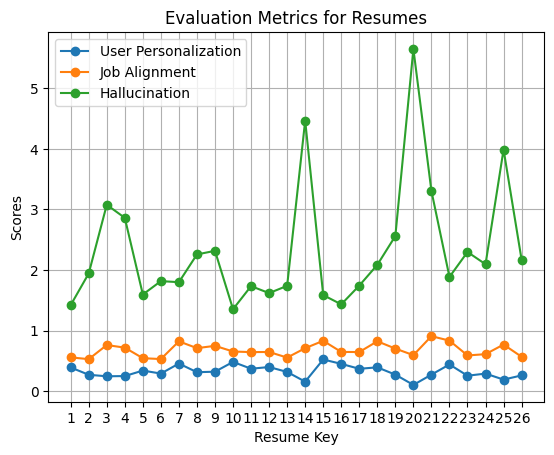

In [21]:
# input data
results_finetune = []
# convert input data into JSON format
for idx, key in enumerate(list(improved_data.keys())):
    resume_details_json = json.dumps(result_resume[idx])
    user_data_json = json.dumps(original_sections_list[idx])
    job_details_json = json.dumps(job_details_list[idx])
    
    # calculate metrics
    print("\nCalculating cosine_similarity...")
    user_personalization = cosine_similarity(resume_details_json, user_data_json)
    job_alignment = cosine_similarity(resume_details_json, job_details_json)
    hallucination = job_alignment/user_personalization
    
    print(f"User Personalization Score: {user_personalization:.4f}")
    print(f"Job Alignment Score: {job_alignment:.4f}")
    print(f"Model hallucination Score: {hallucination:.4f}")

    # Append results to list
    results_finetune.append({
        "Resume Key": key,
        "User Personalization": user_personalization,
        "Job Alignment": job_alignment,
        "Hallucination": hallucination
    })

import matplotlib.pyplot as plt
# Convert results to DataFrame
results_df_finetune = pd.DataFrame(results_finetune)
# Bar plot for metrics
for metric in ["User Personalization", "Job Alignment", "Hallucination"]:
    plt.plot(results_df_finetune["Resume Key"], results_df_finetune[metric], marker='o', label=metric)

plt.title("Evaluation Metrics for Resumes")
plt.xlabel("Resume Key")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.show()

## GPT Model

In [22]:
original_sections_list = df_eval["summarized_sections"].tolist()
job_details_list = df_eval["extracted_job_details"].tolist()

In [23]:
# input data
results = []
# convert input data into JSON format
for idx, key in enumerate(list(improved_data.keys())):
    resume_details_json = json.dumps(improved_data[key])
    user_data_json = json.dumps(original_sections_list[idx])
    job_details_json = json.dumps(job_details_list[idx])
    
    # calculate metrics
    print("\nCalculating cosine_similarity...")
    user_personalization = cosine_similarity(resume_details_json, user_data_json)
    job_alignment = cosine_similarity(resume_details_json, job_details_json)
    hallucination = job_alignment/user_personalization
    
    print(f"User Personalization Score: {user_personalization:.4f}")
    print(f"Job Alignment Score: {job_alignment:.4f}")
    print(f"Model hallucination Score: {hallucination:.4f}")

    # Append results to list
    results.append({
        "Resume Key": key,
        "User Personalization": user_personalization,
        "Job Alignment": job_alignment,
        "Hallucination": hallucination
    })


Calculating cosine_similarity...
User Personalization Score: 0.7399
Job Alignment Score: 0.3426
Model hallucination Score: 0.4630

Calculating cosine_similarity...
User Personalization Score: 0.8219
Job Alignment Score: 0.3962
Model hallucination Score: 0.4820

Calculating cosine_similarity...
User Personalization Score: 0.6684
Job Alignment Score: 0.1732
Model hallucination Score: 0.2591

Calculating cosine_similarity...
User Personalization Score: 0.8317
Job Alignment Score: 0.1584
Model hallucination Score: 0.1905

Calculating cosine_similarity...
User Personalization Score: 0.8722
Job Alignment Score: 0.3156
Model hallucination Score: 0.3618

Calculating cosine_similarity...
User Personalization Score: 0.6228
Job Alignment Score: 0.2724
Model hallucination Score: 0.4373

Calculating cosine_similarity...
User Personalization Score: 0.6979
Job Alignment Score: 0.3575
Model hallucination Score: 0.5123

Calculating cosine_similarity...
User Personalization Score: 0.9335
Job Alignment 

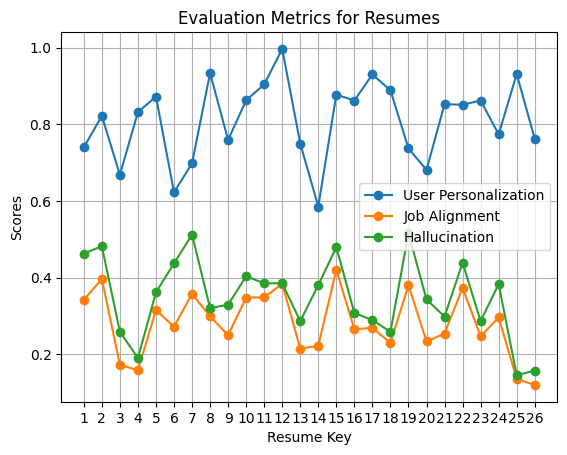

In [24]:
import matplotlib.pyplot as plt
# Convert results to DataFrame
results_df = pd.DataFrame(results)
# Bar plot for metrics
for metric in ["User Personalization", "Job Alignment", "Hallucination"]:
    plt.plot(results_df["Resume Key"], results_df[metric], marker='o', label=metric)

plt.title("Evaluation Metrics for Resumes")
plt.xlabel("Resume Key")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
results_df_finetune['Resume Key'] = results_df_finetune['Resume Key'].astype(int)
results_df_origin['Resume Key'] = results_df_origin['Resume Key'].astype(int)
results_df["Resume Key"] = results_df["Resume Key"].astype(int)

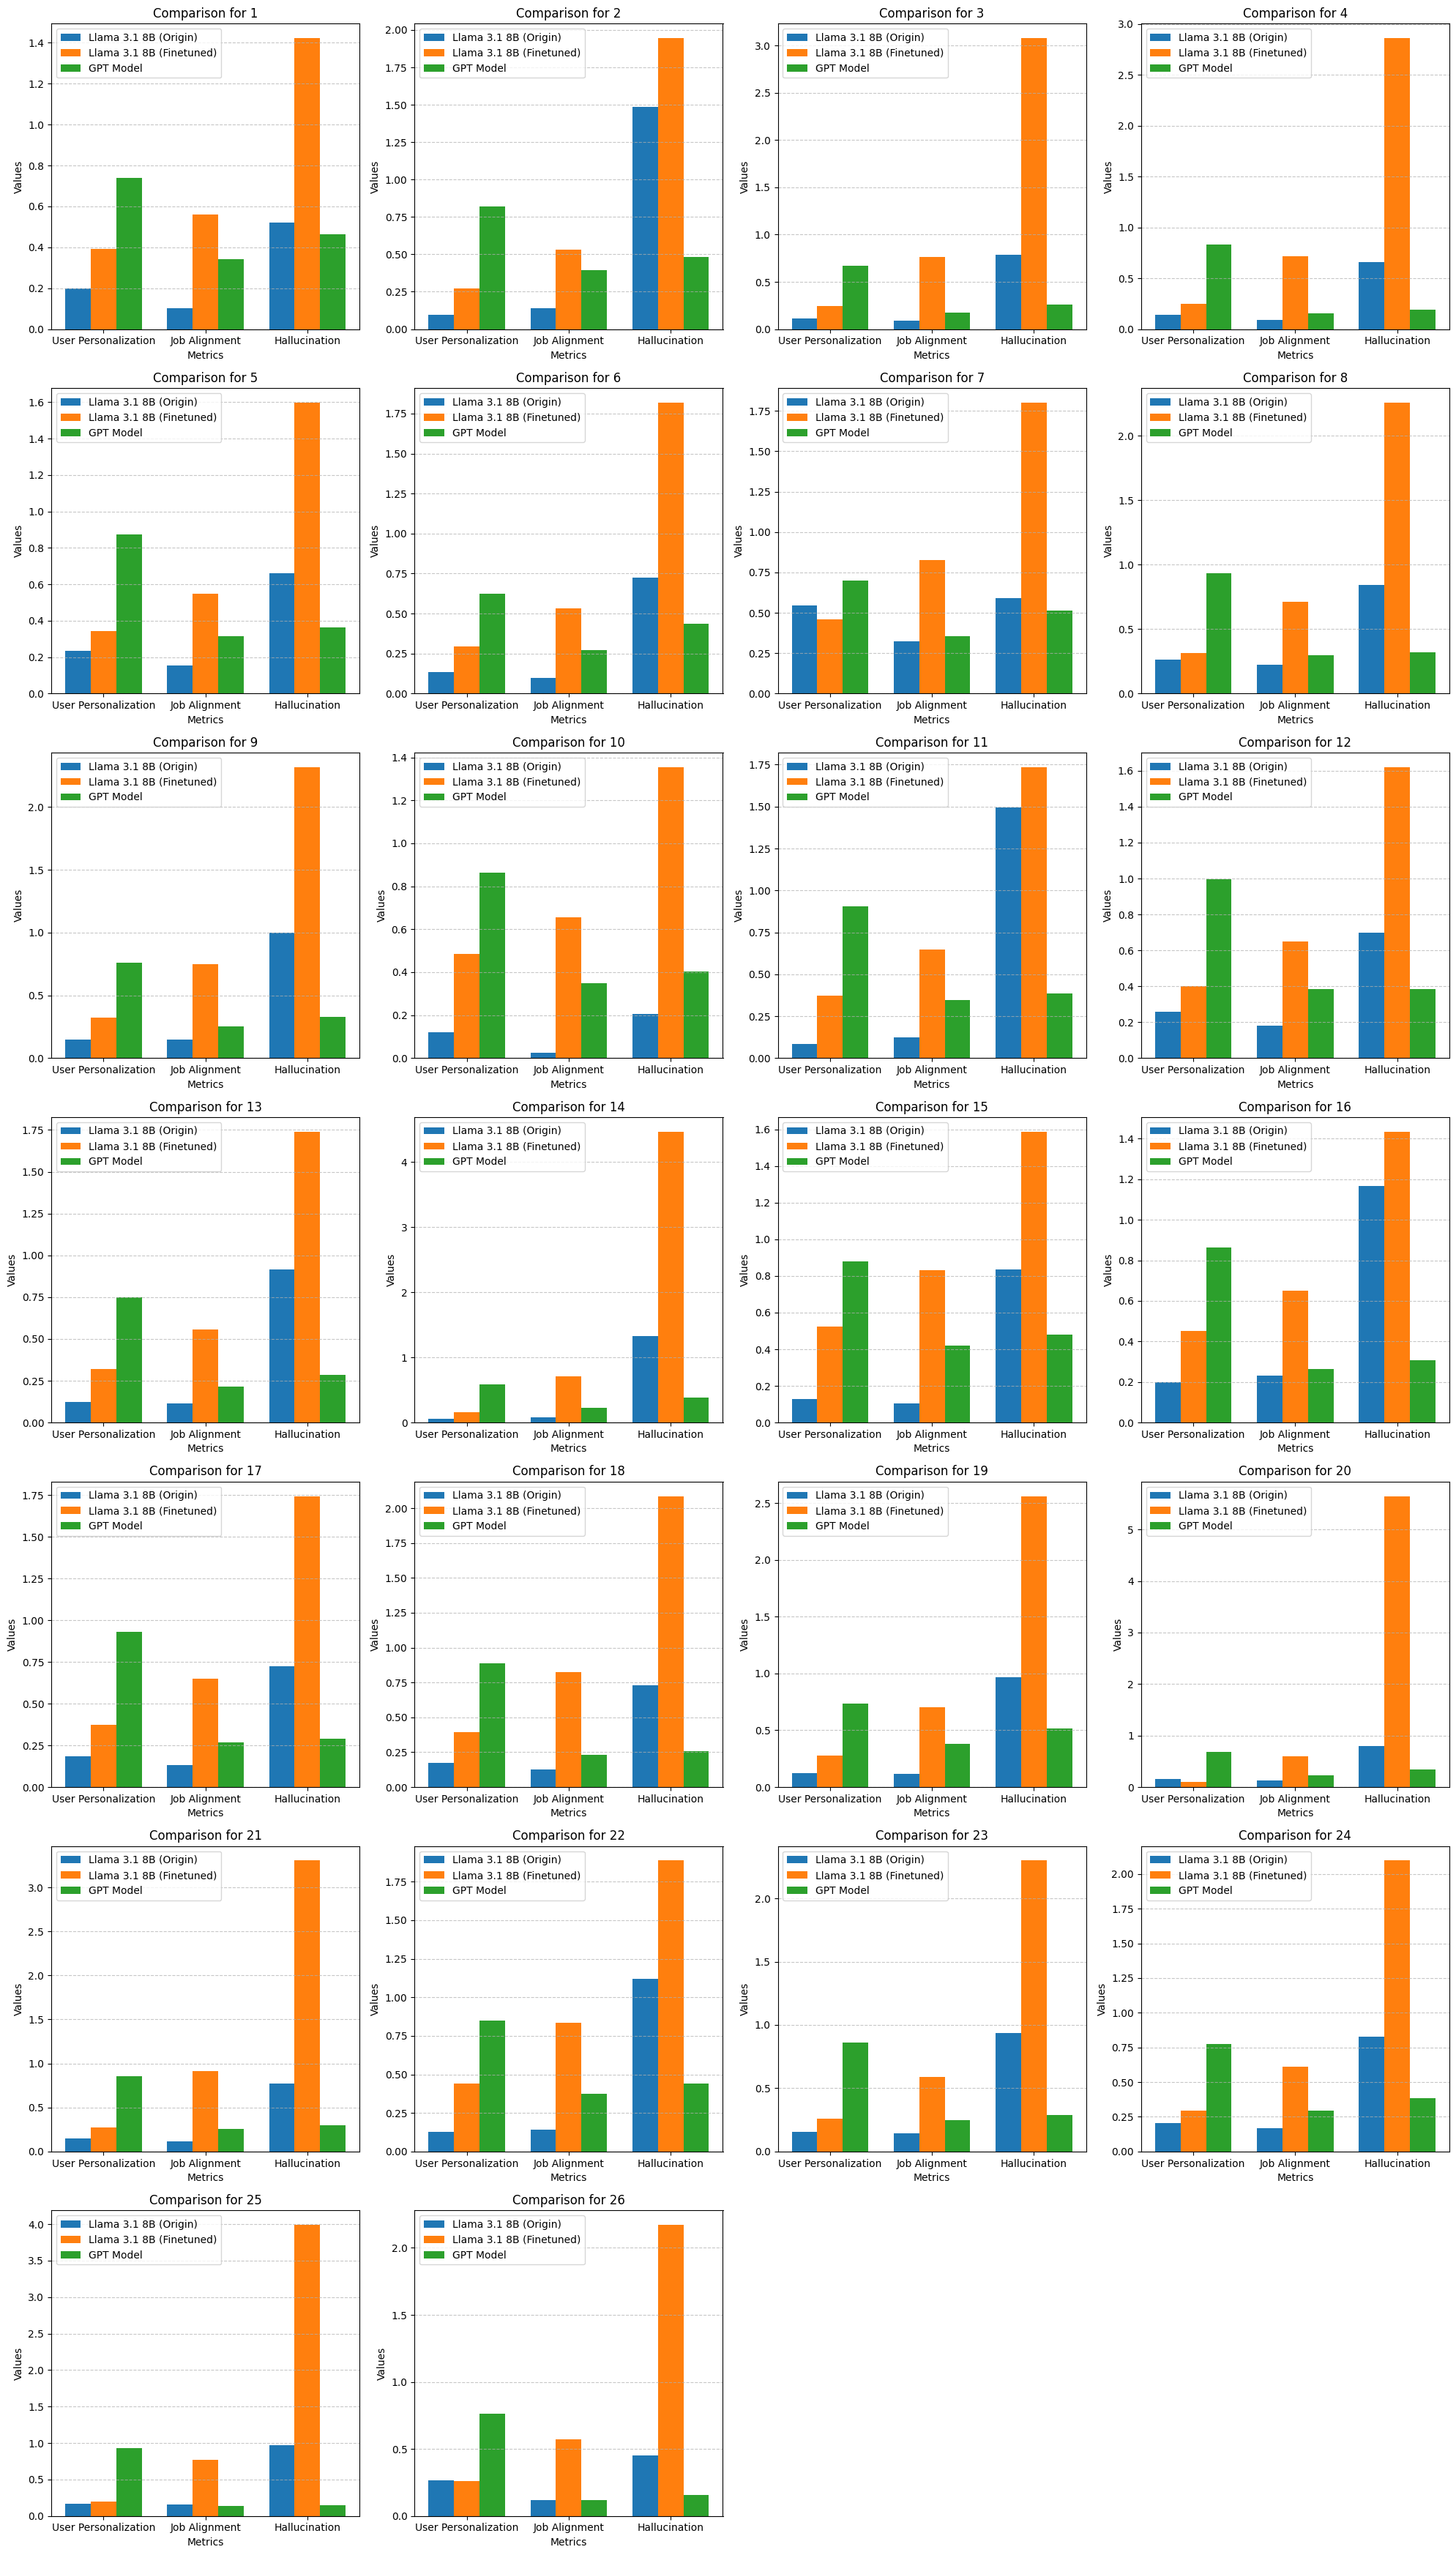

In [26]:
import matplotlib.pyplot as plt

# Merging the DataFrames
merged_df = pd.merge(results_df_origin, results_df_finetune, on="Resume Key", suffixes=('_origin', '_finetune'))
merged_df = pd.merge(merged_df, results_df, on="Resume Key", suffixes=('', '_gpt'))

# Labels and settings
labels = ["User Personalization", "Job Alignment", "Hallucination"]
width = 0.25  # Width of the bars

# Define number of columns and rows for the grid
graphs_per_row = 4
num_resumes = len(merged_df["Resume Key"].unique())
num_rows = -(-num_resumes // graphs_per_row)  # Ceiling division for rows

# Initialize the figure
fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Generate bar charts for each Resume Key
for idx, resume_key in enumerate(merged_df["Resume Key"].unique()):
    data = merged_df[merged_df["Resume Key"] == resume_key]
    
    origin_values = data[[f"{label}_origin" for label in labels]].values.flatten()
    finetune_values = data[[f"{label}_finetune" for label in labels]].values.flatten()
    gpt_values = data[[f"{label}" for label in labels]].values.flatten()
    
    x = range(len(labels))
    
    ax = axes[idx]
    ax.bar([p - width for p in x], origin_values, width, label="Llama 3.1 8B (Origin)")
    ax.bar(x, finetune_values, width, label="Llama 3.1 8B (Finetuned)")
    ax.bar([p + width for p in x], gpt_values, width, label="GPT Model")
    
    ax.set_title(f"Comparison for {resume_key}")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Hide unused subplots
for idx in range(num_resumes, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


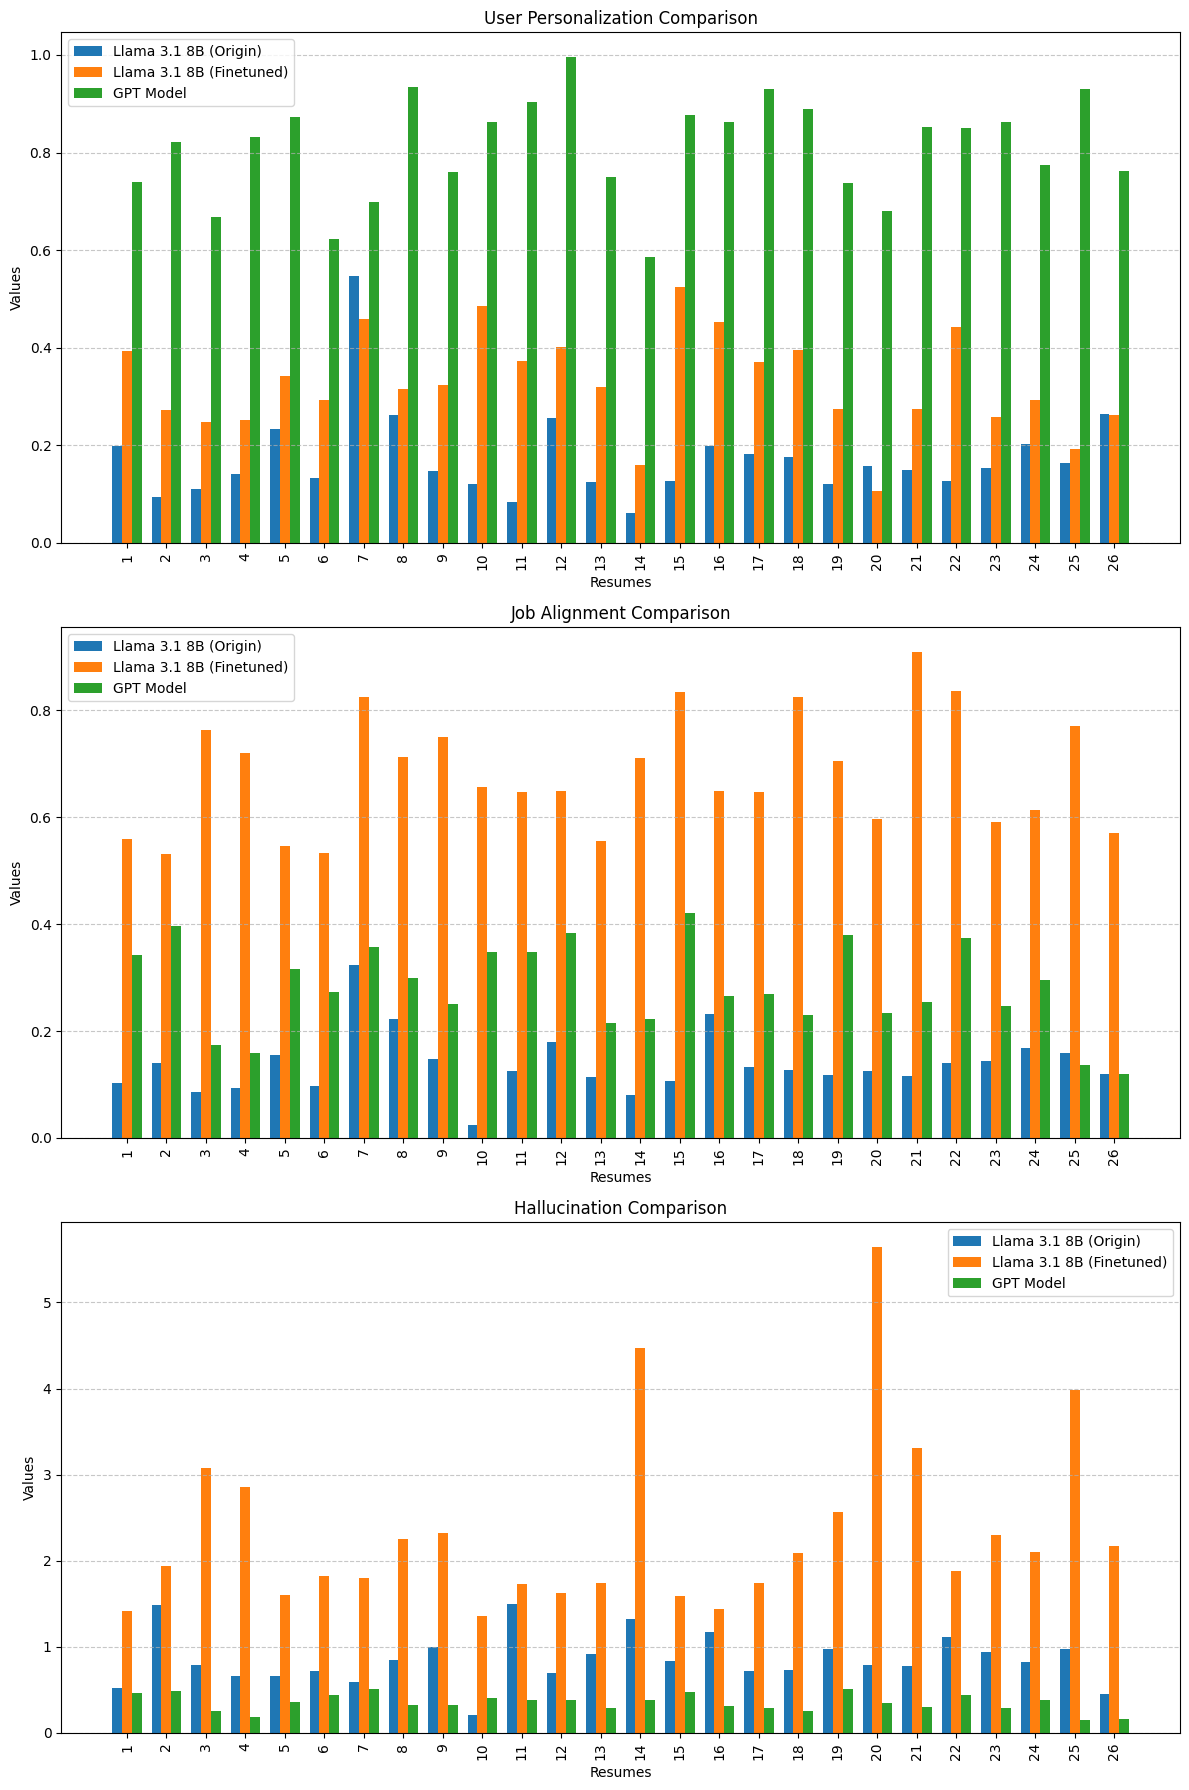

Number of Samples where Fine-Tuned Model is Highest:
  User Personalization: 0 / 26 samples
  Job Alignment: 26 / 26 samples
  Hallucination: 26 / 26 samples


In [29]:
# Labels and settings
metrics = ["User Personalization", "Job Alignment", "Hallucination"]
width = 0.25  # Width of the bars

# Count the number of times finetuned results are the highest
finetune_highest_count = {metric: 0 for metric in metrics}

# Initialize the figure for metric-by-metric plots (one row per graph)
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)))  
axes = axes.flatten()  # Flatten axes to ensure easy iteration

# Iterate over each metric
for idx, metric in enumerate(metrics):
    # Extract the relevant columns
    origin_values = merged_df[f"{metric}_origin"]
    finetune_values = merged_df[f"{metric}_finetune"]
    gpt_values = merged_df[f"{metric}"]
    
    # Count occurrences where finetuned is the highest
    finetune_highest_count[metric] = np.sum((finetune_values > origin_values) & (finetune_values > gpt_values))

    # Bar chart for all resumes for the current metric
    x = range(len(merged_df["Resume Key"]))
    ax = axes[idx]
    
    ax.bar([p - width for p in x], origin_values, width, label="Llama 3.1 8B (Origin)")
    ax.bar(x, finetune_values, width, label="Llama 3.1 8B (Finetuned)")
    ax.bar([p + width for p in x], gpt_values, width, label="GPT Model")
    
    ax.set_title(f"{metric} Comparison")
    ax.set_xlabel("Resumes")
    ax.set_ylabel("Values")
    ax.set_xticks(x)
    ax.set_xticklabels(merged_df["Resume Key"], rotation=90)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print Summary: Number of times finetuned results are highest
print("Number of Samples where Fine-Tuned Model is Highest:")
for metric, count in finetune_highest_count.items():
    print(f"  {metric}: {count} / {len(merged_df)} samples")


## Rouge

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
from rouge_score import rouge_scorer

# Initialize ROUGE Scorer
scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)

# Lists to store ROUGE-Lsum F1 scores
rouge_finetune_scores = []
rouge_origin_scores = []

In [11]:
finetune_better_count = 0
for idx, key in enumerate(list(improved_data.keys())):
    gpt = json.dumps(improved_data[key])
    finetune = json.dumps(result_resume[idx])
    origin = json.dumps(result_resume_origin[idx])

    # Calculate ROUGE-Lsum F1 scores
    rouge_finetune = scorer.score(gpt, finetune)['rougeLsum'].fmeasure
    rouge_origin = scorer.score(gpt, origin)['rougeLsum'].fmeasure

    # Append scores to the lists
    rouge_finetune_scores.append(rouge_finetune)
    rouge_origin_scores.append(rouge_origin)

    # Check if fine-tuned score is higher than original score
    if rouge_finetune > rouge_origin:
        finetune_better_count += 1

    print(f"Sample {idx+1}:")
    print(f"  ROUGE-Lsum (GPT vs Fine-tuned): {rouge_finetune:.4f}")
    print(f"  ROUGE-Lsum (GPT vs Original): {rouge_origin:.4f}")
    print('-' * 50)

Sample 1:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1317
  ROUGE-Lsum (GPT vs Original): 0.1984
--------------------------------------------------
Sample 2:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1100
  ROUGE-Lsum (GPT vs Original): 0.1655
--------------------------------------------------
Sample 3:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1165
  ROUGE-Lsum (GPT vs Original): 0.2141
--------------------------------------------------
Sample 4:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1809
  ROUGE-Lsum (GPT vs Original): 0.1874
--------------------------------------------------
Sample 5:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1840
  ROUGE-Lsum (GPT vs Original): 0.1856
--------------------------------------------------
Sample 6:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1645
  ROUGE-Lsum (GPT vs Original): 0.2442
--------------------------------------------------
Sample 7:
  ROUGE-Lsum (GPT vs Fine-tuned): 0.1194
  ROUGE-Lsum (GPT vs Original): 0.1839
--------------------------------------------------
Sample 8:
  R

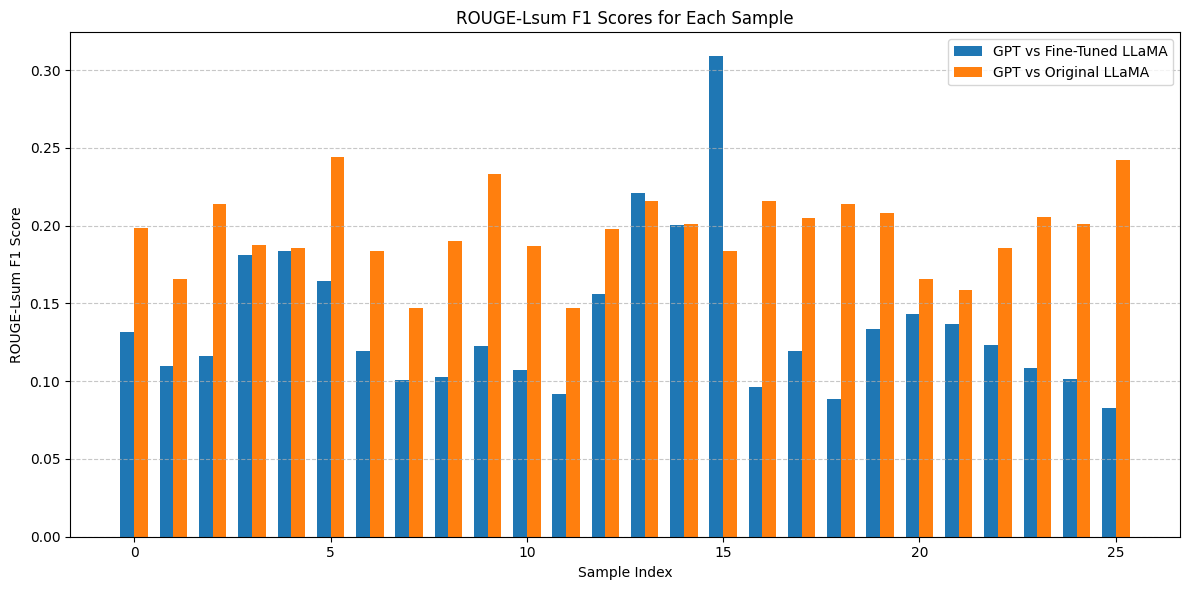

In [12]:
# Convert results to numpy arrays for summarization
rouge_finetune_scores = np.array(rouge_finetune_scores)
rouge_origin_scores = np.array(rouge_origin_scores)

# Visualization: Comparison of ROUGE scores across samples
x = np.arange(len(improved_data))  # X-axis labels: sample indices
width = 0.35  # Bar width

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, rouge_finetune_scores, width=width, label='GPT vs Fine-Tuned LLaMA')
plt.bar(x + width/2, rouge_origin_scores, width=width, label='GPT vs Original LLaMA')

plt.title("ROUGE-Lsum F1 Scores for Each Sample")
plt.xlabel("Sample Index")
plt.ylabel("ROUGE-Lsum F1 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Final Summary:
  Average ROUGE-Lsum F1 Score (GPT vs Fine-tuned LLaMA): 0.1366
  Average ROUGE-Lsum F1 Score (GPT vs Original LLaMA): 0.1955
  Number of Samples where Fine-Tuned > Original: 2 / 26


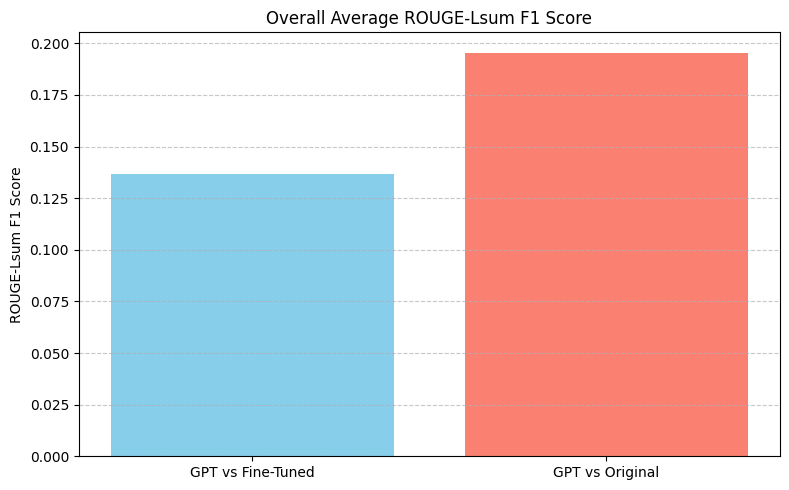

In [13]:
# Overall summary
avg_finetune = rouge_finetune_scores.mean()
avg_origin = rouge_origin_scores.mean()

print("Final Summary:")
print(f"  Average ROUGE-Lsum F1 Score (GPT vs Fine-tuned LLaMA): {avg_finetune:.4f}")
print(f"  Average ROUGE-Lsum F1 Score (GPT vs Original LLaMA): {avg_origin:.4f}")
print(f"  Number of Samples where Fine-Tuned > Original: {finetune_better_count} / {len(improved_data)}")

# Visualization: Overall Comparison
labels = ['GPT vs Fine-Tuned', 'GPT vs Original']
averages = [avg_finetune, avg_origin]

plt.figure(figsize=(8, 5))
plt.bar(labels, averages, color=['skyblue', 'salmon'])
plt.title("Overall Average ROUGE-Lsum F1 Score")
plt.ylabel("ROUGE-Lsum F1 Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()